Here are all the module imports and global settings (such as plot styles and warning levels) for the whole notebook.

In [98]:
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import networkx as nx
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import scipy as sc
import seaborn as sns
import torch.nn.functional as F 

import dot2tex
import hyperopt
import math
import os
import plotly
import sklearn
import torch
import warnings

from graphviz import Digraph
from hyperopt import hp, fmin, tpe
from IPython.display import Image
from matplotlib import colors
from networkx.drawing.nx_agraph import to_agraph
from plotly.offline import plot
from pytorch_model_summary import summary
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.utils import shuffle
from sklearn.utils.class_weight import compute_class_weight
from utils import make_meshgrid, countour_lr2, countour_SVM2

plt.rc("font", size=15)

plt.rc('xtick', color='k', labelsize='medium', direction='in')
plt.rc('xtick.major', size=8, pad=12)
plt.rc('xtick.minor', size=8, pad=12)

plt.rc('ytick', color='k', labelsize='medium', direction='in')
plt.rc('ytick.major', size=8, pad=12)
plt.rc('ytick.minor', size=8, pad=12)

pylab.rcParams['figure.figsize'] = 5, 5

warnings.filterwarnings("ignore")

# Table Of Contents:

* [**Deep learning : representation then task**](#dl_rep_task)
    * [**Linearly separable data.**](#linear_sep)
    * [**Basic logistic regression.**](#logistic)
    * [**Non-linearly-separable data : the infamous Xor problem.**](#non_linear_sep)
    * [**Basic logistic regression fails.**](#logistic_fail)
    * [**But non linear kernel SVM does the trick.**](#svm)
    * [**A more basic and better embbeding for our problem: adding a dimension.**](#dim_add)
    
    
* [**Solving the Xor problem with Pytorch and Deep Learning.**](#xor_torch)
    * [**Implementing basic logistic regression with Pytorch.**](#logistic_torch)
    * [**Shallow feed forward neural networks : embedding then classifying.**](#shallow_ff)
    * [**Training and visualizing our model.**](#train_visual)
    * [**Wrapping up feedforward network and leading to generalization.**](#gen)
    * [**Writting a custom deep feedforward network for multiclass problems (blocks).**](#blocks)
    
    
* [**Bits and pieces of a deep neural network.**](#bits_pieces)
    * [**A real biological dataset : prediction of subcellular localization from sequences features.**](#dataset)
    * [**Shallow feed forward neural networks : embedding then classifying.**](#shallow_ff)
    * [**Forward propagation.**](#forward)
        * [**Loss functions.**](#loss)
        * [**Regularization : L2, dropout, early stopping.**](#regularization)
    * [**Back propagation.**](#back_propagation)
    * [**Optimization.**](#optimization)
        * [**A non-exhaustive list of the usual optimizers: SGD, momentum and ADAM.**](#optim_list)
        * [**Mini-batch : easier to reach global minima and less memory/operations.**](#mini_batch)
    * [**Activation functions.**](#activation)
    * [**Weight initialization.**](#initialization)
    * [**Normalization.**](#normalization)
        * [**Input scaling.**](#input_scale)
        * [**Batch normalization.**](#bn)
        
        
* [**Hyperparameter optimization**](#hyperopt)


* [**Transfer learning**](#transfert)


# Deep learning : representation then task <a class="anchor" id="dl_rep_task"></a>

In [99]:
np.random.seed(10815657)  # Set a random seed for reproducibility

mock_data = []

centers = np.array([[0,0],[0,1],[1,0],[1,1]])

for v in range(4):
    for i in range(100):
        mock_data.append(np.random.randn(2) * 0.1 + centers[v])

## Linearly separable data <a class="anchor" id="linear_sep"></a>

We say that data with binary labels is linearly separable if there is a hyperplane that separates the different labels. That is, all data points labeled $0$ are on one side of the hyperplane and all points labeled $1$ are on the other.

In [100]:
dico_color={0:'blue', 1:'red'}  # Dictionary assigning a color to each label

In [101]:
dico_separable = {i:0 if int(i / 100) < 2 else 1 for i in range(len(mock_data))}

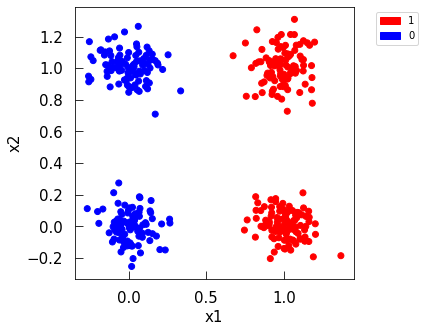

In [102]:
red_patch = mpatches.Patch(color='red', label='1')
blue_patch = mpatches.Patch(color='blue', label='0')
list_patches = [red_patch, blue_patch]

# Scatterplot
plt.scatter([p[0] for p in mock_data], 
            [p[1] for p in mock_data],
            c=[dico_color[dico_separable[i]] for i in range(len(mock_data))])

plt.legend(handles=list_patches, fontsize=10, bbox_to_anchor=(0.75, 0.5, 0.5, 0.5))
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()

In [103]:
# Represent the data as a pandas.DataFrame
X_separable_df = pd.DataFrame(np.array(mock_data), columns=['x1','x2'])
X_separable_df['classe'] = [dico_separable[i] for i in range(len(mock_data))]

## Basic logistic regression <a class="anchor" id="linear_sep"></a>

[Logistic regression](https://en.wikipedia.org/wiki/Logistic_regression) is a linear classification model. To fit is, one assumes that all the observations in the sample are independently Bernoulli distributed, and then maximizes the likelihood of the labels given the sample.

Let's say we decide to fit a logistic regression to model the two classes. Here I don't put (almost) any regularization, hence the L2 regularization strength $\alpha$ being close to 0.

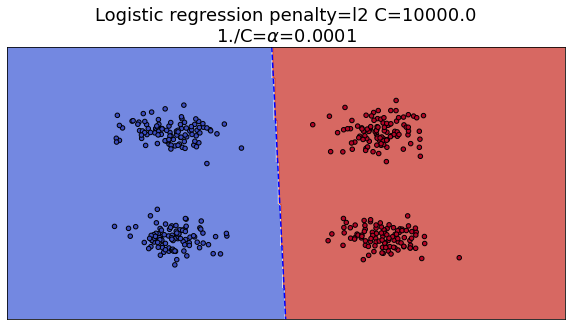

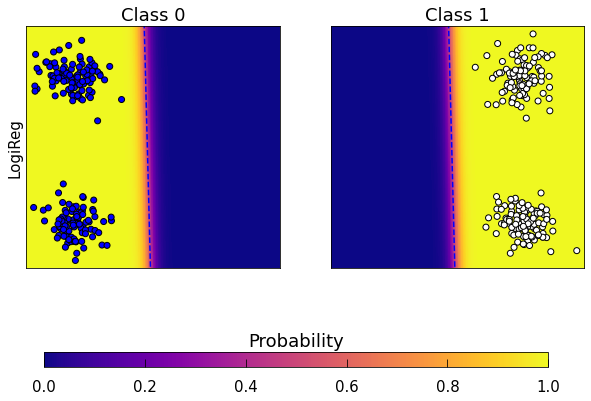

In [104]:
alpha = 1 / 10000
countour_lr2('l2', np.array(X_separable_df[['x1','x2']]), X_separable_df['classe'], 1 / alpha , 'ovr')

## Non linearly separable data : the infamous Xor problem <a class="anchor" id="non_linear_sep"></a>

Data is non linearly separable if there is no hyperplane that cleanly separates the data points.

In [105]:
dico_not_separable = {i:1 if int(i / 100) == 0 or int(i / 100) == 3 else 0 for i in range(len(mock_data))}

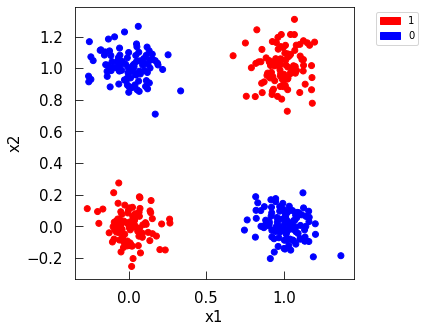

In [106]:
# Scatterplot
plt.scatter([p[0] for p in mock_data],
            [p[1] for p in mock_data],
            c=[dico_color[dico_not_separable[i]] for i in range(len(mock_data))])

plt.legend(handles=list_patches, fontsize=10, bbox_to_anchor=(0.75, 0.5, 0.5, 0.5))
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()

In the next cell I just randomly shuffle the data, don't worry about it for now. It is just a habit: I like to have any random subsample of my data be well represented in term of the balance of classes. Moreover, it will be important to have well mixed data later on when we do Stochastic Gradient Descent (SGD).

In [107]:
# Represent data as a pandas.DataFrame
X_not_separable_df = pd.DataFrame(np.array(mock_data), columns=['x1', 'x2'])
X_not_separable_df['classe'] = [dico_not_separable[i] for i in range(len(mock_data))]
X_not_separable_df = shuffle(X_not_separable_df, random_state=42)  # The shuffle
X_not_separable_df.reset_index(inplace=True)
X_not_separable_df.head()

index        x1        x2  classe
0    209  0.903817  0.002759       0
1    280  1.075973  0.070959       0
2     33  0.010399 -0.022057       1
3    210  0.946742  0.156762       0
4     93 -0.062423 -0.040342       1

## Basic logistic regression fails <a class="anchor" id="logistic_fail"></a>

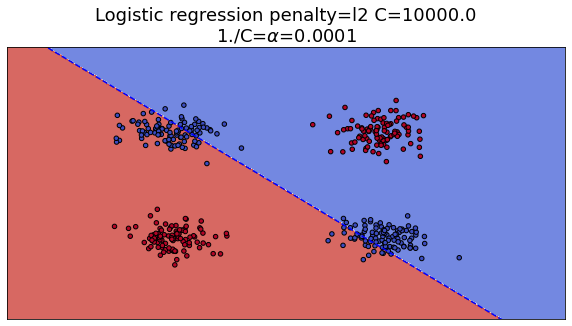

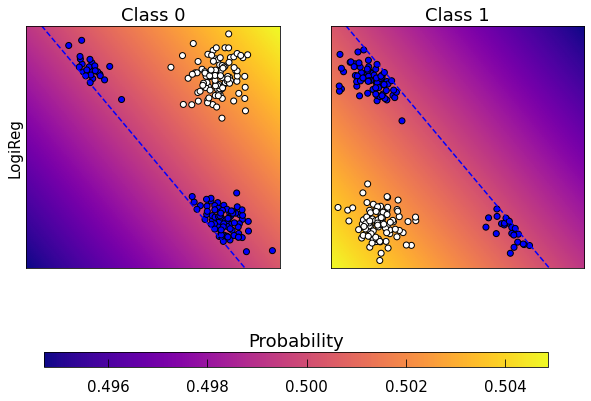

In [108]:
alpha = 1 / 10000
countour_lr2('l2', np.array(X_not_separable_df[['x1', 'x2']]), X_not_separable_df['classe'], 1 / alpha ,'ovr')

Obviously as this implementation of the logistic regression can only draw simple affine hyperplane of isoprobability, and the decision boundary is clearly not a line, the classification model fails.

## But non linear kernel SVM does the trick <a class="anchor" id="svm"></a>

The decision boundaries of [kernel](https://en.wikipedia.org/wiki/Kernel_method) SVM's can be more complex than simple hyperlines.

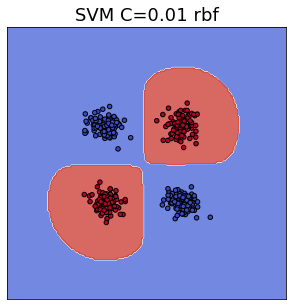

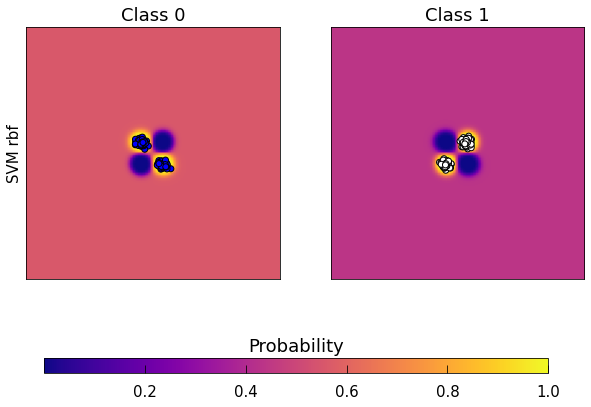

In [109]:
countour_SVM2(np.array(X_not_separable_df[['x1','x2']]),
              np.array(X_not_separable_df['classe']),
              0.01, 'rbf', 2, 10, 'ovr')

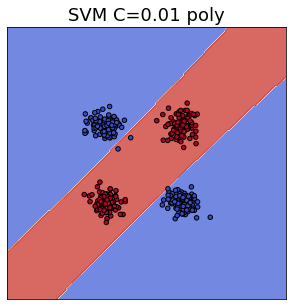

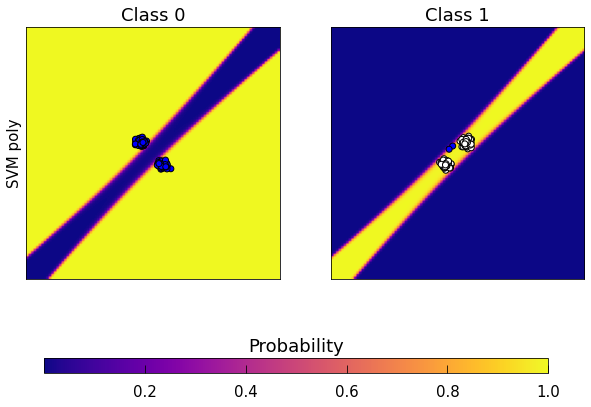

In [110]:
countour_SVM2(np.array(X_not_separable_df[['x1','x2']]),
              np.array(X_not_separable_df['classe']),
              0.01, 'poly', 2, 10, 'ovr')

When you use a non-linear kernel in support vector machine modelling, you are actually making your data points behave as if they were embedded in some manifold (with potentially infinite dimensions) equipped with a non-Euclidian metric. That embedding is then a non linear transformation of your initial space. The data, once embedded/represented on that manifold will hopefully be linearly separable, in which case we could proceed to use the usual support vector machine. This is known as the ["kernel trick"](https://en.wikipedia.org/wiki/Kernel_method).

## A more basic and better embbeding for our problem: adding a dimension <a class="anchor" id="dim_add"></a>

Our data was not linearly separable in two dimensions, but there is a $3$-dimensional plane that can separate it, provided we locate the data conveniently along the third dimension.   

In [111]:
X_not_separable_more_df = X_not_separable_df.copy()
X_not_separable_more_df['(x1-x2)**2'] = (X_not_separable_df['x1'] - X_not_separable_df['x2']) ** 2

In [112]:
fig=go.Figure()

fig.add_trace(go.Scatter3d(x=X_not_separable_more_df['x1'], 
                           y=X_not_separable_more_df['x2'],
                           z=X_not_separable_more_df['(x1-x2)**2'],
                           mode='markers',
                           marker=dict(size=[10]*len(X_not_separable_more_df),
                                       line=dict(width=0,
                                       color=None),
                           color=[dico_color[X_not_separable_df['classe'].loc[i]] for i in X_not_separable_df.index]),
                           connectgaps=False,
                           hovertemplate = '<i><b>x<b></i>: %{x:.2f}<br>'+
                                           '<i><b>y<b></i>: %{y:.2f}'+
                                           '<br><b>z</b>: %{z:.2f}<br>'))

fig.update_layout(title='Dimension augmentation in Xor problem',
                  title_x=0.5,
                  xaxis_title='x1',
                  yaxis_title='x2')

plot(fig, filename='images_intro/augmented_Xor.html')
fig.show()

Just by adding another dimension to our space ($(x_1-x_2)^2$), the dataset becomes linearly separable. So the heart of the game is to find good representations.

# Solving the Xor problem with Pytorch and Deep Learning <a class="anchor" id="xor_torch"></a>

## Recoding the basic logistic regression with Pytorch <a class="anchor" id="logistic_torch"></a>

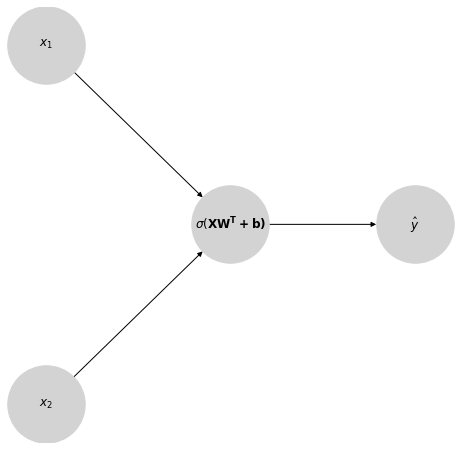

In [113]:
# Add GraphViz installation location to the path
os.environ["PATH"] += os.pathsep + '/home/seb/graphviz-2.38/release/bin/'

# Represent a neural network as a graph
dot = nx.DiGraph()
dot.add_node("A", pos=(0,0))
dot.add_node("x1", pos=(-0.5,0.5))
dot.add_node("x2", pos=(-0.5,-0.5))
dot.add_node("y", pos=(0.5,0))
dot.add_edge("x1", "A")
dot.add_edge("x2", "A")
dot.add_edge("A", "y")

# Node positions
pos = nx.get_node_attributes(dot,'pos')

# Draw the graph
plt.figure(figsize=(8, 8))

nx.draw_networkx_labels(dot, pos, {"A":r"$\sigma(\bf{XW^{T}+b})$",
                                   "x1":r"$x_1$","x2":r"$x_2$",
                                   "y":r"$\hat{y}$"})
nx.draw(dot, pos, node_size=6000, node_color='lightgrey')

plt.show()

In [114]:
# Logistic regression as a Pytorch module
class Homemade_Logisticreg(torch.nn.Module):
    
    def __init__(self):
        super(Homemade_Logisticreg, self).__init__()
        self.fc = nn.Linear(1, 1)          # Linear layer
        self.sigmoid = torch.nn.sigmoid()  # Non-linear activation
        
    def forward(self, x):  # Forward pass
        output = self.fc(x)
        output = self.sigmoid(output) 
        return output

## Shallow feed forward neural network : embedding then classifying <a class="anchor" id="shallow_ff"></a>

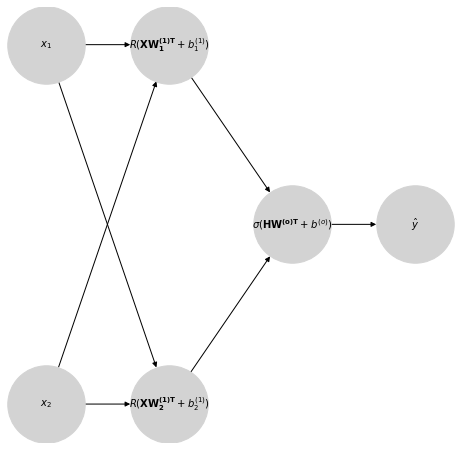

In [115]:
# Represent a neural network as a directed graph
dot = nx.DiGraph()
dot.add_node("A", pos=(0, 0))
dot.add_node("x1", pos=(-1./2, 1./3))
dot.add_node("x2", pos=(-1./2, -1./3))
dot.add_node("h1", pos=(-1./4, 1./3))
dot.add_node("h2", pos=(-1./4, -1./3))
dot.add_node("y", pos=(1./4, 0))
dot.add_edge("x1", "h1")
dot.add_edge("x2", "h1")
dot.add_edge("x1", "h2")
dot.add_edge("x2", "h2")
dot.add_edge("h1", "A")
dot.add_edge("h2", "A")
dot.add_edge("A", "y")

# Node postitions
pos = nx.get_node_attributes(dot, 'pos')

# Draw
plt.figure(figsize=(8, 8))

nx.draw_networkx_labels(dot, pos, {"A":r"$\sigma(\mathbf{HW^{(o)T}}+b^{(o)})$",
                                   "h1":r"$R(\mathbf{XW^{(1)T}_{1}}+b^{(1)}_{1})$",
                                   "h2":r"$R(\mathbf{XW^{(1)T}_{2}}+b^{(1)}_{2})$",
                                   "x1":r"$x_1$","x2":r"$x_2$",
                                   "y":r"$\hat{y}$"},font_size=10)
nx.draw(dot, pos, node_size=6000, node_color='lightgrey')

plt.show()

You might recognize the $\sigma(\bf{HW^{(o)T}+b^{(o)}})$ node a logistic regression operation on your data points in the space $\mathcal{H}$ rather than $\mathcal{X}$. You embed your points in the $\mathcal{H}$ space by non lineraly transforming them. This transformation is linear up to $\bf{R}$, called the activation function. Activation functions can be of many sorts and we will spend some time looking at them later. Here I used the [Rectified Linear Unit (ReLU)](https://en.wikipedia.org/wiki/Rectifier_(neural_networks)) function : $x\longmapsto max(0,x)$.

The game is now to find a good set of embedding weights ($\{\bf{W^{(1)}},\bf{b^{(1)}}\}$) so that the logistic regression can do its work by finding good biases $\{\bf{W^{(o)}}, \bf{b^{(o)}}\}$. Note the upper script here, $o$, which stands for output.

Just to write down things clearly, given a single data point:
- $\mathbf{W^{(1)}}$ is a matrix of shape (2,2)
- $\mathbf{X}$ is a matrix of shape (1,2)
- $\mathbf{W^{(1)}_1}$ is a matrix of shape (1,2)
- Thus $\mathbf{XW^{(1)T}_{1}}$ is a scalar and so is $b^{(1)}_{1}$
- $\mathbf{H}$ is column vector of shape (1,2)
- $\mathbf{W^{(o)}}$ is a matrix of shape (1,2)

You also have to realize that here, nodes are scalars, and the connections between nodes are the elements of the weight matrices being multiplied by your data features, to yield a scalar in the node's output.

You could also see this graph as a composition of functions : $f=\sigma \circ \mathcal{W^{(o)}}\circ R \circ \mathcal{W^{(1)}}$.

In [116]:
class Feedforward(torch.nn.Module):  # Feed-forward neural network as a Pytorch module
    
        def __init__(self, input_size, hidden_size):
            super(Feedforward, self).__init__()
            self.input_size = input_size
            self.hidden_size  = hidden_size
            # Linear layer
            self.fc1 = torch.nn.Linear(self.input_size, self.hidden_size)  
            torch.nn.init.xavier_normal_(self.fc1.weight, 
                                         gain=torch.nn.init.calculate_gain('leaky_relu'))
            # ReLU activation
            self.relu = torch.nn.LeakyReLU(0.1)  
            # Linear layer
            self.fc2 = torch.nn.Linear(self.hidden_size, 1)
            # Sigmoid activation
            self.sigmoid = torch.nn.Sigmoid()  
            
        def forward(self, x):
            hidden = self.fc1(x)
            relu = self.relu(hidden)
            output = self.fc2(relu)
            output = self.sigmoid(output)
            return output

Later we will discuss in depth all the bits and pieces present here. For now wee can print a summary of this rather simple network: 

In [117]:
print(Feedforward(2, 2))

Feedforward(
  (fc1): Linear(in_features=2, out_features=2, bias=True)
  (relu): LeakyReLU(negative_slope=0.1)
  (fc2): Linear(in_features=2, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


In [118]:
print(summary(Feedforward(2, 2), torch.zeros((324, 2))))

-----------------------------------------------------------------------
      Layer (type)        Output Shape         Param #     Tr. Param #
          Linear-1            [324, 2]               6               6
       LeakyReLU-2            [324, 2]               0               0
          Linear-3            [324, 1]               3               3
         Sigmoid-4            [324, 1]               0               0
Total params: 9
Trainable params: 9
Non-trainable params: 0
-----------------------------------------------------------------------


The first linear layer has a 2x2 weight matrix (4 weights) and 2 biases, hence the 6 parameters. There are two linear functions involved in the network, each having a vector of size 2 as an input : so 4 weigths total for those two linear functions and of course one more bias per linear function.

Since the last layer has only one node, which takes the two outcomes of the previous layer, then this 1-node layer will be defined by two coefficients (weights) and 1 bias (3 parameters).

## Training and visualizing our model <a class="anchor" id="train_visual"></a>

In [119]:
# The "training loop", encapsulated as a function
def training_overview(model, epochs, x_train, y_train, x_val, y_val):
    
    # Training loss
    loss_fn = torch.nn.BCELoss() 
    
    # Optimizer
    optimizer = torch.optim.SGD(model.parameters(), lr = 0.1, momentum = 0.9)
    
    keep_loss=[]
    keep_loss_val=[]
    for epoch in range(epochs):
        
        # Set network to training mode
        model.train()  
        
        # Reset the gradient values
        optimizer.zero_grad()  
        
        # Forward pass
        output_train = model(x_train)
        
        # Compute Loss
        loss = loss_fn(output_train.squeeze(), y_train)
        keep_loss.append(loss.detach())
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        # Set network to evaluation mode
        model.eval()
        with torch.no_grad():  # Do not compute gradients in evaluation mode
            output_val = model(x_val)
            loss_val = loss_fn(output_val.squeeze(), y_val)
            keep_loss_val.append(loss_val.detach())
        
        # Log message every 100 epochs
        if epoch % 100 == 0:
            print('Epoch {}: train loss: {} validation loss: {}'.format(epoch, 
                                                                        loss.item(),
                                                                        loss_val.item()))        

    # Plot losses during training
    plt.plot(np.arange(epochs), keep_loss, 'r',label='training set')
    plt.plot(np.arange(epochs), keep_loss_val, 'b', label='validation set')
    
    plt.xlabel('Epochs')
    plt.ylabel('Binary cross entropy loss')
    plt.legend(loc='best')
    plt.show()

We will discuss later all the bits and pieces present here.

Still, note the use of the [binary cross entropy (BCE) loss](https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html) `torch.nn.BCELoss`, which is the good old negative log likelihood function for a Bernouilli distribution.

You can also see the use of an optimizer `torch.optim.SGD(model.parameters(), lr = 0.1,momentum = 0.9)`. It is a version of [Stochastic Gradient Descent (SGD)](https://en.wikipedia.org/wiki/Stochastic_gradient_descent) (you probably know already what gradient descent is), with a preset learning rate/gradient increment (`lr`) and some momentum.

The code is also organized in stages:

- First, we go into training mode: this tells the algorithms that it should allow the weigths and other training specific stuff to be learned.
- With this setup in place, we actually train using our `forward` method: the training/forward is just passing the data through the neural net.
- The forward pass allows us to compute the loss at the network's output.
- After the loss is calculated we can backpropagate: calculate the gradient of the loss at each neuron to update the weights and get ready for another forward pass.
- Finally, we go into evaluation mode `with.no_grad()`, which means that now we feed the neural network with unseen data and just check what it predicts. Everything else is locked in place: you block the weight values, remove some of the machinery you use for training, and tell the algorithm not to bother with gradient calculation.

All these stages repeat throughout `epochs` in an iterative process.

In [120]:
# Do a train/test/validation split of the data
X_train_val_df, X_test_df = train_test_split(X_not_separable_df,
                                             random_state=0,
                                             stratify=X_not_separable_df['classe'],
                                             test_size=0.1)

X_train_df, X_val_df = train_test_split(X_train_val_df,
                                        random_state=0,
                                        stratify=X_train_val_df['classe'],
                                        test_size=0.1)

# Pytorch needs the data to be represented as a torch tensor
x_train = torch.FloatTensor(np.array(X_train_df[['x1', 'x2']]))
x_val = torch.FloatTensor(np.array(X_val_df[['x1', 'x2']]))
y_train = torch.FloatTensor(np.array(X_train_df['classe']))
y_val = torch.FloatTensor(np.array(X_val_df['classe']))

Epoch 0: train loss: 0.8282504677772522 validation loss: 0.7615153789520264
Epoch 100: train loss: 0.46038681268692017 validation loss: 0.41642674803733826
Epoch 200: train loss: 0.45759767293930054 validation loss: 0.4153911769390106
Epoch 300: train loss: 0.45708489418029785 validation loss: 0.41454705595970154
Epoch 400: train loss: 0.4569379687309265 validation loss: 0.41446205973625183
Epoch 500: train loss: 0.45690375566482544 validation loss: 0.4143589735031128
Epoch 600: train loss: 0.4568871259689331 validation loss: 0.4143027067184448
Epoch 700: train loss: 0.4568779170513153 validation loss: 0.4142524003982544
Epoch 800: train loss: 0.4568716585636139 validation loss: 0.414230078458786
Epoch 900: train loss: 0.45686617493629456 validation loss: 0.4142085909843445


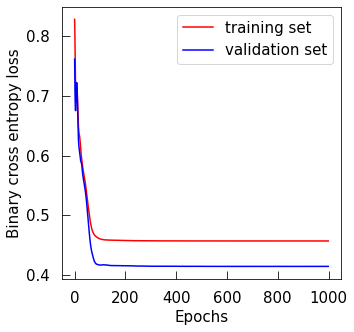

In [121]:
# Pick our classifier and call the training loop on it
model = Feedforward(2, 2)
epochs = 1000
training_overview(model, epochs, x_train, y_train, x_val, y_val)

As you can see, the loss tends to decrease with time (it can be bumpy). The drop is initially faster for the training set.

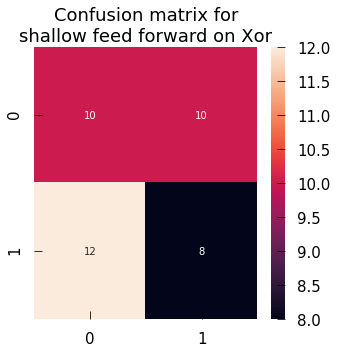

In [122]:
model.eval()

y_pred = model(torch.FloatTensor(np.array(X_test_df[['x1','x2']]))).detach().numpy()
y_pred=[0 if i<0.5 else 1 for i in y_pred]

# Confusion matrix
confusion_mc_c = confusion_matrix(np.array(X_test_df['classe']), y_pred)
df_cm_c = pd.DataFrame(confusion_mc_c, index=[0,1], columns=[0,1])

plt.figure(figsize=(5,5))
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion matrix for\nshallow feed forward on Xor')

sns.heatmap(df_cm_c, annot=True, annot_kws={"size": 10})

plt.show()
plt.close()

So we have our trained model and trained weights. We can actually have access to each of the weights of the model to see what what they do, rather than just have the final prediction.

In [123]:
# Pool the trained weights from the trained model to proceed to the representation

W_hidden=model.fc1.weight
b_hidden=model.fc1.bias

linear_representation = np.array(X_not_separable_df[['x1','x2']]) @ W_hidden.detach().numpy().T + \
                            b_hidden.detach().numpy()
ReLU_representation = [[i[p] if i[p]>0 else 0 for i in linear_representation] for p in range(2)]

xx, yy = make_meshgrid(np.array(X_not_separable_df['x1']), np.array(X_not_separable_df['x2']))
pred = model(torch.FloatTensor(np.c_[xx.ravel(), yy.ravel()])).detach().numpy()
Z = pred.reshape(xx.shape)

W_logreg = model.fc2.weight
b_logreg = model.fc2.bias

xx_rep, yy_rep = make_meshgrid(np.array(ReLU_representation[0]), np.array(ReLU_representation[1]))
pred_rep = sc.special.expit(np.array(np.c_[xx_rep.ravel(), yy_rep.ravel()]) @ W_logreg.detach().numpy().T + 
                            b_logreg.detach().numpy())

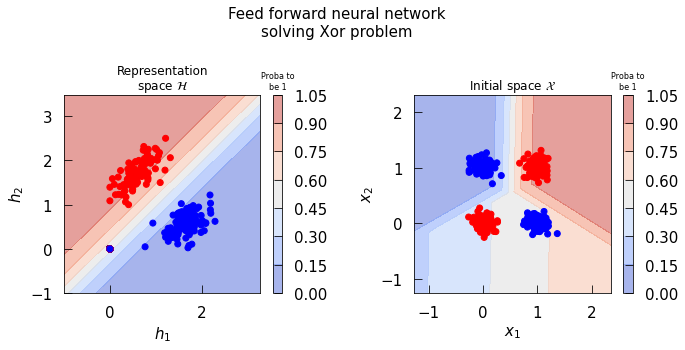

In [124]:
fig,ax = plt.subplots(1,2,figsize=(10, 5))
fig.suptitle('Feed forward neural network\nsolving Xor problem', fontsize=15)

CS0 = ax[0].contourf(xx_rep, yy_rep, pred_rep.reshape(yy_rep.shape), cmap=plt.cm.coolwarm, alpha=0.5)
ax[0].scatter(ReLU_representation[0],
              ReLU_representation[1],
              c=[dico_color[X_not_separable_df['classe'].loc[i]] for i in X_not_separable_df.index])

ax[0].set_xlabel(r'$h_1$')
ax[0].set_ylabel(r'$h_2$')
ax[0].set_title('Representation\nspace $\mathcal{H}$', fontsize=12)

cbar1 = plt.colorbar(CS0, ax=ax[0])
cbar1.ax.set_title('Proba to\nbe 1', fontsize=8)

CS1 = ax[1].contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.5)
ax[1].scatter(X_not_separable_df['x1'],
              X_not_separable_df['x2'],
              c=[dico_color[X_not_separable_df['classe'].loc[i]] for i in X_not_separable_df.index])

ax[1].set_xlabel(r'$x_1$')
ax[1].set_ylabel(r'$x_2$')
ax[1].set_title('Initial space $\mathcal{X}$', fontsize=12)

cbar2 = plt.colorbar(CS1, ax=ax[1])
cbar2.ax.set_title('Proba to\nbe 1', fontsize=8)

plt.tight_layout()
plt.show()

## Wrapping up feedforward network and leading to generalization. <a class="anchor" id="gen"></a>

Introducing some neural network vocabulary: 
- Input layer: ensemble of nodes at the beginning of the network representing your features space.
- Hidden layer(s): layer(s) of nodes between the input and output layers. Hidden layers are there to find a better representation for the data.
- Output layer: layer that will serve as your classifier or regressor. In classification this layer will typically condense in a fully connected way the nodes of the previous layer into $C$ nodes, C being the number of classes you have. You will have then a matrix with the probabilities that your points are in each of the classes.

We have just seen a shallow feedforward network. Feedforward networks are fully connected networks: every node from a layer are connected to all the nodes of the next layer.

This doesn't have to be the case, and we will see later on, that it exists architectures which focus on local subspace of features "close to each other", instead of blindingly associating all the features at the same time.

What is shared throughout most neural network architectures is the necessity of the final fully connected layer and its involvement in whatever classifier or regressor you have in mind: logistic regression, SVM, decision trees etc..

To go from a shallow to a deeper feedforward neural network you can stack up the hidden layers.

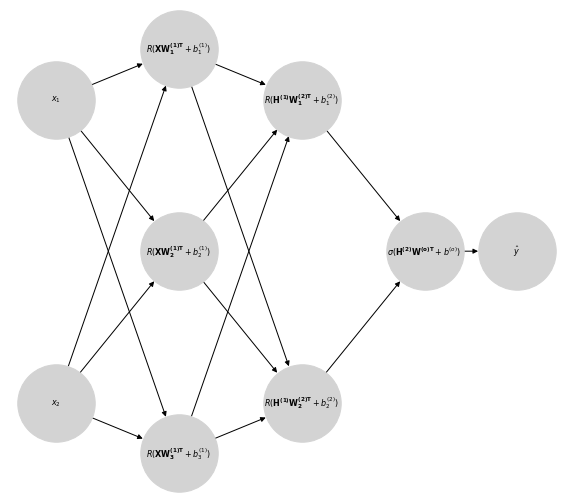

In [125]:
dot = nx.DiGraph()
dot.add_node("A",pos=(0, 0))
dot.add_node("x1",pos=(-1, 1./4))
dot.add_node("x2",pos=(-1, -1./4))
dot.add_node("h11",pos=(-2./3, 1./3))
dot.add_node("h12",pos=(-2./3, 0))
dot.add_node("h13",pos=(-2./3, -1./3))
dot.add_node("h21",pos=(-1./3, 1./4))
dot.add_node("h22",pos=(-1./3, -1./4))
dot.add_node("y",pos=(1./4, 0))
dot.add_edge("x1", "h11")
dot.add_edge("x2", "h11")
dot.add_edge("x1", "h12")
dot.add_edge("x2", "h12")
dot.add_edge("x1", "h13")
dot.add_edge("x2", "h13")
dot.add_edge("h11", "h21")
dot.add_edge("h12", "h21")
dot.add_edge("h13", "h21")
dot.add_edge("h11", "h22")
dot.add_edge("h12", "h22")
dot.add_edge("h13", "h22")
dot.add_edge("h21", "A")
dot.add_edge("h22", "A")
dot.add_edge("A", "y")

pos=nx.get_node_attributes(dot, 'pos')

plt.figure(figsize=(10,9))

nx.draw_networkx_labels(dot, pos, {"A":r"$\sigma(\mathbf{H^{(2)}W^{(o)T}}+b^{(o)})$",
                                   "h11":r"$R(\mathbf{XW^{(1)T}_{1}}+b^{(1)}_{1})$",
                                   "h12":r"$R(\mathbf{XW^{(1)T}_{2}}+b^{(1)}_{2})$",
                                   "h13":r"$R(\mathbf{XW^{(1)T}_{3}}+b^{(1)}_{3})$",
                                   "h21":r"$R(\mathbf{H^{(1)}W^{(2)T}_{1}}+b^{(2)}_{1})$",
                                   "h22":r"$R(\mathbf{H^{(1)}W^{(2)T}_{2}}+b^{(2)}_{2})$",
                                   "x1":r"$x_1$","x2":r"$x_2$",
                                   "y":r"$\hat{y}$"},font_size=8)

nx.draw(dot, pos, node_size=6000, node_color='lightgrey')

plt.show()

As an exercise, write down the dimensions of the different matrices involved.

We have 2 hidden layers that collapse into the final output layer as a single scalar. This network could be used for scalar  regression or binary classification. If we needed more classes in our model the outpuy layer could have more than a single neuron: a vector rather than a scalar.

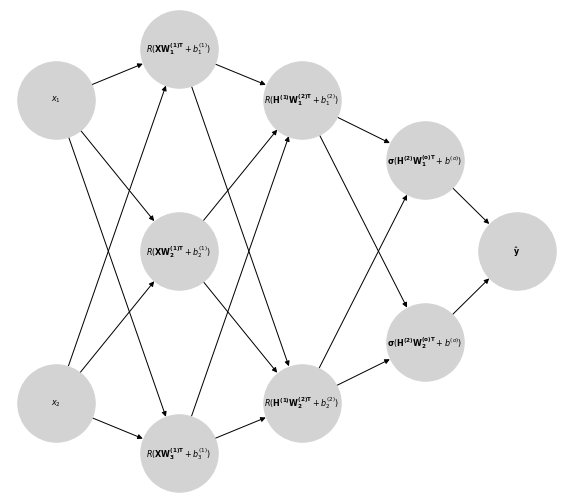

In [126]:
dot = nx.DiGraph()
dot.add_node("A1", pos=(0, 0.15))
dot.add_node("A2", pos=(0, -0.15))
dot.add_node("x1", pos=(-1, 1./4))
dot.add_node("x2", pos=(-1, -1./4))
dot.add_node("h11", pos=(-2./3, 1./3))
dot.add_node("h12", pos=(-2./3, 0))
dot.add_node("h13", pos=(-2./3, -1./3))
dot.add_node("h21", pos=(-1./3, 1./4))
dot.add_node("h22", pos=(-1./3, -1./4))
dot.add_node("y", pos=(1./4, 0))
dot.add_edge("x1", "h11")
dot.add_edge("x2", "h11")
dot.add_edge("x1", "h12")
dot.add_edge("x2", "h12")
dot.add_edge("x1", "h13")
dot.add_edge("x2", "h13")
dot.add_edge("h11", "h21")
dot.add_edge("h12", "h21")
dot.add_edge("h13", "h21")
dot.add_edge("h11", "h22")
dot.add_edge("h12", "h22")
dot.add_edge("h13", "h22")
dot.add_edge("h21", "A1")
dot.add_edge("h22", "A1")
dot.add_edge("h21", "A2")
dot.add_edge("h22", "A2")
dot.add_edge("A1", "y")
dot.add_edge("A2", "y")

pos = nx.get_node_attributes(dot, 'pos')

plt.figure(figsize=(10, 9))

nx.draw_networkx_labels(dot, pos, {"A1":r"$\mathbf{\sigma}(\mathbf{H^{(2)}W^{(o)T}_{1}}+b^{(o)})$",
                                   "A2":r"$\mathbf{\sigma}(\mathbf{H^{(2)}W^{(o)T}_{2}}+b^{(o)})$",
                                   "h11":r"$R(\mathbf{XW^{(1)T}_{1}}+b^{(1)}_{1})$",
                                   "h12":r"$R(\mathbf{XW^{(1)T}_{2}}+b^{(1)}_{2})$",
                                   "h13":r"$R(\mathbf{XW^{(1)T}_{3}}+b^{(1)}_{3})$",
                                   "h21":r"$R(\mathbf{H^{(1)}W^{(2)T}_{1}}+b^{(2)}_{1})$",
                                   "h22":r"$R(\mathbf{H^{(1)}W^{(2)T}_{2}}+b^{(2)}_{2})$",
                                   "x1":r"$x_1$","x2":r"$x_2$",
                                   "y":r"$\mathbf{\hat{y}}$"},
                        font_size=8)

nx.draw(dot, pos, node_size=6000, node_color='lightgrey')

plt.show()

Notice how now $\bf{\sigma}$ is in bold (indicating it is not a sigmoid anymore, but a softmax function which generalizes the sigmoid when there are more than 2 classes). As a result, the output $\mathbf{\hat{y}}$ is a vector now.

The cool thing about writing (almost) all of the network's operations through matrix mutliplication and linear algebra is that we can parallelize the calculations over many samples at a time. So far we were doing all those calculations for only 1 data point, but if we were to do it simultaneously for all our data points then:

- $\mathbf{X}$ is a matrix of shape $(N,d)$, where $N$ is the number of data points and $d$ the number of features describing your data points.
- The sizes of the hidden layers don't change.
- The output layer now spits out an $(N,C)$ matrix, where $C$ is, again, the number of classes.

## Writting a custom deep feedforward network for multiclass problems (blocks) <a class="anchor" id="blocks"></a>

Maybe you noticed already, but from a layer to another we often do the same thing : linear transformation followed by an activation fuction. So we could define this operation block once and for all and just copy-paste according to the network architecture we want to work with. This implementation strategy is a bit of an overkill for the very simple architecture we are seeing right now, but soon enough you will see why defining blocks is efficient (e.g. in a [ResNet](https://en.wikipedia.org/wiki/Residual_neural_network) we have convolution + batch + activation + convolution + batch + activation + convolution + batch + skip + activation).

#### Creation of the architecture of the deep feedforward network

In [127]:
# Pytorch module for the block
class Feedforward_block(torch.nn.Module):
    def __init__(self, input_size, hidden_size):
        super(Feedforward_block, self).__init__()
        self.input_size = input_size
        self.hidden_size  = hidden_size
        self.fc = torch.nn.Linear(self.input_size, self.hidden_size)
        torch.nn.init.xavier_normal_(self.fc.weight, 
                                     gain=torch.nn.init.calculate_gain('leaky_relu'))
        self.relu = torch.nn.LeakyReLU(0.1)
        
    def forward(self,x):
        hidden = self.fc(x)
        relu = self.relu(hidden)
        return relu

# Pytorch module for the deep net using the blocks
class Feedforward_deeper(torch.nn.Module):
    def __init__(self, Feedforward_block, archi, number_classes):
        super(Feedforward_deeper, self).__init__()
        self.archi = archi
        self.number_classes = number_classes
        self.made_block = self._make_block(archi)
        self.output_size = archi[-1][-1]
        self.fc_out = torch.nn.Linear(self.output_size, self.number_classes)
        
    def forward(self, x):
        x = self.made_block(x)
        output = self.fc_out(x)
        return output
    
    def _make_block(self,archi):
        layers=[]
        for i in range(len(archi)):
            layers.append(Feedforward_block(archi[i][0], archi[i][1]))  # Here the blocks are concatenated
        return torch.nn.Sequential(*layers)

#### Creating, setting up and visualizing the multiclass dataset for a more complex data set.

In [128]:
np.random.seed(10815657)

mock_data_3 = []
centers_3 = np.array([[0,0], [0,1], [1,0], [1,1], [0.5,0.5]])
for v in range(len(centers_3)):
    for i in range(100):
        mock_data_3.append(np.random.randn(2) * 0.05 + centers_3[v])
    if v == 4:
        for i in range(100):
            mock_data_3.append(np.random.randn(2) * 0.05 + centers_3[v]) 

In [129]:
dico_not_separable_3 = {i:1 if int(i / 100) == 0 or int(i / 100) == 3 else 0 for i in range(len(mock_data_3) - 100)}
dico_not_separable_3.update({i:2 for i in range(400, 600)})

In [130]:
dico_color_3={0:'blue', 1:'red', 2:'green'}

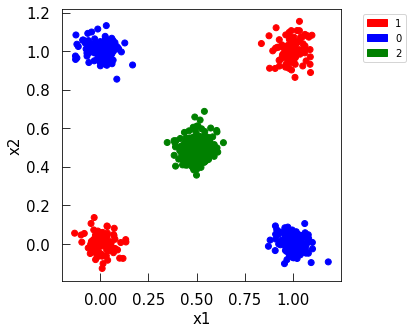

In [131]:
red_patch = mpatches.Patch(color='red', label='1')
blue_patch = mpatches.Patch(color='blue', label='0')
green_patch = mpatches.Patch(color='green', label='2')
list_patches = [red_patch, blue_patch, green_patch]

plt.scatter([p[0] for p in mock_data_3],
            [p[1] for p in mock_data_3],
            c=[dico_color_3[dico_not_separable_3[i]] for i in range(len(mock_data_3))])

plt.legend(handles=list_patches, fontsize=10, bbox_to_anchor=(0.75, 0.5, 0.5, 0.5))
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()

In [132]:
X_not_separable_3_df = pd.DataFrame(np.array(mock_data_3), columns=['x1', 'x2'])
X_not_separable_3_df['classe'] = [dico_not_separable_3[i] for i in range(len(mock_data_3))]
X_not_separable_3_df = shuffle(X_not_separable_3_df, random_state=42)
X_not_separable_3_df.reset_index(inplace=True)
X_not_separable_3_df.head()

index        x1        x2  classe
0    110  0.009914  0.938632       0
1    419  0.489183  0.438010       2
2    565  0.478972  0.493297       2
3     77  0.006144 -0.061286       1
4    181 -0.053500  1.020942       0

In [133]:
X_not_separable_3_df['classe'].value_counts()

2    200
1    200
0    200
Name: classe, dtype: int64

#### Setting up the data (for compatibility with network training)

Pytorch neural net classes work with pytorch tensor object, so you have to define your data this way. Those objects have have different characteristics to numpy arrays, such as the possibility to carry gradient.

In [134]:
# Train/test/validation split
X_train_val_3_df, X_test_3_df = train_test_split(X_not_separable_3_df,
                                                 random_state=0,
                                                 stratify=X_not_separable_3_df['classe'],
                                                 test_size=0.1)

X_train_3_df, X_val_3_df = train_test_split(X_train_val_3_df,
                                            random_state=0,
                                            stratify=X_train_val_3_df['classe'],
                                            test_size=0.1)

x_train_3 = torch.FloatTensor(np.array(X_train_3_df[['x1', 'x2']]))
x_val_3 = torch.FloatTensor(np.array(X_val_3_df[['x1', 'x2']]))

y_train_3 = torch.LongTensor(np.array(X_train_3_df['classe']))
y_val_3 = torch.LongTensor(np.array(X_val_3_df['classe']))

In [135]:
#archi=((2, 4),(4,3),(3,3))
archi=((2, 4), (4,4))

In [136]:
print('Summary of the architecture chosen for our model')
print(summary(Feedforward_deeper(Feedforward_block, archi, 3), torch.zeros((1, 2))))

Summary of the architecture chosen for our model
---------------------------------------------------------------------------
          Layer (type)        Output Shape         Param #     Tr. Param #
   Feedforward_block-1              [1, 4]              12              12
   Feedforward_block-2              [1, 4]              20              20
              Linear-3              [1, 3]              15              15
Total params: 47
Trainable params: 47
Non-trainable params: 0
---------------------------------------------------------------------------


#### Defining a function for training the network 

We will set different loss function and optimizer and visualize the evolution of the training and validation losses throughout the epochs.

In [137]:
def training_overview_multi_classes(model, epochs, x_train_3, y_train_3, x_val_3, y_val_3):
    loss_fn = torch.nn.CrossEntropyLoss()  # The only difference from before is that it is a multi-class loss function
    optimizer = torch.optim.SGD(model.parameters(), lr = 0.1,momentum = 0.9)
    keep_loss=[]
    keep_loss_val=[]
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        
        # Forward pass
        output_train = model(x_train_3)
        
        # Compute Loss
        loss = loss_fn(output_train, y_train_3)
        
        keep_loss.append(loss.detach())
    
        # Backward pass
        loss.backward()
        optimizer.step()
        
        model.eval()
        with torch.no_grad():
            output_val = model(x_val_3)
            loss_val = loss_fn(output_val, y_val_3)
            keep_loss_val.append(loss_val.detach())
        
        if epoch % 100 == 0:
            print('Epoch {}: train loss: {} validation loss: {}'.format(epoch, loss.item(), loss_val.item()))
        if epoch == epochs - 1:
            print('Epoch {}: train loss: {} validation loss: {}'.format(epoch, loss.item(), loss_val.item()))

    plt.plot(np.arange(epochs), keep_loss, 'r', label='training set')
    plt.plot(np.arange(epochs), keep_loss_val, 'b', label='validation set')
    
    plt.xlabel('Epochs')
    plt.ylabel('Cross entropy loss')
    plt.legend(loc='best')
    plt.show()

#### Actually creating the network and training it on the dataset

Epoch 0: train loss: 1.0965359210968018 validation loss: 1.1012345552444458
Epoch 100: train loss: 0.17855757474899292 validation loss: 0.17624245584011078
Epoch 200: train loss: 0.01537499763071537 validation loss: 0.015394735150039196
Epoch 300: train loss: 0.007182840257883072 validation loss: 0.007064391393214464
Epoch 400: train loss: 0.004514412954449654 validation loss: 0.004383169114589691
Epoch 500: train loss: 0.0032373813446611166 validation loss: 0.00309580541215837
Epoch 600: train loss: 0.0024984702467918396 validation loss: 0.00236400100402534
Epoch 700: train loss: 0.0020201995503157377 validation loss: 0.0018908089259639382
Epoch 800: train loss: 0.0016870966646820307 validation loss: 0.0015644064405933022
Epoch 900: train loss: 0.0014429846778512 validation loss: 0.0013281161664053798
Epoch 999: train loss: 0.0012587630189955235 validation loss: 0.0011517268139868975


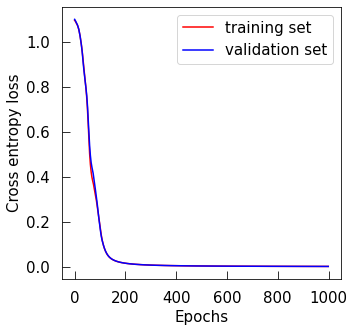

In [138]:
model = Feedforward_deeper(Feedforward_block, archi, 3)
epochs = 1000
training_overview_multi_classes(model, epochs, x_train_3, y_train_3, x_val_3, y_val_3)

#### Evaluation of the network and visualization of its performance on the dataset

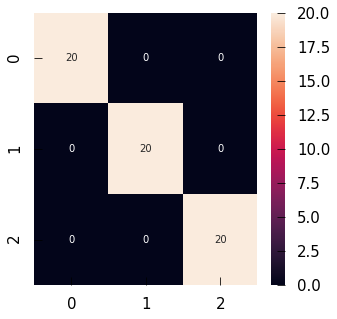

In [139]:
model.eval()

y_pred = model(torch.FloatTensor(np.array(X_test_3_df[['x1', 'x2']])))
sm = torch.nn.Softmax(dim=1)
y_pred = sm(y_pred).detach().numpy()
_,y_pred = torch.max(torch.tensor(y_pred),dim=1)

# Confusion matrix
confusion_mc_c = confusion_matrix(np.array(X_test_3_df['classe']), y_pred)
df_cm_c = pd.DataFrame(confusion_mc_c, index=[0, 1, 2], columns=[0, 1, 2])

plt.figure(figsize=(5, 5))
plt.ylabel('True label')
plt.xlabel('Predicted label')

sns.heatmap(df_cm_c, annot=True, annot_kws={"size": 10})

plt.show()
plt.close()

In [140]:
xx, yy = make_meshgrid(np.array(X_not_separable_3_df['x1']),
                       np.array(X_not_separable_3_df['x2']))

pred = model(torch.FloatTensor(np.c_[xx.ravel(), yy.ravel()]))
sm = torch.nn.Softmax(dim=1)
y_pred = sm(pred).detach().numpy()
y_pred_bim,y_pred_identity = torch.max(torch.tensor(y_pred), dim=1)

Z0 = y_pred[:, 0].reshape(xx.shape)
Z1 = y_pred[:, 1].reshape(xx.shape)
Z2 = y_pred[:, 2].reshape(xx.shape)

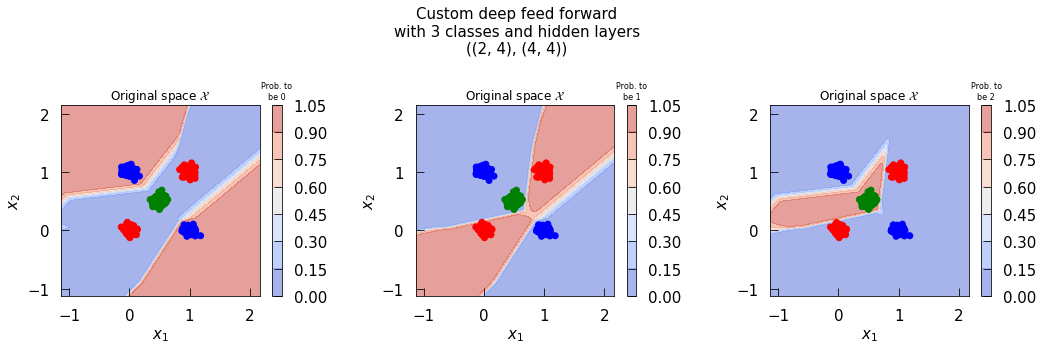

In [141]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle('Custom deep feed forward\nwith 3 classes and hidden layers\n' + str(archi), fontsize=15)

CS0 = ax[0].contourf(xx, yy, Z0, cmap=plt.cm.coolwarm, alpha=0.5)

ax[0].scatter(X_not_separable_3_df['x1'],
              X_not_separable_3_df['x2'],
              c=[dico_color_3[X_not_separable_3_df['classe'].loc[i]] for i in X_not_separable_3_df.index])
ax[0].set_xlabel(r'$x_1$')
ax[0].set_ylabel(r'$x_2$')
ax[0].set_title('Original space $\mathcal{X}$', fontsize=12)

cbar1 = plt.colorbar(CS0, ax=ax[0])
cbar1.ax.set_title('Prob. to\nbe 0', fontsize=8)

CS1 = ax[1].contourf(xx, yy, Z1, cmap=plt.cm.coolwarm, alpha=0.5)

ax[1].scatter(X_not_separable_3_df['x1'],
              X_not_separable_3_df['x2'],
              c=[dico_color_3[X_not_separable_3_df['classe'].loc[i]] for i in X_not_separable_3_df.index])
ax[1].set_xlabel(r'$x_1$')
ax[1].set_ylabel(r'$x_2$')
ax[1].set_title('Original space $\mathcal{X}$', fontsize=12)

cbar2 = plt.colorbar(CS1, ax=ax[1])
cbar2.ax.set_title('Prob. to\nbe 1', fontsize=8)

CS2 = ax[2].contourf(xx, yy, Z2, cmap=plt.cm.coolwarm, alpha=0.5)

ax[2].scatter(X_not_separable_3_df['x1'],
              X_not_separable_3_df['x2'],
              c=[dico_color_3[X_not_separable_3_df['classe'].loc[i]] for i in X_not_separable_3_df.index])
ax[2].set_xlabel(r'$x_1$')
ax[2].set_ylabel(r'$x_2$')
ax[2].set_title('Original space $\mathcal{X}$', fontsize=12)

cbar3 = plt.colorbar(CS2, ax=ax[2])
cbar3.ax.set_title('Prob. to\nbe 2', fontsize=8)

plt.tight_layout()
plt.show()

# Bits and pieces of a deep neural network <a class="anchor" id="bits_pieces"></a>

## A real biological datatset: prediction of subcellular localization from sequences features <a class="anchor" id="dataset"></a>

To start our exploration of deep learning in biology we will use a real dataset, that will follow us throughout the course. Using this dataset we will try to classify the subcellular region where different proteins can be found. Sequences are preprocessed into a protein profile vector, which is a bunch of calculated features at the level of the amino acid that might be relevant for our classification. Without getting into the details of it, those features describe the $N$ terminal part of the proteins, the overall sequence of amino acids, whether or not a signal anchor can be detected and, finally, if some specific amino acid motifs can be detected [(Hoglun et al. 2006)](https://academic.oup.com/bioinformatics/article/22/10/1158/236546?login=true). You can find the datasets here : https://github.com/vanessajurtz/lasagne4bio

In [142]:
data_path = 'Datasets/subcellular/'

X_train_subcell_ = np.load(os.path.join(data_path, 'reduced_train/X_train.npy'))
y_train_subcell_ = np.load(os.path.join(data_path, 'reduced_train/y_train.npy'))

X_val_subcell_ = np.load(os.path.join(data_path, 'reduced_val/X_val.npy'))
y_val_subcell_ = np.load(os.path.join(data_path, 'reduced_val/y_val.npy'))

train_i = np.arange(X_train_subcell_.shape[0])
np.random.seed(42)
np.random.shuffle(train_i)
X_train_subcell = np.array([X_train_subcell_[i] for i in train_i])
y_train_subcell = np.array([y_train_subcell_[i] for i in train_i])

train_i = np.arange(X_val_subcell_.shape[0])
np.random.seed(42)
np.random.shuffle(train_i)
X_val_subcell = np.array([X_val_subcell_[i] for i in train_i])
y_val_subcell = np.array([y_val_subcell_[i] for i in train_i])

In [143]:
print('Sequence size is {0} max. | Number of features is {1}'.format(X_train_subcell.shape[1], X_train_subcell.shape[2]))

Sequence size is 400 max. | Number of features is 20


In [144]:
classes = ['Nucleus',
           'Cytoplasm',
           'Extracellular',
           'Mitochondrion',
           'Cell membrane',
           'ER',
           'Chloroplast',
           'Golgi apparatus',
           'Lysosome',
           'Vacuole']

dico_classes_subcell={i:v for i,v in enumerate(classes)}

for i in dico_classes_subcell.keys():
    print('Target', i, dico_classes_subcell[i])

Target 0 Nucleus
Target 1 Cytoplasm
Target 2 Extracellular
Target 3 Mitochondrion
Target 4 Cell membrane
Target 5 ER
Target 6 Chloroplast
Target 7 Golgi apparatus
Target 8 Lysosome
Target 9 Vacuole


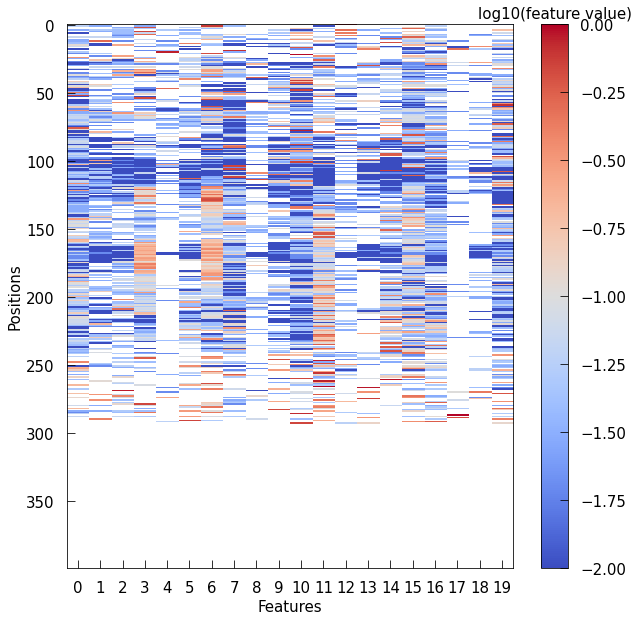

In [145]:
plt.figure(figsize=(10, 10))
plt.imshow(np.log10(X_train_subcell[1]), aspect='auto', cmap=plt.cm.coolwarm, interpolation='nearest')
plt.ylabel('Positions')
plt.xlabel('Features')
plt.xticks(np.arange(20))

cbar = plt.colorbar()
cbar.ax.set_title('log10(feature value)', fontsize=15)

plt.show()

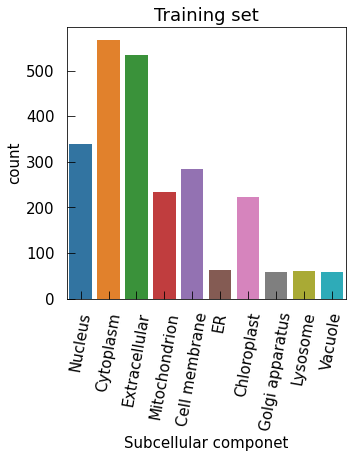

In [146]:
y_train_subcell_df = pd.DataFrame(y_train_subcell, columns=['subcellular'])

ax = sns.countplot(y_train_subcell_df.subcellular, order=np.arange(10))
ax.set_xticklabels(list(dico_classes_subcell.values()), rotation=80);

plt.xlabel("Subcellular componet")
plt.title("Training set")
plt.show()

**BE CAREFULL**: This is an imbalanced data set. Make sure to use the right loss function and score. Let's get right into solving this classification problem. We will explore the bits and pieces of building of our model, as we are going. 

## Forward propagation <a class="anchor" id="forward"></a>

Forward propagation refers to all the sequential steps that information goes through starting from the data (basically the steps we were talking about above, sequential linear kernel, activation, softmax for example) up to decision function, which will decide for example if a point should be qualified as part of group $i$.

### Loss functions <a class="anchor" id="loss"></a>

The loss function defines a measure of distance between your estimated model and the ground-truth. Given its definition, this is a function that you want to minimize. You are already very familiar with many loss functions: negative of the maximum likelihood (cross entropy), hinge loss, mean squared error, deviance, etc..

Cross Entropy Loss: $\min_{w,b}\sum_{i=1}^n \log(\exp(- y_i (X_i^T w + b)) + 1)$
> Logistic regression

Hinge Loss : $\min_{w,b}\sum_{i=1}\max(0, y_i (w^T \phi(X_i) + b))$
> SVM

Sum of squared error Loss: $\min_{w,b}|| X w + b - y||_2^2$
> Ordinary Least Square regression

But you could actually define whatever loss function is usefull to solve your problem. For example in one specific area of deep learning dealing with Generative Adversarial Networks (GANs), one network (the generator) learns to produce data samples well enough to fool another network (the discriminator) which, in turn, learns to differentiate between real and generated data. In this setting the loss function is complicated and made of two parts: one that minimizes the distance between real data and generated data and another which maximizes the distance between the prediction of the discriminator and the generated data.

In [BERT](https://en.wikipedia.org/wiki/BERT_(language_model)), a famous Natural Language Processing (NLP) model, two loss functions are combined for training: one for masked word prediction in a sentence, and another for pairing contiguous sentences. 

Our sequence data set is, as we said before, very class-imbalanced. Therefore, evaluating a model on it using metrics like accuracy is a doomed endeavor. So we will employ [$F_1$-scores](https://en.wikipedia.org/wiki/F-score) (there are other alternatives). Moreover, we will define a weighted loss function so that every class has the same importance when fitting the model (an alternative solution would be to resample the data to end up with balanced classes). If you are not familiar with the different metrics and when to use them, or how to deal with imbalanced data, please take some time to check that.

In [147]:
def training_overview_multi_classes_imbalanced(model, epochs, x_train_3, y_train_3, x_val_3, y_val_3):
    
    # Add weights for imbalanced loss function
    w = compute_class_weight('balanced', np.unique(y_train_3), np.array(y_train_3))
    weights_classes = torch.tensor(w, dtype=torch.float32)
    print('weights_classes', weights_classes)
    
    loss_fn = torch.nn.CrossEntropyLoss(weight=weights_classes)
    
    optimizer = torch.optim.SGD(model.parameters(), lr = 0.1, momentum = 0.8)
    
    keep_loss = []
    keep_loss_val = []
    keep_score = []
    keep_score_val = []
    for epoch in range(epochs):
        
        model.train()
        optimizer.zero_grad()
        
        # Forward pass
        output_train = model(x_train_3)
    
        # Compute Loss
        sm = torch.nn.Softmax(dim=1)
        
        # Compute metric of interest
        # Note the detach : changing it to a no grad tensor
        _, y_pred_train = torch.max(torch.tensor(sm(output_train).detach().numpy().tolist()), dim=1)
        f1_train = metrics.f1_score(y_train_3, y_pred_train, average='weighted')  # f1 score is our evaluation metric
        keep_score.append(f1_train)
        
        # Compute Loss
        loss = loss_fn(output_train, y_train_3)
        keep_loss.append(loss.detach())
        
        # Backward pass
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        
        # Evaluation
        model.eval()
        with torch.no_grad():
            output_val = model(x_val_3)
            sm = torch.nn.Softmax(dim=1)
            _,y_pred_val = torch.max(torch.tensor(sm(output_val).detach().numpy().tolist()), dim=1)
            f1_val = metrics.f1_score(y_val_3, y_pred_val, average='weighted')
            keep_score_val.append(f1_val)
            loss_val = loss_fn(output_val, y_val_3)
            keep_loss_val.append(loss_val.detach())
        
        if epoch % 100 == 0:
            print('Epoch {}: train loss: {} validation loss: {}\n train f1: {} validation f1: {}'.format(epoch, 
                                                                                                         loss.item(),
                                                                                                         loss_val.item(),
                                                                                                         keep_score[-1],
                                                                                                         keep_score_val[-1]))
        if epoch == epochs - 1:
            print('Epoch {}: train loss: {} validation loss: {}\n train f1: {} validation f1: {}'.format(epoch, 
                                                                                                         loss.item(),
                                                                                                         loss_val.item(),
                                                                                                         keep_score[-1],
                                                                                                         keep_score_val[-1]))
            
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    
    ax[0].plot(np.arange(epochs), keep_loss, 'r', label='training set')
    ax[0].plot(np.arange(epochs), keep_loss_val, 'b', label='validation set')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Cross-entropy loss')
    ax[0].legend(loc='best')
    
    ax[1].plot(np.arange(epochs), keep_score, 'r', label='training set')
    ax[1].plot(np.arange(epochs), keep_score_val, 'b', label='validation set')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Weighted f1 score')
    ax[1].legend(loc='best')
    
    plt.tight_layout()
    plt.show()

Here the choice of architecture is somewhat arbitrary, there is no magic formula for that. Your achitecture can be seen as a hyperparameter that you are free to optimize / play with.

*Remark:* The function `CrossEntropyLoss` needs long type rather than float, so this is why we transformed our taget vector to `torch.LongTensor` rather than `torch.Float` as before. 

As you might deduce from the architecture we chose the shape of our data, we will need to flatten the input matrix.

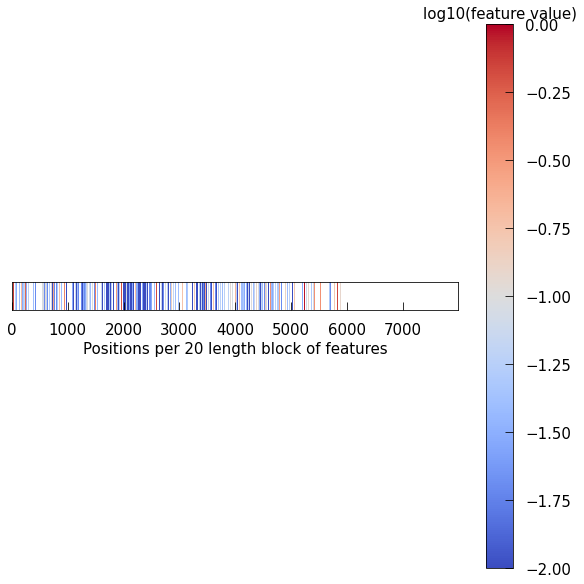

In [148]:
plt.figure(figsize=(10, 10))

plt.imshow(np.log10(X_train_subcell[1].reshape(1, 8000)), aspect=500, cmap=plt.cm.coolwarm, interpolation='nearest')

plt.xlabel('Positions per 20 length block of features')
plt.yticks([])

cbar = plt.colorbar()
cbar.ax.set_title('log10(feature value)', fontsize=15)

plt.show()

weights_classes tensor([0.7169, 0.4273, 0.4529, 1.0399, 0.8502, 3.8460, 1.0817, 4.1068, 4.0383,
        4.1068])
Epoch 0: train loss: 2.306673526763916 validation loss: 2.3019521236419678
 train f1: 0.0559133248563989 validation f1: 0.05582962024965705
Epoch 100: train loss: 0.050082750618457794 validation loss: 1.475031852722168
 train f1: 0.9946407747017243 validation f1: 0.7474477772172825
Epoch 200: train loss: 0.009282205253839493 validation loss: 1.616379737854004
 train f1: 0.9995888008685752 validation f1: 0.7616839637730443
Epoch 299: train loss: 0.004812942817807198 validation loss: 1.6923272609710693
 train f1: 0.9995888008685752 validation f1: 0.7600397079279974


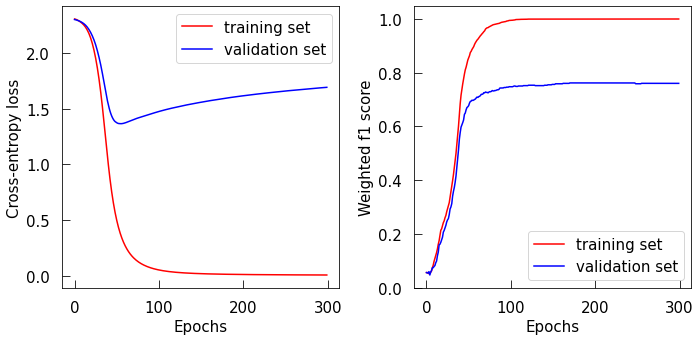

In [149]:
#archi=((8000, 80),(80,10))
archi=((8000, 80), (80, 80))
model = Feedforward_deeper(Feedforward_block, archi, 10)
epochs = 300

X_train_subcell_ready = torch.FloatTensor(np.array([X_train_subcell[i].flatten() for i in range(X_train_subcell.shape[0])]))  # Note the flattening
X_val_subcell_ready = torch.FloatTensor(np.array([X_val_subcell[i].flatten() for i in range(X_val_subcell.shape[0])]))

y_train_subcell_ready = torch.LongTensor(y_train_subcell)
y_val_subcell_ready = torch.LongTensor(y_val_subcell)

training_overview_multi_classes_imbalanced(model, epochs, X_train_subcell_ready, y_train_subcell_ready, X_val_subcell_ready, y_val_subcell_ready)

We have *overfit*: after some epochs, the validation loss starts to increase while the training loss keeps going down. Let's add L2 regularization to fight this.

### Regularization: L2, dropout, early stopping <a class="anchor" id="regularization"></a>

In machine learning we want to produce the best model for future (unseen) predictions, not necessarily the best model for our training dataset. So our loss function and training procedures have to be adapted to compromize for generalization *as well as* good fit on the training set.

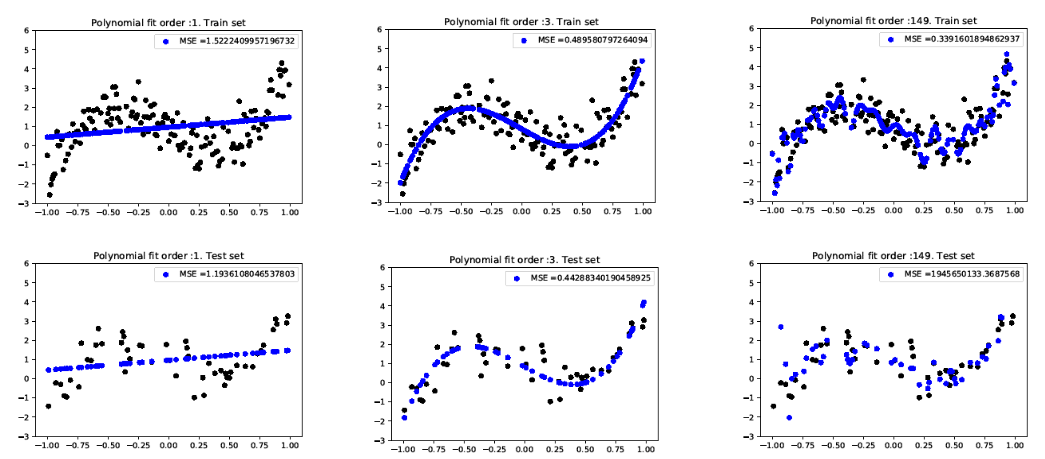

In [150]:
Image('images_intro/OLS.png')

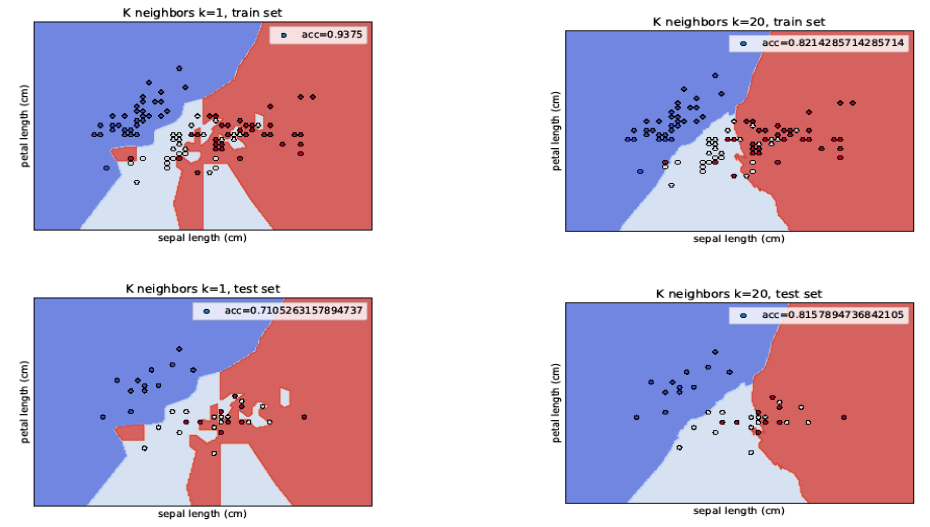

In [151]:
Image('images_intro/knn.png')

If you have taken a Machine Learning courses you might have encountered $L1$-, $L2$- (and [Elastic net](https://en.wikipedia.org/wiki/Elastic_net_regularization)) regularizations, with their hyperparameter $C$ which controls the strength of the regularization. When training a logistic regression classifier, a regularized maximum likelihood loss might look like this, with the regularization term on the left and the log likelihood function on the right.

$L2$ : $\frac{1}{2} \| w \|_2^2 + C \cdot \sum_{i=1}^n \log(\exp(- y_i (X_i^T w + b)) + 1)$

$L1$ : $\|w\|_1 + C \cdot \sum_{i=1}^n \log(\exp(- y_i (X_i^T w + b)) + 1)$

To tune a regularization procedure you need to follow the well known recipe : 

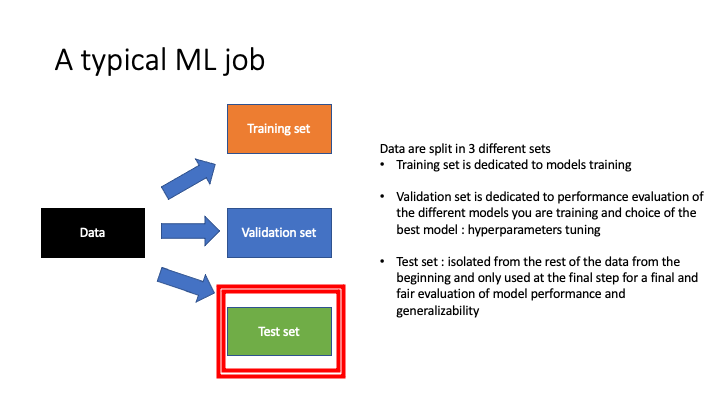

In [152]:
Image('images_intro/Presentation3.png')

In our context, $L1$- and $L2$-regularization are easily implementable and we have full control over the architecture. 

But in Deep Learning one has many other ways to regularize. A really usefull one ``Dropout``. It randomly shuts down a fraction of the nodes within the network at different stages of the training. Those nodes are brought back on before another turn of dropout is initiated. This random turning on and off of neurons mediates the importance that some nodes may acquire from luck alone in inital training steps. However, the utility of dropout is hard to demonstrate on small networks like the ones we are working on. With so few nodes per layer dropout pertubes the training a lot. But you will see that it is very broadly used in real world deep learning applications. See also [Stanford CS 230](https://stanford.edu/~shervine/teaching/cs-230/cheatsheet-deep-learning-tips-and-tricks#).

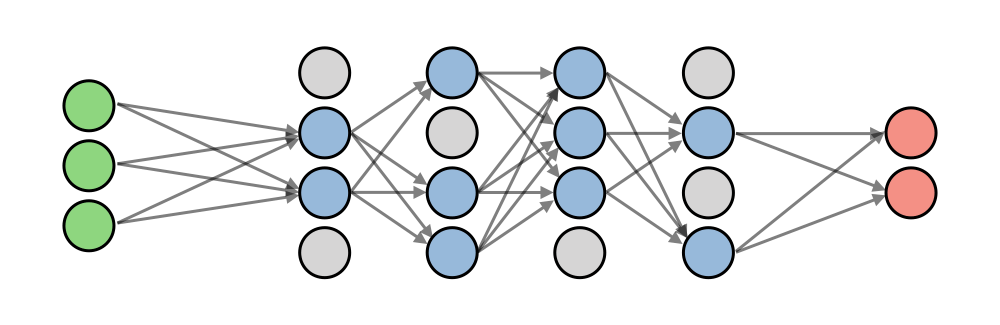

In [153]:
Image('images_intro/dropout-ltr.png')

``Early stopping`` can also be a good way to regularize your model. Early stopping relies on the deep learning practicioner to stop the training whenever the loss or the evalutaion metric of the test set reaches a certain value, does not improve anymore or starts overfitting. In our most recent example, we could have (early) stopped around epoch 60 instead of keep training. 

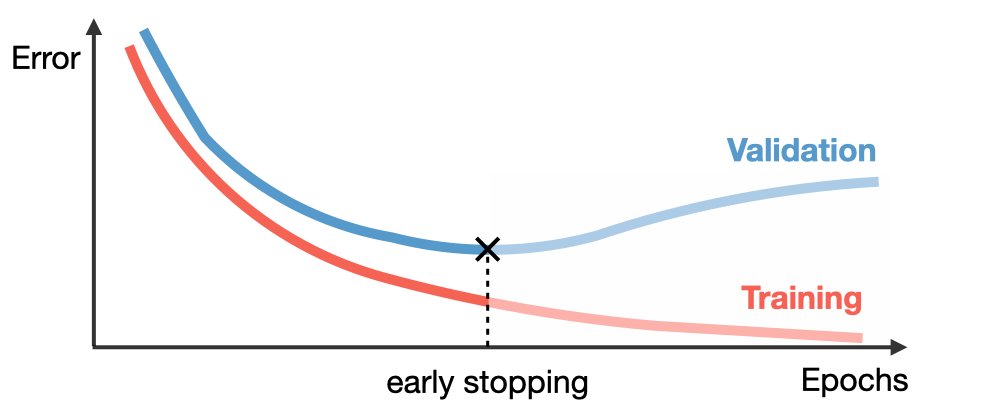

In [154]:
Image('images_intro/early-stopping-en.png')

#### L2 regularization

In [155]:
def training_overview_multi_classes_imbalanced_wd(model, epochs, x_train_3, y_train_3, x_val_3, y_val_3, wd):
    
    w = compute_class_weight('balanced', np.unique(y_train_3), np.array(y_train_3))
    weights_classes = torch.tensor(w,dtype=torch.float32)
    print('weights_classes',weights_classes)
    
    loss_fn = torch.nn.CrossEntropyLoss(weight=weights_classes)
    
    optimizer = torch.optim.SGD(model.parameters(), lr = 0.1,momentum = 0.8,weight_decay=wd)#adding regularization
    
    keep_loss=[]
    keep_loss_val=[]
    keep_score=[]
    keep_score_val=[]
    for epoch in range(epochs):
        
        model.train()
        optimizer.zero_grad()
        
        # Forward pass
        output_train = model(x_train_3)    
       
        # Compute Score
        sm = torch.nn.Softmax(dim=1)
        _, y_pred_train = torch.max(torch.tensor(sm(output_train).detach().numpy().tolist()), dim=1)
        f1_train = metrics.f1_score(y_train_3, y_pred_train, average='weighted')
        keep_score.append(f1_train)
        
        # Compute Loss
        loss = loss_fn(output_train, y_train_3)
        keep_loss.append(loss.detach())
        
        # Backward pass
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        
        # Evaluation
        model.eval()
        with torch.no_grad():
            output_val = model(x_val_3)
            sm = torch.nn.Softmax(dim=1)
            _, y_pred_val = torch.max(torch.tensor(sm(output_val).detach().numpy().tolist()), dim=1)
            f1_val = metrics.f1_score(y_val_3, y_pred_val, average='weighted')
            keep_score_val.append(f1_val)
            loss_val = loss_fn(output_val, y_val_3)
            keep_loss_val.append(loss_val.detach())
        
        if epoch % 100 == 0:
            print('Epoch {}: train loss: {} validation loss: {}\n train f1: {} validation f1: {}'.format(epoch, 
                                                                                                         loss.item(),
                                                                                                         loss_val.item(),
                                                                                                         keep_score[-1],
                                                                                                         keep_score_val[-1]))
        if epoch == epochs - 1:
            print('Epoch {}: train loss: {} validation loss: {}\n train f1: {} validation f1: {}'.format(epoch,
                                                                                                         loss.item(),
                                                                                                         loss_val.item(),
                                                                                                         keep_score[-1],
                                                                                                         keep_score_val[-1]))
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].plot(np.arange(epochs), keep_loss, 'r', label='training set')
    ax[0].plot(np.arange(epochs), keep_loss_val, 'b', label='validation set')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Cross entropy loss')
    ax[0].legend(loc='best')
    
    ax[1].plot(np.arange(epochs), keep_score, 'r', label='training set')
    ax[1].plot(np.arange(epochs), keep_score_val, 'b', label='validation set')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Weighted f1 score')
    ax[1].legend(loc='best')
    
    plt.tight_layout()
    plt.show()

weights_classes tensor([0.7169, 0.4273, 0.4529, 1.0399, 0.8502, 3.8460, 1.0817, 4.1068, 4.0383,
        4.1068])
Epoch 0: train loss: 2.309705972671509 validation loss: 2.3088698387145996
 train f1: 0.12002103958359699 validation f1: 0.09786050490176844
Epoch 100: train loss: 0.1651640236377716 validation loss: 1.2310582399368286
 train f1: 0.9724541573569998 validation f1: 0.740471190636518
Epoch 200: train loss: 0.09235748648643494 validation loss: 1.1363822221755981
 train f1: 0.9987752240750315 validation f1: 0.7689272019886421
Epoch 299: train loss: 0.08495872467756271 validation loss: 1.1174396276474
 train f1: 0.9991805698652276 validation f1: 0.777257886181423


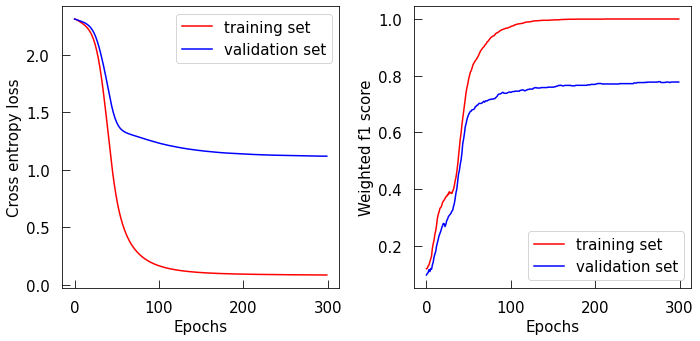

In [156]:
archi = ((8000, 80), (80, 80))
model = Feedforward_deeper(Feedforward_block, archi, 10)
epochs = 300

training_overview_multi_classes_imbalanced_wd(model, 
                                              epochs,
                                              X_train_subcell_ready,
                                              y_train_subcell_ready,
                                              X_val_subcell_ready,
                                              y_val_subcell_ready,
                                              wd=0.01)

#### Drop out

In [157]:
class Feedforward_block_drop(torch.nn.Module):
    def __init__(self, input_size, hidden_size, dro):
        super(Feedforward_block_drop, self).__init__()
        self.input_size = input_size
        self.dro = dro
        self.hidden_size  = hidden_size
        self.fc = torch.nn.Linear(self.input_size, self.hidden_size)
        torch.nn.init.xavier_normal_(self.fc.weight, gain=torch.nn.init.calculate_gain('leaky_relu'))
        self.relu = torch.nn.LeakyReLU(0.1)
        self.drop = torch.nn.Dropout(self.dro)
        
    def forward(self,x):
        hidden = self.fc(x)
        hidden = self.drop(hidden)
        relu = self.relu(hidden)
        return relu
        
class Feedforward_deeper_drop(torch.nn.Module):
    def __init__(self, Feedforward_block_drop, archi, number_classes,dro):
        super(Feedforward_deeper_drop, self).__init__()
        self.archi = archi
        self.dro = dro
        self.number_classes = number_classes
        self.made_block = self._make_block(archi)
        self.output_size = archi[-1][-1]
        self.fc_out = torch.nn.Linear(self.output_size, self.number_classes)
        self.drop = torch.nn.Dropout(self.dro)
       
    
    def forward(self, x):
        x = self.made_block(x)
        output = self.fc_out(x)
        output = self.drop(output)
        return output
    
    def _make_block(self, archi):
        layers = []
        for i in range(len(archi)):
            layers.append(Feedforward_block_drop(archi[i][0], archi[i][1], self.dro))
        return torch.nn.Sequential(*layers)

weights_classes tensor([0.7169, 0.4273, 0.4529, 1.0399, 0.8502, 3.8460, 1.0817, 4.1068, 4.0383,
        4.1068])
Epoch 0: train loss: 2.3096811771392822 validation loss: 2.3196237087249756
 train f1: 0.10452390719053208 validation f1: 0.07497948258651808
Epoch 100: train loss: 0.35819149017333984 validation loss: 1.223679542541504
 train f1: 0.8897912601783128 validation f1: 0.757045693564143
Epoch 200: train loss: 0.2117765098810196 validation loss: 1.1609619855880737
 train f1: 0.9601705248800161 validation f1: 0.7593121937977405
Epoch 300: train loss: 0.2070501297712326 validation loss: 1.1466166973114014
 train f1: 0.959934207712639 validation f1: 0.7653007404791458
Epoch 400: train loss: 0.19935640692710876 validation loss: 1.1403392553329468
 train f1: 0.9588233751909025 validation f1: 0.7655741375442374
Epoch 499: train loss: 0.21053442358970642 validation loss: 1.1384001970291138
 train f1: 0.9637767262806074 validation f1: 0.7723816314800944


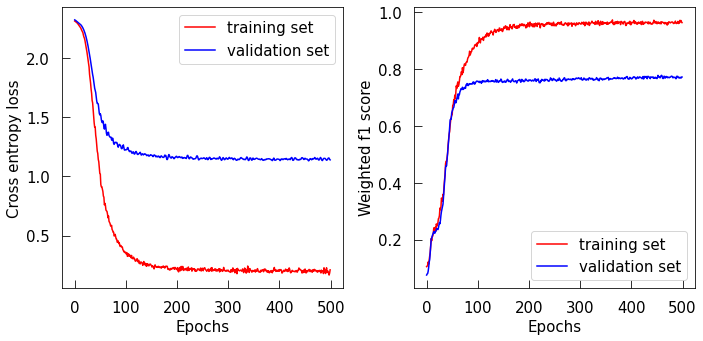

In [158]:
archi = ((8000, 80), (80, 80))
model = Feedforward_deeper_drop(Feedforward_block_drop,archi, 10, 0.1)
epochs = 500

training_overview_multi_classes_imbalanced_wd(model,
                                              epochs,
                                              X_train_subcell_ready,
                                              y_train_subcell_ready,
                                              X_val_subcell_ready,
                                              y_val_subcell_ready,
                                              wd=0.01)

#### Early stopping

In [159]:
def training_overview_multi_classes_imbalanced_wd_early(model, epochs, x_train_3, y_train_3, x_val_3, y_val_3, wd):
    
    w = compute_class_weight('balanced', np.unique(y_train_3), np.array(y_train_3))
    weights_classes = torch.tensor(w, dtype=torch.float32)
    print('weights_classes', weights_classes)
    
    loss_fn = torch.nn.CrossEntropyLoss(weight=weights_classes)
    optimizer = torch.optim.SGD(model.parameters(), lr = 0.1,momentum = 0.8, weight_decay=wd)
    
    keep_loss=[]
    keep_loss_val=[]
    keep_score=[]
    keep_score_val=[]
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        
        # Forward pass
        output_train = model(x_train_3)   
       
        # Compute Score
        sm = torch.nn.Softmax(dim=1)
        _, y_pred_train = torch.max(torch.tensor(sm(output_train).detach().numpy().tolist()), dim=1)
        f1_train = metrics.f1_score(y_train_3, y_pred_train, average='weighted')
        keep_score.append(f1_train)
        
        # Compute Loss
        loss = loss_fn(output_train, y_train_3)
        keep_loss.append(loss.detach())
        
        # Backward pass
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        
        # Evaluation
        model.eval()
        with torch.no_grad():
            output_val = model(x_val_3)
            sm = torch.nn.Softmax(dim=1)
            _, y_pred_val = torch.max(torch.tensor(sm(output_val).detach().numpy().tolist()), dim=1)
            f1_val = metrics.f1_score(y_val_3, y_pred_val, average='weighted')
            keep_score_val.append(f1_val)
            loss_val = loss_fn(output_val, y_val_3)
            keep_loss_val.append(loss_val.detach())
        
        if epoch % 100 == 0:
            print('Epoch {}: train loss: {} validation loss: {}\n train f1: {} validation f1: {}'.format(epoch, 
                                                                                                         loss.item(),
                                                                                                         loss_val.item(),
                                                                                                         keep_score[-1],
                                                                                                         keep_score_val[-1]))
        if epoch==epochs - 1:
            print('Epoch {}: train loss: {} validation loss: {}\n train f1: {} validation f1: {}'.format(epoch, 
                                                                                                         loss.item(),
                                                                                                         loss_val.item(),
                                                                                                         keep_score[-1],
                                                                                                         keep_score_val[-1]))
        
        # Early stopping
        if (epoch > 100) and (keep_score_val[-1] < keep_score_val[-2] - 2 * np.std(keep_score_val[-50:-1])):
            print(epoch, keep_score_val[-1], keep_score_val[-2] - np.std(keep_score_val[-100:-1]))
            break
            
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    
    ax[0].plot(np.arange(len(keep_loss)), keep_loss, 'r', label='training set')
    ax[0].plot(np.arange(len(keep_loss)), keep_loss_val, 'b', label='validation set')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Cross entropy loss')
    ax[0].legend(loc='best')
    
    ax[1].plot(np.arange(len(keep_loss)), keep_score, 'r', label='training set')
    ax[1].plot(np.arange(len(keep_loss)), keep_score_val, 'b', label='validation set')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Weighted f1 score')
    ax[1].legend(loc='best')
    
    plt.tight_layout()
    plt.show()

weights_classes tensor([0.7169, 0.4273, 0.4529, 1.0399, 0.8502, 3.8460, 1.0817, 4.1068, 4.0383,
        4.1068])
Epoch 0: train loss: 2.3118293285369873 validation loss: 2.309680700302124
 train f1: 0.04791156663002922 validation f1: 0.029832835066739647
Epoch 100: train loss: 0.3790273666381836 validation loss: 1.2053349018096924
 train f1: 0.8894730536022071 validation f1: 0.7458416143385448
Epoch 200: train loss: 0.23369523882865906 validation loss: 1.126944899559021
 train f1: 0.9518840952859122 validation f1: 0.7655823107245837
294 0.7708373803337206 0.7744160067667925


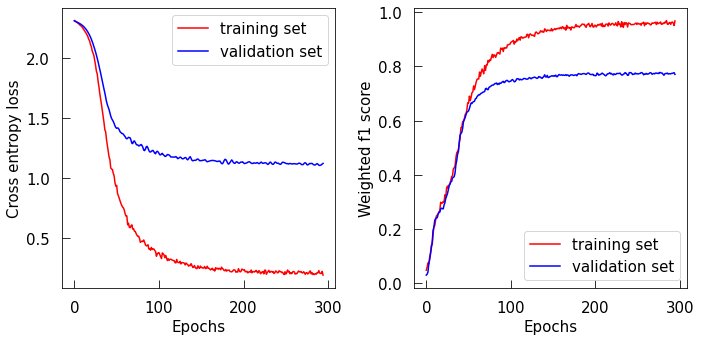

In [160]:
archi = ((8000, 80), (80, 80))
model = Feedforward_deeper_drop(Feedforward_block_drop, archi, 10, 0.1)
epochs = 500

training_overview_multi_classes_imbalanced_wd_early(model,
                                                    epochs,
                                                    X_train_subcell_ready,
                                                    y_train_subcell_ready,
                                                    X_val_subcell_ready,
                                                    y_val_subcell_ready,
                                                    wd=0.01)

## Backpropagation  <a class="anchor" id="back_propagation"></a>

So far we have only described the neural network information flow in one direction. Neural nets learns by feeding back the results at the output sequentially to each previous layer. This "backpropagation" is directly linked to a property in differential calculus: the chain rule. 

The increment used to update the network weights (a.k.a. "learning"),  is related to the gradient (a vector of derivatives) of the loss function at the output. Let's learn how efficient gradient calculation can be implemented, so that calculating so many gradients becames feasible possible, by going back to this simple example:

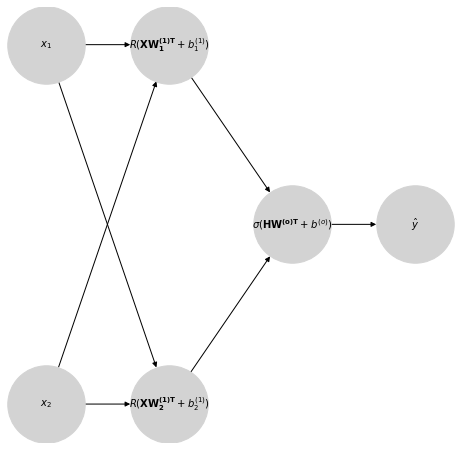

In [161]:
dot = nx.DiGraph()
dot.add_node("A", pos=(0, 0))
dot.add_node("x1", pos=(-1./2, 1./3))
dot.add_node("x2", pos=(-1./2, -1./3))
dot.add_node("h1", pos=(-1./4, 1./3))
dot.add_node("h2", pos=(-1./4, -1./3))
dot.add_node("y", pos=(1./4, 0))
dot.add_edge("x1", "h1")
dot.add_edge("x2", "h1")
dot.add_edge("x1", "h2")
dot.add_edge("x2", "h2")
dot.add_edge("h1", "A")
dot.add_edge("h2", "A")
dot.add_edge("A", "y")

pos = nx.get_node_attributes(dot, 'pos')

plt.figure(figsize=(8, 8))

nx.draw_networkx_labels(dot, pos, {"A":r"$\sigma(\mathbf{HW^{(o)T}}+b^{(o)})$",
                                   "h1":r"$R(\mathbf{XW^{(1)T}_{1}}+b^{(1)}_{1})$",
                                   "h2":r"$R(\mathbf{XW^{(1)T}_{2}}+b^{(1)}_{2})$",
                                   "x1":r"$x_1$","x2":r"$x_2$",
                                   "y":r"$\hat{y}$"},
                        font_size=10)

nx.draw(dot, pos, node_size=6000, node_color='lightgrey')

plt.show()

Recall that you can see the network as a composition of functions : $\hat{y} = \sigma \circ \mathcal{W^{(o)}}\circ R \circ \mathcal{W^{(1)}}$.

The loss function $L(y,\hat{y})$ (or if we expand all the compositions : $L(y, \mathbf{W^{(o)}},\mathbf{W^{(1)}_2},\mathbf{W^{(1)}_1},b^{(o)},b^{(1)}_{1},b^{(1)}_{2},x_1,x_2,)$) is a function of all the weights that we use to calculate $\hat{y}$ and the ground truth $y$. We would like this function to be minimal as it is a quantity that measures how close our predictions are to the ground truth. Using the same notations as before for composition, we are now interested in finding the minimum of the following function $L \circ \sigma \circ \mathcal{W^{(o)}}\circ R \circ \mathcal{W^{(1)}}$. That is, we would like to find a set of $\{\mathbf{W^{(o)}},\mathbf{W^{(1)}_2},\mathbf{W^{(1)}_1},b^{(o)},b^{(1)}_{1},b^{(1)}_{2}\}$ so that $L$ is minimum.

A natural way of doing so would be to update those $\mathbf{W}$ toward the opposite direction of the gradient of $L$ (direction of steepest descent). And so, for our simple example, we would have at iteration $i$ the update:

$$
w_{1,i}^{(o)} = w_{1,i-1}^{(o)}-\eta\frac{\partial L}{\partial w_{1}^{(o)}}\Bigr|_{\sigma(\mathbf{HW_{i-1}^{(o)T}}+b^{(o)})},
$$

where, in Leibniz notation, 

$$
\frac{\partial L}{\partial w_{1}^{(o)}}\Bigr|_{\sigma(\mathbf{HW_{i-1}^{(o)T}}+b^{(o)})}=\frac{\partial L}{\partial \sigma}\Bigr|_{\sigma(\mathbf{HW_{i-1}^{(o)T}}+b^{(o)})}\frac{\partial \sigma}{\partial \mathcal{W^{(o)}}}\Bigr|_{\mathbf{HW_{i-1}^{(o)T}}+b^{(o)}}\frac{\partial \mathcal{W^{(o)}}}{\partial w_{1}^{(o)}}\Bigr|_{\mathbf{W_{i-1}^{(o)}},b^{(o)},\mathbf{H}}.
$$

Using vector notation for the weights,

$$
\begin{align}
\mathbf{w_{i}^{(o)}} & = \mathbf{w_{i-1}^{(o)}}-\eta\overrightarrow{(\frac{\partial L }{\partial w_{1,i-1}^{(o)}}\Bigr|_{\sigma(\mathbf{HW_{i-1}^{(o)T}}+b^{(o)})},\frac{\partial L }{\partial w_{2,i-1}^{(o)}}\Bigr|_{\sigma(\mathbf{HW_{i-1}^{(o)T}}+b^{(o)})})} \\
& =\mathbf{w_{i-1}^{(o)}}-\eta\nabla L(\sigma(\mathbf{HW_{i-1}^{(o)T}}+b^{(o)})) 
\end{align}
$$

Now let's update the weights that are closer to the beginning of the network : 

$$
w_{1,1,i}^{(1)} = w_{1,1,i-1}^{(1)}-\eta\frac{\partial L}{\partial w_{1,1}^{(1)}},
$$

where
$$
\frac{\partial L}{\partial w_{1,1}^{(1)}}=\frac{\partial L}{\partial \sigma}\frac{\partial \sigma}{\partial \mathcal{W^{(o)}}}\frac{\partial \mathcal{W^{(o)}}}{\partial R}\frac{\partial R}{\partial  \mathcal{W^{(1)}}}\frac{\partial \mathcal{W^{(1)}}}{\partial  w_{1,1}^{(1)}}.
$$

You can see that if we were to start updating $w_{1,1,i}^{(1)}$ we would have to calculate and evaluate 5 derivatives. We would also need to store them, as they will be reused to calculate subsenquent weight updates deeper in the network:

$$
\frac{\partial L}{\partial w_{1,1}^{(1)}}=\frac{\partial L}{\partial w_{1}^{(o)}}\frac{\partial R}{\partial  \mathcal{W^{(1)}}}\frac{\partial \mathcal{W^{(1)}}}{\partial  w_{1,1}^{(1)}}.
$$

But if you start by the end of the network then you have fewer derivatives to calculate at a time, and you just need to store the newly calculated derivatives to propagate to the next layer.

## Optimization  <a class="anchor" id="optimization"></a>

Just for visualization purpuses, let's imagine that you want to find the (a?) minimum of the function 

$$
z=\frac{(4-2.1*x^2+x^4/3)*x^2+x*y+(-4+4*y^2)*y^2+x}{2}.
$$ 

In [162]:
def basic_cool_function(x,y):
    return (((4 - (2.1 * x**2) + x ** 4) /3) * (x**2) + x * y + (-4 + (4 * y**2))* (y**2) + x) / 2

np.random.seed(105657)
x = np.linspace(-1, 1)
y = np.linspace(-1, 1)
xg, yg = np.meshgrid(x, y)

fig = go.Figure(data=[go.Surface(z=basic_cool_function(xg, yg), x=xg, y=yg, colorscale='RdBu_r')])
fig.update_traces(contours_z=dict(show=True, 
                                  usecolormap=True,
                                  highlightcolor="limegreen", 
                                  project_z=True))
fig.update_layout(title='Cool function', 
                  autosize=False,
                  width=1000,
                  height=1000,
                  scene_camera_eye=dict(x=1.5, y=1.5, z=1),
                  margin=dict(l=65, r=50, b=65, t=90),
                  scene=dict(xaxis_title='Parameter x',
                             yaxis_title='Parameter y',
                             zaxis_title='Cool function'))

plot(fig, filename='images_intro/cool_function.html')

fig.show()

### A non exhaustive list of the usual optimizers <a class="anchor" id="optim_list"></a>

The three methods that we are going to see build upon each other, starting with the well known gradient descent.

#### Stochastic Gradient Descent (SGD)

In the example that follows we use *Stochastic* Gradient Descent (SGD), but we will look at the stochastic part later on. For now think of it as just a full-on gradient descent. Let $w$ be the vector of parameters, $\eta$ the learning rate (the step that you take in the direction of the gradient), $n$ the number of data points and $Q_{i}(w)$ the loss function estimated at $w$ for data point $i$ (in our case $Q$ is the [Mean Squared Error (MSE)](https://en.wikipedia.org/wiki/Mean_squared_error)). The gradient descent update is

$$
w_{t+1} = w_{t}-\frac{\eta}{n}\sum^{n}_{i}\nabla Q_{i}(w)
$$

#### Momentum

Standard (a.k.a. "vanilla") gradient descent has a few  drawbacks. The update directions can change drastically from one iteration to another because only the latest computed gradient contributes to determining this direction. This is especially true if the landscape is rugged or uneven. One way to attenuate this problem is to add a "momentum" term to the update equation, which basically means bringing a fraction $\mu$ of the last gradient into the calculation of the new one.

$$
w_{t+1} = w_{t} - \eta \cdot \Delta w_{t+1}, \text{ where } \Delta w_{t+1} = \mu \cdot \Delta w_{t} + \nabla Q(w)_{t}.
$$

The optimizer behaves like a ball going downhill while storing momentum (it will have an incentive to keep going roughly in the same direction as the last step). The problem now is that with increasing momentum the optimizer can overshoot the minimum which, again, can be problematic on a rugged or multiple-minima loss landscape. One way to solve the overshooting problem would be to use the Nesterov accelerated gradient descent algorithm. We will not go into details here but it is an option given in `pytorch.optimise.SGD`.

---

Those two optimizers presented above (SGD & Momentum) both have something in common: a single constant learning rate. On the one hand, a small learning rate in all dimensions means long convergence and the possibility to get stuck on a local optimum. On the other hand, a large learning rate could lead to an unstable, bouncing optimizer incapable of converging, that misses the finner grain scale of the landscape. So it would be a good idea to have an optimizer able to change its learning rate with time: for example large at the beginning to cover some space toward an interesting region of the loss function, then diminishing to approach the minimum nicely. You can do that using the optimizers above and adding a scheduler. Many schedulers exist, so you have plenty of choices (which can be a curse sometimes). We will demonstrate the use of a scheduler later on, when we will talk about mini-batch, which is the real strength of SGD-like optimizers.

---

#### ADAM

Size considerations aside, it could be useful to have different learning rates for different parameters, as the scale of the gradient in those parameters' specific dimension can be very different from each other. Doing just that, the Adaptive Moment Estimation (ADAM) is among the most popular optimizers nowadays. First, it defines the terms

$$
\begin{align}
m_t & = \beta_1 m_{t-1} + (1 - \beta_1) \nabla Q(w)_{t} \\ 
v_t & = \beta_2 v_{t-1} + (1 - \beta_2) \nabla Q(w)_{t} \odot \nabla Q(w)_{t},
\end{align}
$$

where $\odot$ is the elementwise product.

You might recognize $m_t$ as something similar to a momentum term. The $v_t$ part will be the scaling of the learning rate according the sum of the squared gradients. This sum has to do with the curvature of the loss function. The sensitivity to the curvature, along with the presence of a momentum-like term results in a, optimizer that behaves like a heavy ball that will adapt and settle down for flat minima. Using the scaled terms

$$
\begin{align}
\hat{m}_t & = \dfrac{m_t}{1 - \beta^t_1} \\ 
\hat{v}_t & = \dfrac{v_t}{1 - \beta^t_2}
\end{align}
$$

(scalling which is not really important, it just has to do with how to initialize your vector $m_t$ and $v_t$), the ADAM parameter update equation is

$$
w_{t+1} = w_{t} - \dfrac{\eta}{\sqrt{\hat{v}_t} + \epsilon} \cdot \hat{m}_t.
$$

Note that because of the dot product $\cdot$ every direction (parameter) has a different learning rate, since it is scaled by a different component of the $\hat{v}_t$ vector.

---

For a great overview of gradient descent optimization algorithms, see [this blog post](https://ruder.io/optimizing-gradient-descent/).

In [163]:
# Initial conditions
x0 = 1
y0 = 0.5

class Cool_function(torch.nn.Module):
    def __init__(self, x0, y0):        
        super().__init__()
        self.x = torch.nn.Parameter(torch.FloatTensor([x0]))
        self.y = torch.nn.Parameter(torch.FloatTensor([y0]))

    def forward(self):
        return ((4 - 2.1 * self.x**2 + self.x**4 / 3) * self.x**2 + self.x * self.y + (-4 + 4 * self.y**2) * self.y**2 + self.x) / 2

In [164]:
lr_SGD = 1e-2
lr_SGD_m = 1e-2
lr_Adam = 1e-2
epochs = 200

moment = 0.92

model = Cool_function(1, 0.5)

optimizer = torch.optim.SGD(model.parameters(), lr=lr_SGD)

keep_loss = []
keep_param = []
for t in range(epochs):
    
    loss = model()
    
    keep_loss.append(loss.item())
    
    keep_param.append([model.x.detach().numpy()[0], model.y.detach().numpy()[0]])

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
model = Cool_function(1,0.5)

optimizer = torch.optim.SGD(model.parameters(), lr=lr_SGD_m, momentum=moment)

keep_loss_m = []
keep_param_m = []
for t in range(epochs):
    
    loss = model()
    
    keep_loss_m.append(loss.item())
    
    keep_param_m.append([model.x.detach().numpy()[0], model.y.detach().numpy()[0]])

    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    
model = Cool_function(1, 0.5)

optimizer = torch.optim.Adam(model.parameters(), lr=lr_Adam)

keep_loss_a = []
keep_param_a = []
for t in range(epochs):
    
    loss = model()
    
    keep_loss_a.append(loss.item())
    
    keep_param_a.append([model.x.detach().numpy()[0], model.y.detach().numpy()[0]])

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


In [165]:
def cool_gradient(x, y):
    return [(8 * x - 8.4 * x**3 + 2 * x**5 + y + 1) / 2, (x - 8 * y + 16 * y**3) / 2]

Let's check how the learning rate changes (or not) in the different optimizers, according to the subspace of the loss function these optimizers explore.

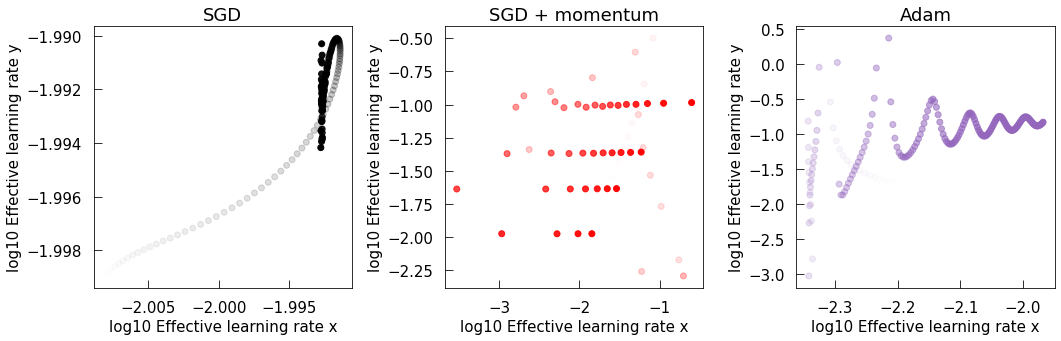

In [166]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

cmap = colors.LinearSegmentedColormap.from_list('incr_alpha', [(0, (*colors.to_rgb('k'),0)), (1, 'k')])

ax[0].scatter(np.log10([-(keep_param[i + 1][0] - keep_param[i][0]) / 
                        (cool_gradient((keep_param[i][0] + keep_param[i + 1][0]) / 2,
                                       (keep_param[i][1] + keep_param[i + 1][1]) / 2)[0]) for i in range(len(keep_param) - 1)]),
              np.log10([-(keep_param[i+1][1]-keep_param[i][1]) / 
                        (cool_gradient((keep_param[i][0] + keep_param[i + 1][0]) / 2,
                                       (keep_param[i][1] + keep_param[i + 1][1]) / 2)[1]) for i in range(len(keep_param) - 1)]),
              cmap=cmap,
              c=np.arange(len(keep_param) - 1))

ax[0].set_title('SGD')
ax[0].set_xlabel('log10 Effective learning rate x')
ax[0].set_ylabel('log10 Effective learning rate y')

cmap = colors.LinearSegmentedColormap.from_list('incr_alpha', [(0, (*colors.to_rgb('r'),0)), (1, 'r')])

ax[1].scatter(np.log10([-(keep_param_m[i + 1][0] - keep_param_m[i][0]) / 
                        (cool_gradient((keep_param_m[i][0] + keep_param_m[i + 1][0]) / 2,
                                       (keep_param_m[i][1] + keep_param_m[i + 1][1]) / 2)[0]) for i in range(len(keep_param_m) - 1)]),
              np.log10([-(keep_param_m[i + 1][1] - keep_param_m[i][1]) / 
                        (cool_gradient((keep_param_m[i][0] + keep_param_m[i + 1][0]) / 2, 
                                       (keep_param_m[i][1] + keep_param_m[i + 1][1]) / 2)[1]) for i in range(len(keep_param_m) - 1)]),
              cmap=cmap,
              c=np.arange(len(keep_param) - 1))

ax[1].set_title('SGD + momentum')
ax[1].set_xlabel('log10 Effective learning rate x')
ax[1].set_ylabel('log10 Effective learning rate y')

cmap = colors.LinearSegmentedColormap.from_list('incr_alpha', [(0, (*colors.to_rgb('C4'),0)), (1, 'C4')])

ax[2].scatter(np.log10([-(keep_param_a[i + 1][0] - keep_param_a[i][0]) / 
                        (cool_gradient((keep_param_a[i][0] + keep_param_a[i + 1][0]) / 2,
                                       (keep_param_a[i][1] + keep_param_a[i + 1][1]) / 2)[0]) for i in range(len(keep_param_a) - 1)]),
              np.log10([-(keep_param_a[i + 1][1] - keep_param_a[i][1]) /
                        (cool_gradient((keep_param_a[i][0] + keep_param_a[i + 1][0]) / 2,
                                       (keep_param_a[i][1] + keep_param_a[i + 1][1]) / 2)[1]) for i in range(len(keep_param_a) - 1) ]),
              cmap=cmap,
              c=np.arange(len(keep_param) - 1))

ax[2].set_title('Adam')
ax[2].set_xlabel('log10 Effective learning rate x')
ax[2].set_ylabel('log10 Effective learning rate y')

plt.tight_layout()
plt.show()

In [167]:
fig = go.Figure(data=[go.Surface(z=basic_cool_function(xg,yg), x=xg, y=yg, colorscale='RdBu_r', opacity=0.5)])

fig.update_traces(contours_z=dict(show=True, usecolormap=True, highlightcolor="limegreen", project_z=True))

fig.add_trace(go.Scatter3d(x=[p[0]for p in keep_param],
                           y=[p[1]for p in keep_param],
                           z=[keep_lossi for keep_lossi in keep_loss],
                           marker=dict(size=2, color='black'),
                           name='SGD lr:{}'.format(lr_SGD)))

fig.add_trace(go.Scatter3d(x=[p[0]for p in keep_param_m],
                           y=[p[1]for p in keep_param_m],
                           z=[keep_lossi for keep_lossi in keep_loss_m],
                           marker=dict(size=2, color='red'),
                           name='SGD lr:{} with momentum:{}'.format(lr_SGD_m, moment)))

fig.add_trace(go.Scatter3d(x=[p[0]for p in keep_param_a],
                           y=[p[1]for p in keep_param_a],
                           z=[keep_lossi for keep_lossi in keep_loss_a],
                           marker=dict(size=2, color='purple'),
                           name='Adam lr:{}'.format(lr_Adam)))

fig.update_layout(title='Initial points x:{} y:{}'.format(x0,y0), 
                  autosize=True, 
                  width=1000, 
                  height=1000,
                  scene_camera_eye=dict(x=1.5, y=1.5, z=1),
                  margin=dict(l=65, r=50, b=65, t=90),
                  scene=dict(xaxis_title='Parameter x', yaxis_title='Parameter y', zaxis_title='Cool function'))

fig.update_layout(legend=dict(yanchor="top", xanchor="right"))

plot(fig, filename='images_intro/cool_function_1.html')

fig.show()

In [168]:
lr_SGD = 1e-2
lr_SGD_m = 1e-2
lr_Adam = 1e-2
epochs = 200

moment = 0.92

model = Cool_function(1, -0.5)

optimizer = torch.optim.SGD(model.parameters(), lr=lr_SGD)

keep_loss = []
keep_param = []
for t in range(epochs):
    
    loss = model()
    
    keep_loss.append(loss.item())
    
    keep_param.append([model.x.detach().numpy()[0], model.y.detach().numpy()[0]])

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
model = Cool_function(1, -0.5)

optimizer = torch.optim.SGD(model.parameters(), lr=lr_SGD_m,momentum=moment)

keep_loss_m = []
keep_param_m = []
for t in range(epochs):
    
    loss = model()
    
    keep_loss_m.append(loss.item())
    
    keep_param_m.append([model.x.detach().numpy()[0], model.y.detach().numpy()[0]])

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    
model = Cool_function(1, -0.5)

optimizer = torch.optim.Adam(model.parameters(), lr=lr_Adam)
keep_loss_a = []
keep_param_a = []
for t in range(epochs):
    
    loss = model()
    
    keep_loss_a.append(loss.item())
    
    keep_param_a.append([model.x.detach().numpy()[0], model.y.detach().numpy()[0]])

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

In [169]:
fig = go.Figure(data=[go.Surface(z=basic_cool_function(xg,yg), x=xg, y=yg, colorscale='RdBu_r', opacity=0.5)])

fig.update_traces(contours_z=dict(show=True, usecolormap=True, highlightcolor="limegreen", project_z=True))

fig.add_trace(go.Scatter3d(x=[p[0]for p in keep_param],
                           y=[p[1]for p in keep_param],
                           z=[keep_lossi for keep_lossi in keep_loss],
                           marker=dict(size=2, color='black'),
                           name='SGD lr:{}'.format(lr_SGD)))

fig.add_trace(go.Scatter3d(x=[p[0]for p in keep_param_m],
                           y=[p[1]for p in keep_param_m],
                           z=[keep_lossi for keep_lossi in keep_loss_m],
                           marker=dict(size=2, color='red'),
                           name='SGD lr:{} with momentum:{}'.format(lr_SGD_m, moment)))

fig.add_trace(go.Scatter3d(x=[p[0]for p in keep_param_a],
                           y=[p[1]for p in keep_param_a],
                           z=[keep_lossi for keep_lossi in keep_loss_a],
                           marker=dict(size=2, color='purple'),
                           name='Adam lr:{}'.format(lr_Adam)))

fig.update_layout(title='Initial points x:{} y:{}'.format(x0,y0), 
                  autosize=True,
                  width=1000,
                  height=1000,
                  scene_camera_eye=dict(x=1.5, y=1.5, z=1),
                  margin=dict(l=65, r=50, b=65, t=90),
                  scene=dict(xaxis_title='Parameter x',
                             yaxis_title='Parameter y',
                             zaxis_title='Cool function'))

fig.update_layout(legend=dict(yanchor="top", xanchor="right"))

plot(fig, filename='images_intro/cool_function_2.html')

fig.show()

The hyperparameters $\eta$, $\mu$, $\beta_1$, and $\beta_2$ are important and so is the choice of your optimizer. Setting up hyperparameters and finding out good ways to deal with complex loss landscapes are paramount when using deep learning to solve a problem. This is why we spent that much time on these subjects. That said, nowadays a lot of people use ADAM and don't bother too much about the (hyper)parameters $\beta_1$, $\beta_2$.

### Mini batch : easier to reach global minima and less memory/operations <a class="anchor" id="mini_batch"></a>

We saw above a deterministic (as opposed to stochastic) version of the Stochastic Gradient Descent algorithm. Its updates used gradient from a full batch of data points:

$$
w_{t+1} = w_{t} - \frac{\eta}{n} \cdot \sum^{n}_{i} \nabla Q_{i}(w).
$$

Stochastic Gradient Descent (SGD) in its simplest form updates the parameters of the model using a gradient calculation for every point in the dataset, sampled sequentially:

$$
w_{t+1} = w_{t} - \eta \nabla Q_{i}(w).
$$

The "stochastic" in the name comes from the random sampling of data point $i$. At time $t$ only the gradient of the loss function at this random point is used to update the model's parameters.

This strategy requires less gradient calculation, so less memory, but also potentially let's the optimizer explore more of the diverse subspaces of the loss landscape. But it is also very noisy because ultimately it is the *full* gradient that points to (the opposite direction of) the minimum. This noise will manifest in the spikiness of the curve "training loss vs. epochs".

To attenuate the noise, one can use mini-batches of sampled data points for computing gradients. If the size of the mini-batch is $n_{\text{batch}},$ the model's parameters will update as 

$$
w_{t+1} = w_{t} - \frac{\eta}{n_{\text{batch}}} \cdot \sum^{n_{\text{batch}}}_{i} \nabla Q_{i}(w)
$$

If your mini-batch size is large enough then each mini-batch should be, to some extent, statisticaly similar to each other and so the gradient direction becomes less noisy. 

The ADAM optimizer is compatible with mini-batches, and below is how they are usually used.

___

**Note**: in the usual implementation of mini-batches, all mini-batches are processed within one epoch and the "loss vs. epochs" curve depicts the *average* of the loss across all mini-batches in each epoch.

#### Mini batch implementation with SGD

In [170]:
def training_overview_multi_classes_imbalanced_wd_early_batch(model, epochs, x_train_3, y_train_3, x_val_3, y_val_3, wd, batch_size):
    model.train()
    
    w = compute_class_weight('balanced', np.unique(y_train_3), np.array(y_train_3))
    weights_classes = torch.tensor(w, dtype=torch.float32)
    print('weights_classes',weights_classes)
    
    loss_fn = torch.nn.CrossEntropyLoss(weight=weights_classes)
    
    optimizer = torch.optim.SGD(model.parameters(), lr = 0.1, momentum = 0.8,weight_decay=wd)
    
    keep_loss=[]
    keep_loss_val=[]
    keep_score=[]
    keep_score_val=[]
    for epoch in range(epochs):
        losses = []
        f1s = []
        losses_val = []
        f1s_val = []
        model.train()
        for d in range(0,len(x_train_3), batch_size):  # Loop over batches
            optimizer.zero_grad()

            # Forward pass
            output_train = model(x_train_3[d:min(d + batch_size, len(x_train_3) - 1)])  # What is fed to the training 
                                                                                        # is a subpart of the data, a mini-batch

            # Compute Score
            sm = torch.nn.Softmax(dim=1)
            _, y_pred_train = torch.max(torch.tensor(sm(output_train).detach().numpy().tolist()), dim=1)
            
            # Compute Loss
            loss = loss_fn(output_train.squeeze(), y_train_3[d:min(d + batch_size, len(x_train_3) - 1)])
            
            f1_train = metrics.f1_score(y_train_3[d:min(d + batch_size, len(x_train_3) - 1)], y_pred_train, average='weighted')
            
            # Backward pass
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            
            losses.append(loss.item())
            f1s.append(f1_train.item())
            
        model.eval()
        with torch.no_grad():
            for d in range(0, len(x_val_3), batch_size):  # Loop over batches
                output_val = model(x_val_3[d:min(d + batch_size, len(x_val_3) - 1)])
                loss_val = loss_fn(output_val.squeeze(), y_val_3[d:min(d + batch_size, len(x_val_3) - 1)])
                sm = torch.nn.Softmax(dim=1)
                _, y_pred_val = torch.max(torch.tensor(sm(output_val).detach().numpy().tolist()), dim=1)
                f1_val = metrics.f1_score(y_val_3[d:min(d + batch_size, len(x_val_3) - 1)], y_pred_val, average='weighted')
                losses_val.append(loss_val.item())
                f1s_val.append(f1_val.item())
            
        keep_loss.append(np.mean(losses))
        keep_loss_val.append(np.mean(losses_val))
        
        keep_score.append(np.mean(f1s))  # Average output over all mini-batches
        keep_score_val.append(np.mean(f1s_val))  # To have a measure per epoch
        
        if epoch % 100 == 0:
            print('Epoch {}: train loss: {} validation loss: {}\ntrain f1: {} validation f1: {}'.format(epoch, 
                                                                                                        keep_loss[-1],
                                                                                                        keep_loss_val[-1],
                                                                                                        keep_score[-1],
                                                                                                        keep_score_val[-1]))
        if epoch == epochs - 1:
            print('Epoch {}: train loss: {} validation loss: {}train f1: {} validation f1: {}'.format(epoch, 
                                                                                                      keep_loss[-1],
                                                                                                      keep_loss_val[-1],
                                                                                                      keep_score[-1],
                                                                                                      keep_score_val[-1]))
        
        if (epoch > 100) and (keep_score_val[-1] < keep_score_val[-2] - 2 * np.std(keep_score_val[-50:-1])):
            print(epoch, keep_score_val[-1], keep_score_val[-2] - np.std(keep_score_val[-100:-1]))
            break
            
    fig, ax=plt.subplots(1, 2, figsize=(10, 5))
    
    ax[0].plot(np.arange(len(keep_loss)), keep_loss, 'r', label='training set')
    ax[0].plot(np.arange(len(keep_loss)), keep_loss_val, 'b', label='validation set')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Cross entropy loss')
    ax[0].legend(loc='best')
    
    ax[1].plot(np.arange(len(keep_loss)), keep_score, 'r', label='training set')
    ax[1].plot(np.arange(len(keep_loss)), keep_score_val, 'b', label='validation set')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Weighted f1 score')
    ax[1].legend(loc='best')
    
    plt.tight_layout()
    plt.show()

In the following example the batch size is too small. You can see that this is the case from the wild fluctuations of the loss function curve (here mainly on the validation set). But note that "convergence" is quite fast: it happens in roughly 10 epochs.

weights_classes tensor([0.7169, 0.4273, 0.4529, 1.0399, 0.8502, 3.8460, 1.0817, 4.1068, 4.0383,
        4.1068])
Epoch 0: train loss: 2.254243913449739 validation loss: 2.10290390253067
train f1: 0.14475288973130102 validation f1: 0.21339386389121878
Epoch 100: train loss: 0.3141477241327888 validation loss: 1.2389546036720276
train f1: 0.9291761427326949 validation f1: 0.7324948664609978
106 0.6761269724416021 0.706232096389027


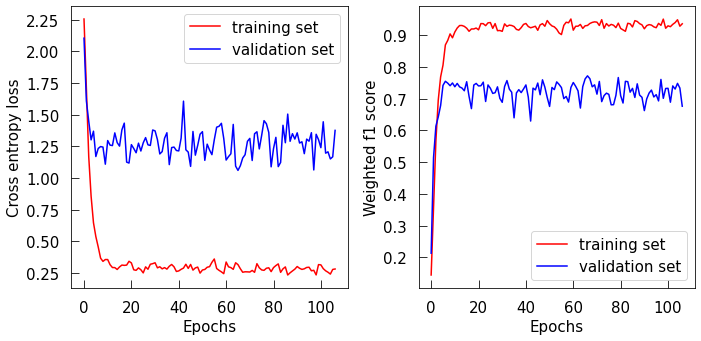

In [171]:
archi = ((8000, 80), (80,80))
model = Feedforward_deeper_drop(Feedforward_block_drop, archi, 10, 0.1)
epochs = 500

training_overview_multi_classes_imbalanced_wd_early_batch(model,
                                                          epochs,
                                                          X_train_subcell_ready,
                                                          y_train_subcell_ready,
                                                          X_val_subcell_ready,
                                                          y_val_subcell_ready,
                                                          0.01,
                                                          64)

Here the batch size is more appropriate, but convergence is slower, happening in around 30 epochs.

weights_classes tensor([0.7169, 0.4273, 0.4529, 1.0399, 0.8502, 3.8460, 1.0817, 4.1068, 4.0383,
        4.1068])
Epoch 0: train loss: 2.3034873008728027 validation loss: 2.289999008178711
train f1: 0.07458642570801922 validation f1: 0.08981596918137526
Epoch 100: train loss: 0.20812026038765907 validation loss: 1.0524718761444092
train f1: 0.9636564246655348 validation f1: 0.7751801703421003
103 0.7697804705773081 0.6712017103882569


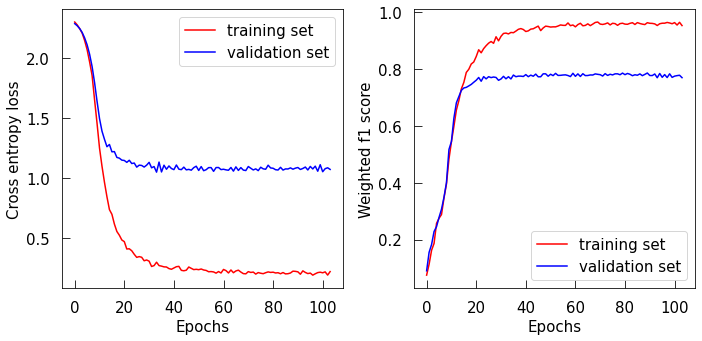

In [172]:
archi = ((8000, 80), (80, 80))
model = Feedforward_deeper_drop(Feedforward_block_drop, archi, 10, 0.1)
epochs = 500

training_overview_multi_classes_imbalanced_wd_early_batch(model, 
                                                          epochs,
                                                          X_train_subcell_ready,
                                                          y_train_subcell_ready,
                                                          X_val_subcell_ready,
                                                          y_val_subcell_ready,
                                                          0.01,
                                                          128 * 5)

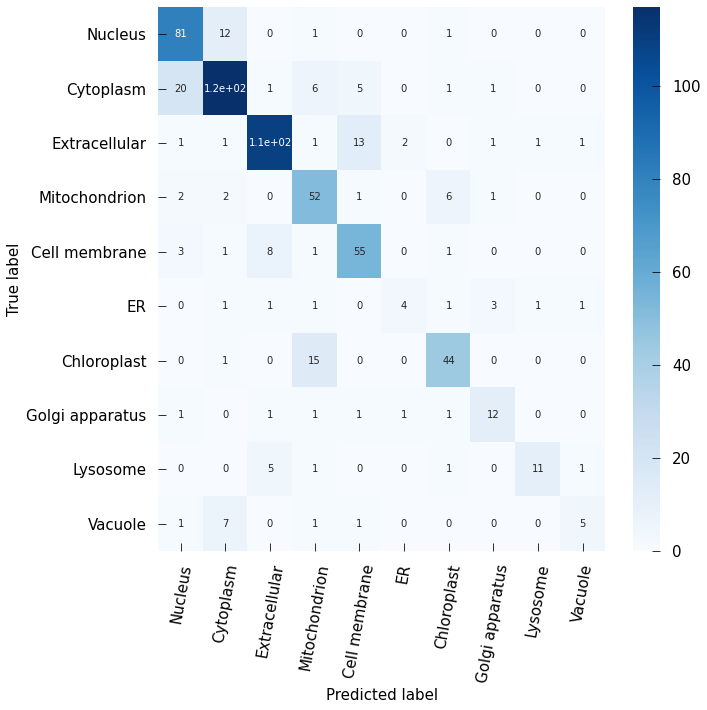

In [173]:
model.eval()

y_pred = model(X_val_subcell_ready)
sm = torch.nn.Softmax(dim=1)
y_pred = sm(y_pred).detach().numpy()

_, y_pred = torch.max(torch.tensor(y_pred), dim=1)

confusion_mc_c = confusion_matrix(np.array(y_val_subcell_ready), y_pred)
df_cm_c = pd.DataFrame(confusion_mc_c, index=np.arange(10), columns=np.arange(10))

plt.figure(figsize=(10, 10))

ax = sns.heatmap(df_cm_c, annot=True, annot_kws={"size": 10}, cmap=plt.cm.Blues)

ax.set_xticklabels(list(dico_classes_subcell.values()), rotation=80)
ax.set_yticklabels(list(dico_classes_subcell.values()), rotation=0)

plt.ylabel('True label')
plt.xlabel('Predicted label')

plt.show()
plt.close()

#### Learning rate scheduler : here for SGD

In [174]:
def training_overview_multi_classes_imbalanced_wd_early_batch_lr(model, epochs, x_train_3, y_train_3, x_val_3, y_val_3, wd, batch_size):
    model.train()
    
    num_train_steps = int(len(x_train_3) /  batch_size * epochs)
    
    w = compute_class_weight('balanced', np.unique(y_train_3), np.array(y_train_3))
    weights_classes = torch.tensor(w, dtype=torch.float32)
    print('weights_classes', weights_classes)
    
    loss_fn = torch.nn.CrossEntropyLoss(weight=weights_classes)
    
    optimizer = torch.optim.SGD(model.parameters(), lr = 0.1,momentum = 0.8,weight_decay=wd)
    
    # The scheduler
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, num_train_steps//20, gamma=0.3, last_epoch=-1, verbose=False)

    keep_loss=[]
    keep_loss_val=[]
    keep_score=[]
    keep_score_val=[]
    for epoch in range(epochs):
        losses = []
        f1s = []
        losses_val = []
        f1s_val = []
        model.train()
        for d in range(0, len(x_train_3), batch_size):
            optimizer.zero_grad()

            # Forward pass
            output_train = model(x_train_3[d:min(d + batch_size, len(x_train_3) - 1)])

            # Compute Score
            sm = torch.nn.Softmax(dim=1)
            _, y_pred_train = torch.max(torch.tensor(sm(output_train).detach().numpy().tolist()), dim=1)
            
            # Compute Loss
            loss = loss_fn(output_train.squeeze(), y_train_3[d:min(d + batch_size, len(x_train_3) - 1)])
            
            f1_train = metrics.f1_score(y_train_3[d:min(d + batch_size, len(x_train_3) - 1)], y_pred_train, average='weighted')
            
            # Backward pass
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            
            losses.append(loss.item())
            f1s.append(f1_train.item())
            
        model.eval()
        with torch.no_grad():
            for d in range(0, len(x_val_3), batch_size):
                output_val = model(x_val_3[d:min(d + batch_size, len(x_val_3) - 1)])
                loss_val = loss_fn(output_val.squeeze(), y_val_3[d:min(d + batch_size, len(x_val_3) - 1)])
                sm = torch.nn.Softmax(dim=1)
                _, y_pred_val = torch.max(torch.tensor(sm(output_val).detach().numpy().tolist()), dim=1)
                f1_val = metrics.f1_score(y_val_3[d:min(d + batch_size, len(x_val_3) - 1)], y_pred_val, average='weighted')
                losses_val.append(loss_val.item())
                f1s_val.append(f1_val.item())
            
        keep_loss.append(np.mean(losses))
        keep_loss_val.append(np.mean(losses_val))
        keep_score.append(np.mean(f1s))
        keep_score_val.append(np.mean(f1s_val))
        
        if epoch % 100 == 0:
            print('Epoch {}: train loss: {} validation loss: {}\ntrain f1: {} validation f1: {}'.format(epoch, 
                                                                                                        keep_loss[-1],
                                                                                                        keep_loss_val[-1],
                                                                                                        keep_score[-1],
                                                                                                        keep_score_val[-1]))
        if epoch == epochs - 1:
            print('Epoch {}: train loss: {} validation loss: {}train f1: {} validation f1: {}'.format(epoch, 
                                                                                                      keep_loss[-1],
                                                                                                      keep_loss_val[-1],
                                                                                                      keep_score[-1],
                                                                                                      keep_score_val[-1]))
        
        if (epoch > 100) and (keep_score_val[-1] < keep_score_val[-2] - 2 * np.std(keep_score_val[-50:-1])):
            print(epoch, keep_score_val[-1], keep_score_val[-2] - np.std(keep_score_val[-100:-1]))
            break
            
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    
    ax[0].plot(np.arange(len(keep_loss)), keep_loss, 'r', label='training set')
    ax[0].plot(np.arange(len(keep_loss)), keep_loss_val, 'b', label='validation set')
    
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Cross entropy loss')
    ax[0].legend(loc='best')
    
    ax[1].plot(np.arange(len(keep_loss)), keep_score, 'r', label='training set')
    ax[1].plot(np.arange(len(keep_loss)), keep_score_val, 'b', label='validation set')
    
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Weighted f1 score')
    ax[1].legend(loc='best')
    
    plt.tight_layout()
    plt.show()

weights_classes tensor([0.7169, 0.4273, 0.4529, 1.0399, 0.8502, 3.8460, 1.0817, 4.1068, 4.0383,
        4.1068])
Epoch 0: train loss: 2.304476261138916 validation loss: 2.2985715866088867
train f1: 0.08365313603087363 validation f1: 0.08955145078633585
Epoch 100: train loss: 0.2095378413796425 validation loss: 1.1029608249664307
train f1: 0.9583828609364939 validation f1: 0.7731374092234892
106 0.7692446718166205 0.7022010491915781


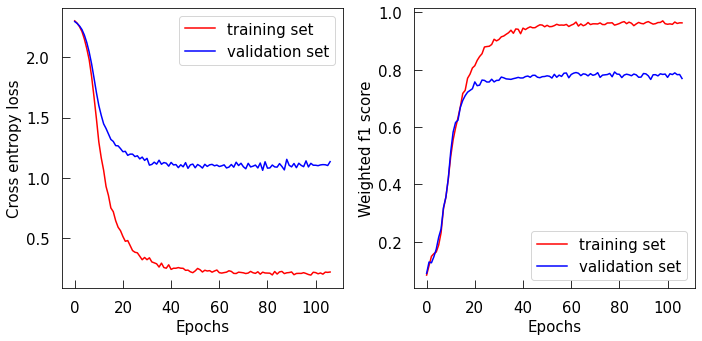

In [175]:
archi = ((8000, 80), (80, 80))
model = Feedforward_deeper_drop(Feedforward_block_drop, archi, 10, 0.1)
epochs = 500

training_overview_multi_classes_imbalanced_wd_early_batch_lr(model, 
                                                             epochs, 
                                                             X_train_subcell_ready, 
                                                             y_train_subcell_ready, 
                                                             X_val_subcell_ready,
                                                             y_val_subcell_ready,
                                                             0.01,
                                                             128 * 5)

#### Adam optimizer

In [176]:
def training_overview_multi_classes_imbalanced_wd_early_batch_Adam(model, epochs, x_train_3, y_train_3, x_val_3, y_val_3, wd, batch_size):
    model.train()
    
    w = compute_class_weight('balanced', np.unique(y_train_3), np.array(y_train_3))
    weights_classes = torch.tensor(w, dtype=torch.float32)
    print('weights_classes', weights_classes)
    
    loss_fn = torch.nn.CrossEntropyLoss(weight=weights_classes)
    
    optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001, weight_decay=wd)  # We use ADAM instead of SGD
    
    keep_loss=[]
    keep_loss_val=[]
    keep_score=[]
    keep_score_val=[]
    for epoch in range(epochs):
        losses = []
        f1s = []    
        losses_val = []
        f1s_val = []
        model.train()
        for d in range(0, len(x_train_3), batch_size):
            optimizer.zero_grad()

            # Forward pass
            output_train = model(x_train_3[d:min(d + batch_size, len(x_train_3) - 1)])

            # Compute Score
            sm = torch.nn.Softmax(dim=1)
            _, y_pred_train = torch.max(torch.tensor(sm(output_train).detach().numpy().tolist()), dim=1)
            
            # Compute Loss
            loss = loss_fn(output_train.squeeze(), y_train_3[d:min(d + batch_size, len(x_train_3) - 1)])
            
            f1_train = metrics.f1_score(y_train_3[d:min(d + batch_size, len(x_train_3) - 1)], y_pred_train, average='weighted')
            
            # Backward pass
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            
            losses.append(loss.item())
            f1s.append(f1_train.item())
            
        model.eval()
        with torch.no_grad():
            for d in range(0, len(x_val_3), batch_size):
                output_val = model(x_val_3[d:min(d + batch_size, len(x_val_3) - 1)])
                loss_val = loss_fn(output_val.squeeze(), y_val_3[d:min(d + batch_size, len(x_val_3) - 1)])
                sm = torch.nn.Softmax(dim=1)
                _, y_pred_val = torch.max(torch.tensor(sm(output_val).detach().numpy().tolist()), dim=1)
                f1_val = metrics.f1_score(y_val_3[d:min(d + batch_size, len(x_val_3) - 1)], y_pred_val, average='weighted')
                losses_val.append(loss_val.item())
                f1s_val.append(f1_val.item())
            
        keep_loss.append(np.mean(losses))
        keep_loss_val.append(np.mean(losses_val))
        keep_score.append(np.mean(f1s))
        keep_score_val.append(np.mean(f1s_val))
        
        if epoch % 100 == 0:
            print('Epoch {}: train loss: {} validation loss: {}\ntrain f1: {} validation f1: {}'.format(epoch, 
                                                                                                        keep_loss[-1],
                                                                                                        keep_loss_val[-1],
                                                                                                        keep_score[-1],
                                                                                                        keep_score_val[-1]))
        if epoch == epochs - 1:
            print('Epoch {}: train loss: {} validation loss: {}train f1: {} validation f1: {}'.format(epoch, 
                                                                                                      keep_loss[-1],
                                                                                                      keep_loss_val[-1],
                                                                                                      keep_score[-1],
                                                                                                      keep_score_val[-1]))

        if (epoch > 100) and (keep_score_val[-1] < keep_score_val[-2] - 2 * np.std(keep_score_val[-50:-1])):
            print(epoch, keep_score_val[-1], keep_score_val[-2] - np.std(keep_score_val[-100:-1]))
            break
            
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    
    ax[0].plot(np.arange(len(keep_loss)), keep_loss, 'r', label='training set')
    ax[0].plot(np.arange(len(keep_loss)), keep_loss_val, 'b', label='validation set')
    
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Cross entropy loss')
    ax[0].legend(loc='best')
    
    ax[1].plot(np.arange(len(keep_loss)), keep_score, 'r', label='training set')
    ax[1].plot(np.arange(len(keep_loss)), keep_score_val, 'b', label='validation set')
    
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Weighted f1 score')
    ax[1].legend(loc='best')
    
    plt.tight_layout()
    plt.show()

weights_classes tensor([0.7169, 0.4273, 0.4529, 1.0399, 0.8502, 3.8460, 1.0817, 4.1068, 4.0383,
        4.1068])
Epoch 0: train loss: 2.306743860244751 validation loss: 2.3023159503936768
train f1: 0.09246240019222296 validation f1: 0.10044694531006418
Epoch 100: train loss: 0.6988979876041412 validation loss: 1.3201221227645874
train f1: 0.8316068715388777 validation f1: 0.7631120761925381
Epoch 200: train loss: 0.3849392980337143 validation loss: 1.14745032787323
train f1: 0.9068551794700113 validation f1: 0.7647903437419161
200 0.7647903437419161 0.7684755502333265


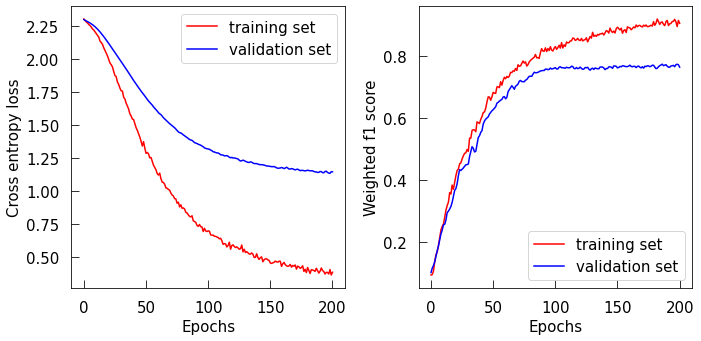

In [177]:
archi = ((8000, 80), (80, 80))
model = Feedforward_deeper_drop(Feedforward_block_drop, archi, 10, 0.1)
epochs = 1000

training_overview_multi_classes_imbalanced_wd_early_batch_Adam(model,
                                                               epochs,
                                                               X_train_subcell_ready,
                                                               y_train_subcell_ready,
                                                               X_val_subcell_ready,
                                                               y_val_subcell_ready,
                                                               0.01,
                                                               128 * 5)

The choice of the optimizer doesn't make too much of a difference here. What is rather more important is the regularization, overall learning rate, and batch size.

## Activation functions <a class="anchor" id="activation"></a>

Activation functions determine when, and by how much, the neuron on which that function is applied is going to fire. If the activation function is non-linear and used in a network of at least 2 layers, then the [Universal Approximation Theorem](https://en.wikipedia.org/wiki/Universal_approximation_theorem) tells us that we will be able to represent any well-behaved (continuous and integrable) function through the neural network. "Represent" is an important term here. It doesn't mean that we will be able to learn and actually find this representation, but it tells us that, in principle, it can approximate any function we'd looking for.

We have already seen two or three (if you count the softmax) activation functions throughout this notebook. We plot below four of the most commonly used activation functions in Deep Learning.

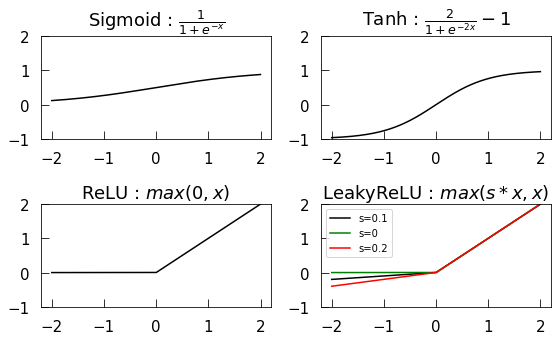

In [178]:
fig, ax = plt.subplots(2, 2, figsize=(8, 5))

x = torch.Tensor(np.arange(-2, 2, 0.001))
R = torch.nn.ReLU()
LR1 = torch.nn.LeakyReLU(0.1)
LR2 = torch.nn.LeakyReLU(0)
LR3 = torch.nn.LeakyReLU(0.2)

ax[0,0].plot(x, torch.sigmoid(x), 'k')
ax[0,0].set_title(r"Sigmoid : $\frac{1}{1+e^{-x}}$")

ax[0,1].plot(x, torch.tanh(x), 'k')
ax[0,1].set_title(r"Tanh : $\frac{2}{1+e^{-2x}}-1$")

ax[1,0].plot(x, R(x), 'k')
ax[1,0].set_title(r"ReLU : $max(0,x)$")

ax[1,1].plot(x, LR1(x), 'k', label='s=0.1')
ax[1,1].plot(x, LR2(x), 'g', label='s=0')

ax[1,1].plot(x, LR3(x), 'r', label='s=0.2')
ax[1,1].set_title(r"LeakyReLU : $max(s*x,x)$")
ax[1,1].legend(loc='best', fontsize=10)

ax[0,0].set_ylim([-1,2])
ax[0,1].set_ylim([-1,2])
ax[1,0].set_ylim([-1,2])
ax[1,1].set_ylim([-1,2])

plt.tight_layout()
plt.show()

There is no actual general rules to choose the activation function you would to use, even though there are some rules-of-thumb. One thing we should take into account is how those functions differ and why those differences matter.

First of all, those functions don't all have the same range. The Rectifying Linear Unit (ReLU) types have infinite range, whereas sigmoid and hyperbolic tangent (tanh) functions are bounded. The boundedness of sigmoid and tanh means that network weights that could be very different might end up on the saturating part of the activation function and thus not be differentiated. On the other hand, if you have an unbounded range (e.g. ReLU), you have to be a bit careful with how you explore the space of solutions. Otherwise, you could end up making huge steps in the loss landscape due to amplification by the activation function, and therefore potentially missing out the minimizers.

Secondly, the activation functions should be differentiable (at least by parts) and have a usefull gradient. ReLU-types are not differentiable at zero and non-leaky ReLUs have zero-valued derivatives as soon as the input variable is negative. As all of the learning relies on minimizing the loss function by updating the weights with some information about the gradient of the loss function, not being able to calculate a derivative at certain points is a problem. As is not updating your gradient because its value is zero. When the latter happens, we have what is called the ["vanishing gradient problem"](https://en.wikipedia.org/wiki/Vanishing_gradient_problem). This problem is reduced by the use of a LeakyReLU, but more on that in the next part.

Finally, you need to account for the starting point in the optimizer's exploration of the loss landscape. As we will see, initial conditions can be determining in the convergence of the optimization algorithm toward a solution. Because of the way we generally choose those initial conditions (small weights, close to zero, and randomly distributed), we would like our activation function to ressemble the identity function around 0. This way, the update of these weights can get large enough gradients at the begining of the training. The identity ressemblance also helps in not biasing the search too early-on by amplifying small weight differences into large update steps.  

## Weight initialization <a class="anchor" id="initialization"></a>

We have seen in the backpropagation part of this course that weight updates were calculated using essentially the chain rule. Operationally, this chain rule is nothing more than a successive multiplication of matrices. The chain can become very long depending on the structure of your network and you can imagine that this can lead to very unstable calculations. Gradients might tend toward huge magnitudes making your optmizer overstep the minima of the loss function (**gradient explosion**), they might rapidly converge to very small magnitudes leading the loss landscape exploration to a halt (**gradient vanishing**).

In [179]:
print("Exploding gradient")

M = torch.normal(0, 1, size=(4, 4))
print('A single matrix: \n', M)
for i in range(100):
    M = torch.mm(M, torch.normal(0, 1, size=(4, 4)))

print('After multiplying 100 matrices:\n', M)

print()
print("---")
print()

print("Vanishing gradient")
M = torch.normal(0, 1e-2, size=(4, 4))
print('A single matrix:\n', M)
for i in range(100):
    M = torch.mm(M, torch.normal(0, 1e-2, size=(4, 4)))

print('After multiplying 100 matrices:\n', M)

Exploding gradient
A single matrix: 
 tensor([[-1.0111,  1.7472, -0.1161, -0.0792],
        [-0.1646, -0.9277, -0.3264,  2.2350],
        [-0.0706, -0.8683, -0.3090,  0.9317],
        [-0.4272, -0.8376, -0.7030, -2.5726]])
After multiplying 100 matrices:
 tensor([[-9.3769e+26, -1.1755e+26,  1.6854e+27, -2.0512e+27],
        [-6.5782e+25, -8.2463e+24,  1.1824e+26, -1.4390e+26],
        [ 1.7452e+26,  2.1877e+25, -3.1368e+26,  3.8176e+26],
        [ 7.4678e+26,  9.3615e+25, -1.3423e+27,  1.6336e+27]])

---

Vanishing gradient
A single matrix:
 tensor([[ 0.0072,  0.0022,  0.0137,  0.0217],
        [ 0.0017, -0.0085,  0.0132, -0.0244],
        [-0.0079, -0.0135, -0.0078,  0.0101],
        [-0.0045, -0.0027,  0.0025, -0.0007]])
After multiplying 100 matrices:
 tensor([[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]])


Some of activation functions are able to bound the output the network's linear layers to a small range. This property has, in turn, a direct impact on the magnitude of the gradients being backpropagated. These gradients might even vanish for a large part of their support.

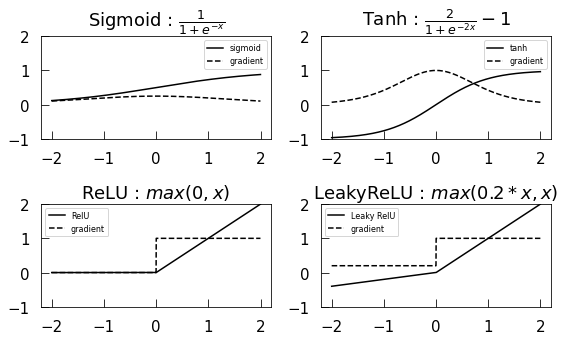

In [180]:
fig, ax = plt.subplots(2, 2, figsize=(8, 5))

xR = torch.arange(-2, 2, 0.001, requires_grad=True)
xS = torch.arange(-2, 2, 0.001, requires_grad=True)
xTa = torch.arange(-2, 2, 0.001, requires_grad=True)
xLR3 = torch.arange(-2, 2, 0.001, requires_grad=True)

R = F.relu(xR)
R.backward(torch.ones_like(xR))

S = torch.sigmoid(xS)
S.backward(torch.ones_like(xS))

Ta = torch.tanh(xTa)
Ta.backward(torch.ones_like(xTa))

LR3 = F.leaky_relu(xLR3, negative_slope=0.2)
LR3.backward(torch.ones_like(xLR3))

ax[0,0].plot(xS.detach().numpy(), S.detach().numpy(), 'k', label='sigmoid')
ax[0,0].plot(xS.detach().numpy(), xS.grad.numpy(), 'k--', label='gradient')
ax[0,0].set_title(r"Sigmoid : $\frac{1}{1+e^{-x}}$")
ax[0,0].legend(loc='best', fontsize=8)

ax[0,1].plot(xTa.detach().numpy(), Ta.detach().numpy(), 'k', label='tanh')
ax[0,1].plot(xTa.detach().numpy(), xTa.grad.numpy(),'k--', label='gradient')
ax[0,1].set_title(r"Tanh : $\frac{2}{1+e^{-2x}}-1$")
ax[0,1].legend(loc='best', fontsize=8)

ax[1,0].plot(xR.detach().numpy(), R.detach().numpy(), 'k', label='RelU')
ax[1,0].plot(xR.detach().numpy(), xR.grad.numpy(), 'k--', label='gradient')
ax[1,0].set_title(r"ReLU : $max(0,x)$")
ax[1,0].legend(loc='best', fontsize=8)

ax[1,1].plot(xLR3.detach().numpy(), LR3.detach().numpy(), 'k', label='Leaky RelU')
ax[1,1].plot(xLR3.detach().numpy(), xLR3.grad.numpy(), 'k--', label='gradient')
ax[1,1].set_title(r"LeakyReLU : $max(0.2*x,x)$")
ax[1,1].legend(loc='best', fontsize=8)

ax[0,0].set_ylim([-1,2])
ax[0,1].set_ylim([-1,2])
ax[1,0].set_ylim([-1,2])
ax[1,1].set_ylim([-1,2])

plt.tight_layout()
plt.show()

Nodes in the same layer are virtually the same. If the weights that feed into them are all initialized with the same number then they will be updated and evolve similarly, which nullifies the benefits of having multiple nodes per layer. If we want to have all of those nodes have meaningful signal, their input weights need to be initialized slightly differently from each other (or we could employ something that breaks their symmetry, like dropout).

---

To summarize what we discussed so far, our requirements for the initialization of weights and biases are:

- something stochastic to break the inherent symmetry of the network,
- initial weights and bias that are neither too big nor too small, so gradients don't start vanishing or exploding from the beginning,
- take into account the specificities of the nodes' activation functions.

---

There are plenty of initialization strategies to choose from, several of them being done automatically by Pytorch (see [here](https://pytorch.org/docs/stable/nn.init.html)). But let's look at one example of a very versatile and commonly used initialization procedure, one that we actually used when presenting the Xor problem.

[Xavier initialization](https://www.paperswithcode.com/method/xavier-initialization) looks at the problem through the angle of conservation of variance. If one can ensure that, at least during the first steps of training, the typical scale of the values that enter and exit a layer are similar (and vice versa for back propagation), then one should not end up disproportionately blowing up or squeezing down the network weights.

Write the output of node $i$ in layer $j$ (before the non-linearity) as $o_{i}^{(j)} = \sum_{k}^{\text{in}} w_{i,k}^{(j)} o_{k}^{(j-1)}$. If we are able to assign a variance of $\operatorname{Var}[o_{k}^{j-1}]=\gamma^{2}$ and $\operatorname{Var}[w_{i, k}^{(j)}] = \sigma^{2}$, for any $k$, then the variance at the node's output is $Var[o_{i}^{j}] = n_{in} \gamma^{2} \sigma^{2}$ (assuming independence of weights). A weight initialization strategy that picks a value of $\sigma^{2}$ so that $Var[o_{i}^{j}] = \gamma^{2}$ ensures that the scale is (statistically) conserved between the entrance and exit of the nodes. In other words, we'd like

$$
n_{\text{in}} \cdot \sigma^{2} = 1.
$$

We can do the same reasonning for backpropagation, the scale of values is preserved if

$$ 
n_{\text{out}} \cdot \sigma^{2} = 1.
$$

These two requirements cannot be simultaneously fullfilled, so Xavier initialization opts for setting

$$
\sigma^{2} = \frac{2}{n_{\text{in}} + n_{\text{out}}},
$$

and to reach this variance the initial weights are drawn from a $\mathcal{N} \left( 0, \frac{2}{n_{\text{in}} + n_{\text{out}}} \right)$ distribution.

## Normalization <a class="anchor" id="normalization"></a>

### Input scaling <a class="anchor" id="input_scale"></a>

Another way to ensure that your network behaves nicely is to scale your data before submitting it to the network. This makes the input features comparable in scale and, at least for the few first steps of training, reduces the risk of exploding gradient (as every variable will have a scale of around 1).

Let's first observe training *without* scaling.

weights_classes tensor([0.7169, 0.4273, 0.4529, 1.0399, 0.8502, 3.8460, 1.0817, 4.1068, 4.0383,
        4.1068])
Epoch 0: train loss: 2.310355484485626 validation loss: 2.297481060028076
train f1: 0.03959182013635223 validation f1: 0.037704018653134
Epoch 100: train loss: 0.6776098757982254 validation loss: 1.3141093254089355
train f1: 0.8259665170486821 validation f1: 0.7477493201281079
Epoch 200: train loss: 0.4136497974395752 validation loss: 1.1390200853347778
train f1: 0.904679309870347 validation f1: 0.7764054705817462
223 0.7730366108734377 0.7739273311670836


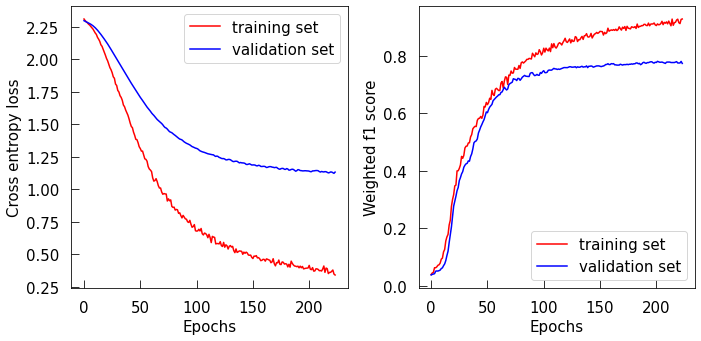

In [181]:
archi = ((8000, 80), (80, 80))
model = Feedforward_deeper_drop(Feedforward_block_drop, archi, 10, 0.1)
epochs = 1000

training_overview_multi_classes_imbalanced_wd_early_batch_Adam(model,
                                                               epochs,
                                                               X_train_subcell_ready,
                                                               y_train_subcell_ready,
                                                               X_val_subcell_ready,
                                                               y_val_subcell_ready,
                                                               0.01,
                                                               128 * 5)

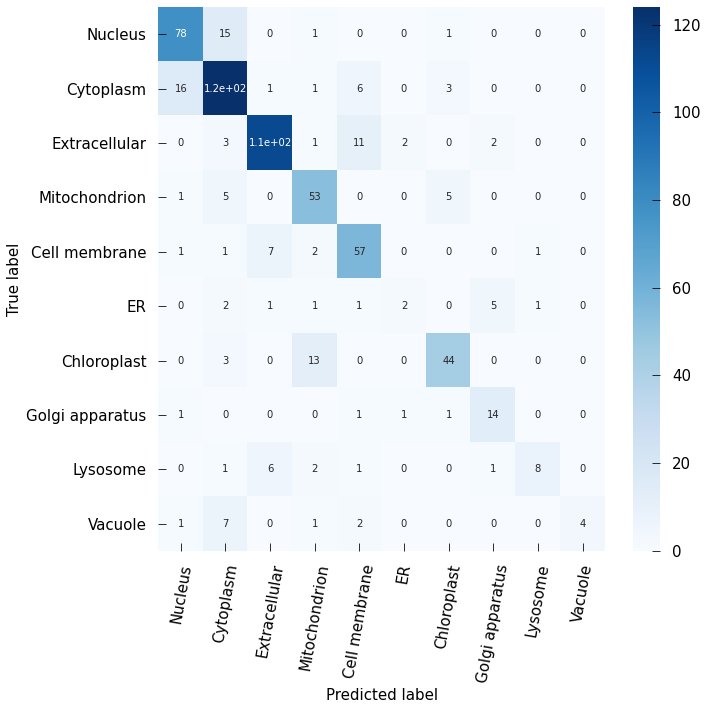

In [182]:
model.eval()

y_pred = model(X_val_subcell_ready)
sm = torch.nn.Softmax(dim=1)
y_pred = sm(y_pred).detach().numpy()

_, y_pred = torch.max(torch.tensor(y_pred), dim=1)

confusion_mc_c = confusion_matrix(np.array(y_val_subcell_ready), y_pred)
df_cm_c = pd.DataFrame(confusion_mc_c, index=np.arange(10), columns=np.arange(10))

plt.figure(figsize=(10, 10))

ax = sns.heatmap(df_cm_c, annot=True, annot_kws={"size": 10}, cmap=plt.cm.Blues)

ax.set_xticklabels(list(dico_classes_subcell.values()), rotation=80)
ax.set_yticklabels(list(dico_classes_subcell.values()), rotation=0)

plt.ylabel('True label')
plt.xlabel('Predicted label')

plt.show()
plt.close()

Now let's examine training *with* scaling. How do you think the scaling is done?

In [183]:
def training_overview_multi_classes_imbalanced_wd_early_batch_Adam_scaled_input(model,
                                                                                epochs,
                                                                                x_train_3,
                                                                                y_train_3,
                                                                                x_val_3,
                                                                                y_val_3,
                                                                                wd,
                                                                                batch_size):
    scaler_ = MinMaxScaler()
    scaler_.fit(x_train_3)
    
    x_train_3 = torch.FloatTensor(scaler_.transform(x_train_3))
    x_val_3 = torch.FloatTensor(scaler_.transform(x_val_3))
    
    w = compute_class_weight('balanced', np.unique(y_train_3), np.array(y_train_3))
    weights_classes = torch.tensor(w, dtype=torch.float32)
    print('weights_classes',weights_classes)
    
    loss_fn = torch.nn.CrossEntropyLoss(weight=weights_classes)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=wd)
    
    keep_loss=[]
    keep_loss_val=[]
    keep_score=[]
    keep_score_val=[]
    for epoch in range(epochs):
        losses = []
        f1s = []
        losses_val = []
        f1s_val = []
        model.train()
        for d in range(0, len(x_train_3), batch_size):
            optimizer.zero_grad()

            # Forward pass
            output_train = model(x_train_3[d:min(d + batch_size, len(x_train_3) - 1)])

            # Compute Score
            sm = torch.nn.Softmax(dim=1)
            _, y_pred_train = torch.max(torch.tensor(sm(output_train).detach().numpy().tolist()), dim=1)
            
            # Compute Loss
            loss = loss_fn(output_train.squeeze(), y_train_3[d:min(d + batch_size, len(x_train_3) - 1)])
            
            f1_train = metrics.f1_score(y_train_3[d:min(d + batch_size, len(x_train_3) - 1)], y_pred_train, average='weighted')
            
            # Backward pass
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            
            losses.append(loss.item())
            f1s.append(f1_train.item())
            
        model.eval()
        with torch.no_grad():
            for d in range(0, len(x_val_3), batch_size):
                output_val = model(x_val_3[d:min(d + batch_size, len(x_val_3) - 1)])
                sm = torch.nn.Softmax(dim=1)
                _, y_pred_val = torch.max(torch.tensor(sm(output_val).detach().numpy().tolist()), dim=1)
                f1_val = metrics.f1_score(y_val_3[d:min(d + batch_size, len(x_val_3) - 1)], y_pred_val, average='weighted')
                loss_val = loss_fn(output_val.squeeze(), y_val_3[d:min(d + batch_size, len(x_val_3) - 1)])
                losses_val.append(loss_val.item())
                f1s_val.append(f1_val.item())
            
        keep_loss.append(np.mean(losses))
        keep_loss_val.append(np.mean(losses_val))
        keep_score.append(np.mean(f1s))
        keep_score_val.append(np.mean(f1s_val))
        
        if epoch % 100 == 0:
            print('Epoch {}: train loss: {} validation loss: {}\ntrain f1: {} validation f1: {}'.format(epoch, 
                                                                                                        keep_loss[-1],
                                                                                                        keep_loss_val[-1],
                                                                                                        keep_score[-1],
                                                                                                        keep_score_val[-1]))
        if epoch == epochs - 1:
            print('Epoch {}: train loss: {} validation loss: {}train f1: {} validation f1: {}'.format(epoch, 
                                                                                                      keep_loss[-1],
                                                                                                      keep_loss_val[-1],
                                                                                                      keep_score[-1],
                                                                                                      keep_score_val[-1]))        
        
        if (epoch > 100) and (keep_score_val[-1] < keep_score_val[-2] - 2 * np.std(keep_score_val[-50:-1])):
            print(epoch, keep_score_val[-1], keep_score_val[-2] - np.std(keep_score_val[-100:-1]))
            break
            
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    
    ax[0].plot(np.arange(len(keep_loss)), keep_loss, 'r', label='training set')
    ax[0].plot(np.arange(len(keep_loss)), keep_loss_val, 'b', label='validation set')
    
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Cross entropy loss')
    ax[0].legend(loc='best')
    
    ax[1].plot(np.arange(len(keep_loss)), keep_score, 'r',label='training set')
    ax[1].plot(np.arange(len(keep_loss)), keep_score_val, 'b', label='validation set')
    
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Weighted f1 score')
    ax[1].legend(loc='best')
    
    plt.tight_layout()
    plt.show()

weights_classes tensor([0.7169, 0.4273, 0.4529, 1.0399, 0.8502, 3.8460, 1.0817, 4.1068, 4.0383,
        4.1068])
Epoch 0: train loss: 2.3059821724891663 validation loss: 2.30806303024292
train f1: 0.05310768669925868 validation f1: 0.044143029921197355
Epoch 100: train loss: 0.6668829619884491 validation loss: 1.3667457103729248
train f1: 0.8426265315912189 validation f1: 0.7518401802484652
178 0.7579323947618072 0.7544073117563622


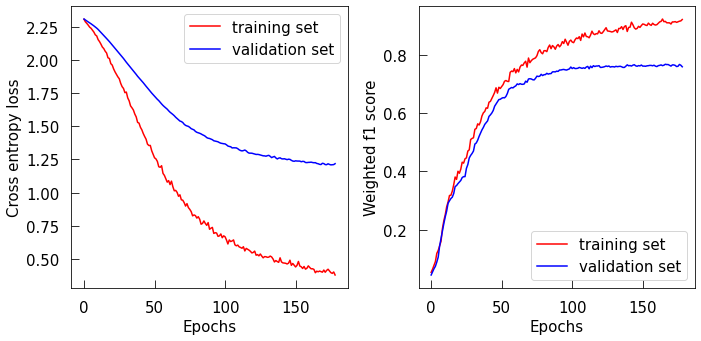

In [184]:
archi = ((8000, 80), (80, 80))
model = Feedforward_deeper_drop(Feedforward_block_drop, archi, 10, 0.1)
epochs = 1000

training_overview_multi_classes_imbalanced_wd_early_batch_Adam_scaled_input(model, 
                                                                            epochs,
                                                                            X_train_subcell_ready,
                                                                            y_train_subcell_ready,
                                                                            X_val_subcell_ready,
                                                                            y_val_subcell_ready,
                                                                            0.01,
                                                                            128 * 5)

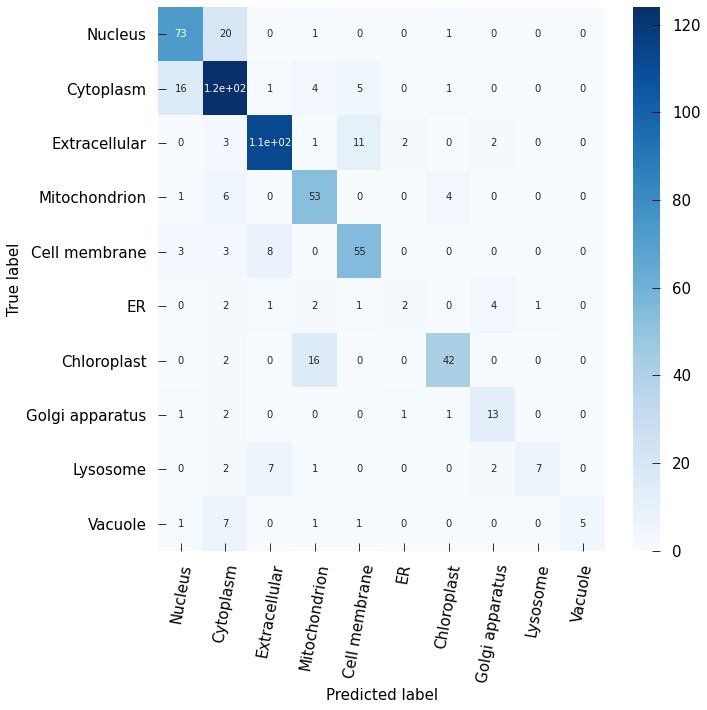

In [185]:
model.eval()

scaler_ = MinMaxScaler()
scaler_.fit(X_train_subcell_ready)

X_val_subcell_ready_scaled = torch.FloatTensor(scaler_.transform(X_val_subcell_ready))

y_pred = model(X_val_subcell_ready_scaled)
sm = torch.nn.Softmax(dim=1)
y_pred = sm(y_pred).detach().numpy()
_, y_pred = torch.max(torch.tensor(y_pred), dim=1)

confusion_mc_c = confusion_matrix(np.array(y_val_subcell_ready), y_pred)
df_cm_c = pd.DataFrame(confusion_mc_c, index=np.arange(10), columns=np.arange(10))

plt.figure(figsize=(10, 10))

ax = sns.heatmap(df_cm_c, annot=True, annot_kws={"size": 10}, cmap=plt.cm.Blues)

ax.set_xticklabels(list(dico_classes_subcell.values()), rotation=80)
ax.set_yticklabels(list(dico_classes_subcell.values()), rotation=0)

plt.ylabel('True label')
plt.xlabel('Predicted label')

plt.show()
plt.close()

As an exercise, play with the type of scaling and see how much it can affect your results.

### Batch Normalization <a class="anchor" id="bn"></a>

When handling large networks simply using scaling at the beginning of the training might not be enough. Practicioners would rather do this scaling within each layer using a batch normalization module. Where exactly to place this normalization within the network architecture is still a matter of debate, but, to be in agreement with the ResNet that we are going to introduce in another notebook, we will place it right before the activation and dropout operations.

Regardless, since our network is quite small, the effects of batch normalization may not be felt.

In [186]:
class Feedforward_block_drop_bn(torch.nn.Module):
    def __init__(self, input_size, hidden_size, dro):
        super(Feedforward_block_drop_bn, self).__init__()
        self.input_size = input_size
        self.dro = dro
        self.hidden_size  = hidden_size
        self.fc = torch.nn.Linear(self.input_size, self.hidden_size)
        torch.nn.init.xavier_normal_(self.fc.weight, gain=torch.nn.init.calculate_gain('leaky_relu'))
        self.bn = torch.nn.BatchNorm1d(num_features=self.hidden_size)
        self.relu = torch.nn.LeakyReLU(0.1)
        self.drop = torch.nn.Dropout(self.dro)
        
    def forward(self,x):
        hidden = self.fc(x)
        hidden = self.bn(hidden)
        hidden = self.drop(hidden)
        relu = self.relu(hidden)
        return relu
        
class Feedforward_deeper_drop_bn(torch.nn.Module):
    def __init__(self, Feedforward_block_drop_bn, archi, number_classes,dro):
        super(Feedforward_deeper_drop_bn, self).__init__()
        self.archi = archi
        self.dro = dro
        self.number_classes = number_classes
        self.made_block = self._make_block(archi)
        self.output_size = archi[-1][-1]
        self.fc_out = torch.nn.Linear(self.output_size, self.number_classes)
        self.drop = torch.nn.Dropout(self.dro)
    
    def forward(self, x):
        x = self.made_block(x)
        output = self.fc_out(x)
        output = self.drop(output)
        return output
    
    def _make_block(self,archi):
        layers = []
        for i in range(len(archi)):
            layers.append(Feedforward_block_drop_bn(archi[i][0], archi[i][1], self.dro))
        return torch.nn.Sequential(*layers)

weights_classes tensor([0.7169, 0.4273, 0.4529, 1.0399, 0.8502, 3.8460, 1.0817, 4.1068, 4.0383,
        4.1068])
Epoch 0: train loss: 2.303317606449127 validation loss: 2.3066864013671875
train f1: 0.11439084389272111 validation f1: 0.12258853978056349
Epoch 100: train loss: 0.7239872515201569 validation loss: 1.3481521606445312
train f1: 0.8129589824879453 validation f1: 0.7332845882413729
Epoch 200: train loss: 0.3614165484905243 validation loss: 1.1751837730407715
train f1: 0.9230479761112523 validation f1: 0.7595950251367225
250 0.7598084333595404 0.7624111997895824


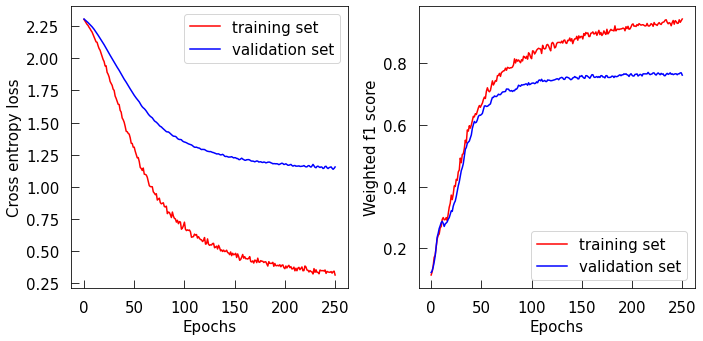

In [187]:
archi = ((8000, 80), (80, 80))
model = Feedforward_deeper_drop(Feedforward_block_drop_bn, archi, 10, 0.1)
epochs = 1000

training_overview_multi_classes_imbalanced_wd_early_batch_Adam_scaled_input(model,
                                                                            epochs,
                                                                            X_train_subcell_ready,
                                                                            y_train_subcell_ready,
                                                                            X_val_subcell_ready,
                                                                            y_val_subcell_ready,
                                                                            0.01,
                                                                            128 * 5)

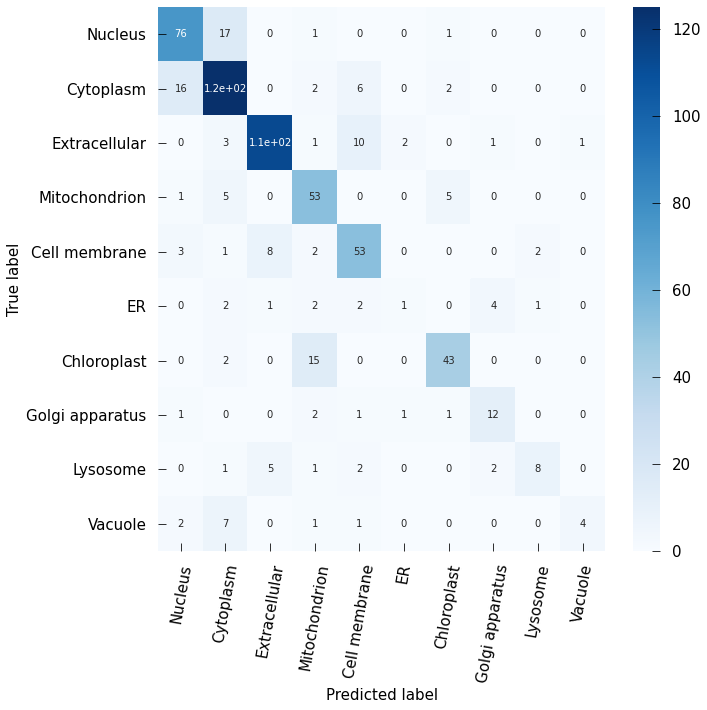

In [188]:
model.eval()

scaler_ = MinMaxScaler()
scaler_.fit(X_train_subcell_ready)

X_val_subcell_ready_scaled=torch.FloatTensor(scaler_.transform(X_val_subcell_ready))

y_pred = model(X_val_subcell_ready_scaled)
sm = torch.nn.Softmax(dim=1)
y_pred = sm(y_pred).detach().numpy()
_, y_pred = torch.max(torch.tensor(y_pred), dim=1)

confusion_mc_c = confusion_matrix(np.array(y_val_subcell_ready), y_pred)
df_cm_c = pd.DataFrame(confusion_mc_c, index=np.arange(10), columns=np.arange(10))

plt.figure(figsize=(10, 10))
ax = sns.heatmap(df_cm_c, annot=True, annot_kws={"size": 10}, cmap=plt.cm.Blues)

ax.set_xticklabels(list(dico_classes_subcell.values()), rotation=80)
ax.set_yticklabels(list(dico_classes_subcell.values()), rotation=0)

plt.ylabel('True label')
plt.xlabel('Predicted label')

plt.show()
plt.close()

# Hyperparameter optimization <a class="anchor" id="hyperopt"></a>

As you have seen in this notebook, there are many knobs to tune in deep learning. To cite a few that we looked at :

- Learning rate
- Weight decay strength
- Dropout strength
- General architecture (number of layers, initialization, normalization, optimizers, block content etc...)

Strategies to find the optimal setting for those pieces can be similar to ones used in classical machine learning:

- Trial-and-errors
- Random search in the space of hyperparameters
- Grid search

But those, strategies, and particularly the last two, can be very costly depending on the size of your network. They will require a large number of iterations. Even worse, those iterations are independant of each others so you have to perform them all.

To optimize hyperparameters, Deep Learning practicioners would generally use an algorithm for which the iterations are not independent but rather guided by the previous ones. This might even be a learning algorithm itself. And this is where one can insert a bit of extra machine learning on top of one's Deep Learning. There are hyperparameter optimizations based on Bayesian non-parametric fitting methods like Gaussian Processes, for example. We will not delve too much into the math behind such methods but you can look into it if you are really curious.

In the following exerpt we will let the batch size, the learning rate, the dropout rate, the LeakyReLU parameter and the weight decay be optimized.

In [189]:
class Feedforward_block_drop_bn_opt(torch.nn.Module):
    def __init__(self, input_size, hidden_size, dro, relu_coeff):
        super(Feedforward_block_drop_bn_opt, self).__init__()
        self.input_size = input_size
        self.dro = dro
        self.relu_coeff = relu_coeff
        self.hidden_size  = hidden_size
        self.fc = torch.nn.Linear(self.input_size, self.hidden_size)
        torch.nn.init.xavier_normal_(self.fc.weight, gain=torch.nn.init.calculate_gain('leaky_relu'))
        self.bn = torch.nn.BatchNorm1d(num_features=self.hidden_size)
        self.relu = torch.nn.LeakyReLU(self.relu_coeff)
        self.drop = torch.nn.Dropout(self.dro)
        
    def forward(self,x):
        hidden = self.fc(x)
        hidden = self.bn(hidden)
        hidden = self.drop(hidden)
        relu = self.relu(hidden)
        return relu
        
class Feedforward_deeper_drop_bn_opt(torch.nn.Module):
    def __init__(self, Feedforward_block_drop_bn_opt, archi, number_classes, dro, relu_coeff):
        super(Feedforward_deeper_drop_bn_opt, self).__init__()
        self.archi = archi
        self.dro = dro
        self.relu_coeff = relu_coeff
        self.number_classes = number_classes
        self.made_block = self._make_block(archi)
        self.output_size = archi[-1][-1]
        self.fc_out = torch.nn.Linear(self.output_size, self.number_classes)
        self.drop = torch.nn.Dropout(self.dro)
       
    def forward(self, x):
        x = self.made_block(x)
        output = self.fc_out(x)
        output = self.drop(output)
        return output
    
    def _make_block(self, archi):
        layers = []
        for i in range(len(archi)):
            layers.append(Feedforward_block_drop_bn_opt(archi[i][0], archi[i][1], self.dro, self.relu_coeff))
        return torch.nn.Sequential(*layers)

We will use the `hyperopt` library which, as you will see, uses a dictionnary for definning the hyperparameter space.

In [190]:
space = hp.choice('optimized_FFN', [{'dro': hp.uniform('drop_out_rate', 0, 0.1), 
                                     'relu_coeff': hp.uniform('relu_coefficient', 0, 0.5), 
                                     'wd': hp.uniform('weight_decay', 0.0001, 0.01),
                                     'batch_size': hp.randint('mini_batch_size', 3 * 128, 128 * 7),
                                     'l_r': hp.uniform('learning_rate', 0.0001, 0.001)}])

To find the optimal values everything other than those hyperparameters has to remain fixed. This is why the training function is slightly modified compared to what you have seen before. Moreover we would like to find the best hyperparameters in terms of F1 score for the validation set. As `hyperopt` minimizes functions, we will return the negative of the F1 score.

---

**Side note:** you usually do all this on GPUs rather than on CPUs. We will see that in the example exercices.

In [191]:
def optimized_FFN(params):
    epochs = 1000
    archi = ((8000, 80), (80, 80))
    model = Feedforward_deeper_drop_bn_opt(Feedforward_block_drop_bn_opt, archi, 10, params['dro'], params['relu_coeff'])
    
    x_train_3, y_train_3, x_val_3, y_val_3 = [X_train_subcell_ready, y_train_subcell_ready, X_val_subcell_ready, y_val_subcell_ready]
    
    scaler_ = MinMaxScaler()
    scaler_.fit(x_train_3)
    
    x_train_3 = torch.FloatTensor(scaler_.transform(x_train_3))
    x_val_3 = torch.FloatTensor(scaler_.transform(x_val_3))
    
    w = compute_class_weight('balanced', np.unique(y_train_3), np.array(y_train_3))
    weights_classes = torch.tensor(w, dtype=torch.float32)
    print('weights_classes', weights_classes)
    
    loss_fn = torch.nn.CrossEntropyLoss(weight=weights_classes)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=params['l_r'], weight_decay=params['wd'])
    
    keep_loss=[]
    keep_loss_val=[]
    keep_score=[]
    keep_score_val=[]
    for epoch in range(epochs):
        losses = []
        f1s = []
        losses_val = []
        f1s_val = []
        model.train()
        for d in range(0, len(x_train_3), params['batch_size']):
            optimizer.zero_grad()

            # Forward pass
            output_train = model(x_train_3[d:min(d + params['batch_size'], len(x_train_3) - 1)])

            # Compute Score
            sm = torch.nn.Softmax(dim=1)
            _, y_pred_train = torch.max(torch.tensor(sm(output_train).detach().numpy().tolist()), dim=1)
            
            # Compute Loss
            loss = loss_fn(output_train.squeeze(), y_train_3[d:min(d + params['batch_size'], len(x_train_3) - 1)])
            
            f1_train = metrics.f1_score(y_train_3[d:min(d + params['batch_size'], len(x_train_3) - 1)], y_pred_train, average='weighted')
            
            # Backward pass
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            
            losses.append(loss.item())
            f1s.append(f1_train.item())
            
        model.eval()
        with torch.no_grad():
            for d in range(0, len(x_val_3), params['batch_size']):
                output_val = model(x_val_3[d:min(d + params['batch_size'], len(x_val_3) - 1)])
                sm = torch.nn.Softmax(dim=1)
                _, y_pred_val = torch.max(torch.tensor(sm(output_val).detach().numpy().tolist()), dim=1)
                f1_val = metrics.f1_score(y_val_3[d:min(d + params['batch_size'], len(x_val_3) - 1)], y_pred_val, average='weighted')
                loss_val = loss_fn(output_val.squeeze(), y_val_3[d:min(d + params['batch_size'], len(x_val_3) - 1)])
                losses_val.append(loss_val.item())
                f1s_val.append(f1_val.item())
            
        keep_loss.append(np.mean(losses))
        keep_loss_val.append(np.mean(losses_val))
        keep_score.append(np.mean(f1s))
        keep_score_val.append(np.mean(f1s_val))
        
        if epoch % 100 == 0:
            print('Epoch {}: train loss: {} validation loss: {}\ntrain f1: {} validation f1: {}'.format(epoch, 
                                                                                                        keep_loss[-1],
                                                                                                        keep_loss_val[-1],
                                                                                                        keep_score[-1],
                                                                                                        keep_score_val[-1]))
        if epoch == epochs - 1:
            print('Epoch {}: train loss: {} validation loss: {}train f1: {} validation f1: {}'.format(epoch, 
                                                                                                      keep_loss[-1],
                                                                                                      keep_loss_val[-1],
                                                                                                      keep_score[-1],
                                                                                                      keep_score_val[-1]))
        
        if (epoch > 100) and (keep_score_val[-1] < keep_score_val[-2] - 2 * np.std(keep_score_val[-50:-1])):
            print('Final', epoch, keep_score_val[-1], keep_score_val[-2] - np.std(keep_score_val[-100:-1]))
            print('Params', params)
            break
            
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    
    ax[0].plot(np.arange(len(keep_loss)), keep_loss, 'r', label='training set')
    ax[0].plot(np.arange(len(keep_loss)), keep_loss_val, 'b', label='validation set')
    
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Cross entropy loss')
    ax[0].legend(loc='best')
    
    ax[1].plot(np.arange(len(keep_loss)), keep_score, 'r', label='training set')
    ax[1].plot(np.arange(len(keep_loss)), keep_score_val, 'b', label='validation set')
    
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Weighted f1 score')
    ax[1].legend(loc='best')
    
    plt.tight_layout()
    plt.show()
    
    return -keep_score_val[-1]

We will use the [Tree-structured Parzen Estimator (TPE)](https://papers.nips.cc/paper/2011/file/86e8f7ab32cfd12577bc2619bc635690-Paper.pdf) as our solver. We could have used grid-search, random-search, or Gaussian Processes as well. But TPE is the default one, and is a Bayesian estimator, so let's stick with it.

weights_classes                                       
tensor([0.7169, 0.4273, 0.4529, 1.0399, 0.8502, 3.8460, 1.0817, 4.1068, 4.0383,
        4.1068])
Epoch 0: train loss: 2.2066744565963745 validation loss: 2.1963143348693848
train f1: 0.1707034345413522 validation f1: 0.21389344840111585
Epoch 100: train loss: 0.061871444806456566 validation loss: 1.4594857692718506
train f1: 0.9831183586731391 validation f1: 0.7368325632561812
Final                                                 
124                                                   
0.7358473194727955                                    
0.74377635383198                                      
Params                                                
{'batch_size': 759, 'dro': 0.07750103772305533, 'l_r': 0.0007916661839646328, 'relu_coeff': 0.43832994583884727, 'wd': 0.00038825804872881313}
  0%|          | 0/50 [00:06<?, ?trial/s, best loss=?]

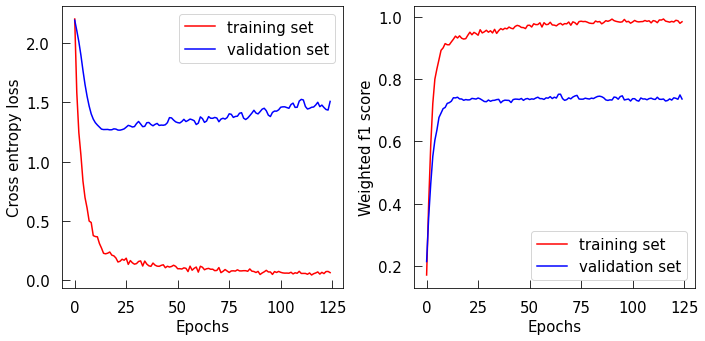

weights_classes                                                                  
tensor([0.7169, 0.4273, 0.4529, 1.0399, 0.8502, 3.8460, 1.0817, 4.1068, 4.0383,  
        4.1068])
Epoch 0: train loss: 2.314148759841919 validation loss: 2.2706258296966553       
train f1: 0.12388335753830146 validation f1: 0.05492635960926383
Epoch 100: train loss: 0.07704565674066544 validation loss: 1.351905882358551    
train f1: 0.9875470667360409 validation f1: 0.7210436738314272
Final                                                                            
108                                                                              
0.7313919340552817                                                               
0.7181441733950946                                                               
Params                                                                           
{'batch_size': 496, 'dro': 0.058567664420581034, 'l_r': 0.00029653585409818487, 'relu_coeff': 0.1619910678403889, 'wd

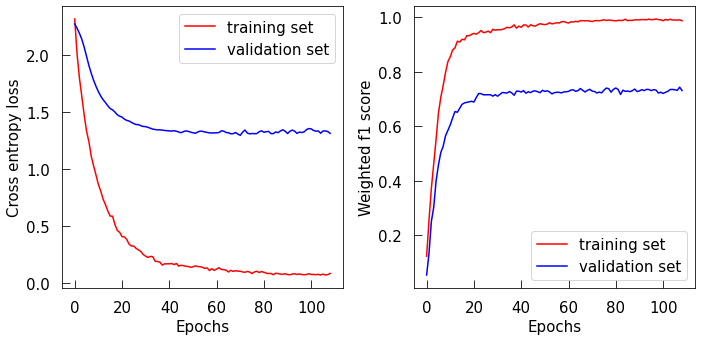

weights_classes                                                                  
tensor([0.7169, 0.4273, 0.4529, 1.0399, 0.8502, 3.8460, 1.0817, 4.1068, 4.0383,  
        4.1068])
Epoch 0: train loss: 2.39982016881307 validation loss: 2.2992570400238037        
train f1: 0.07933084679707966 validation f1: 0.059887705076008615
Epoch 100: train loss: 0.22511393825213113 validation loss: 1.4040623903274536   
train f1: 0.9661694549399829 validation f1: 0.6922623131727301
Final                                                                            
124                                                                              
0.6950147194727306                                                               
0.6595846112530631                                                               
Params                                                                           
{'batch_size': 405, 'dro': 0.09936645891675697, 'l_r': 0.00010599438582922427, 'relu_coeff': 0.031605389676400863, '

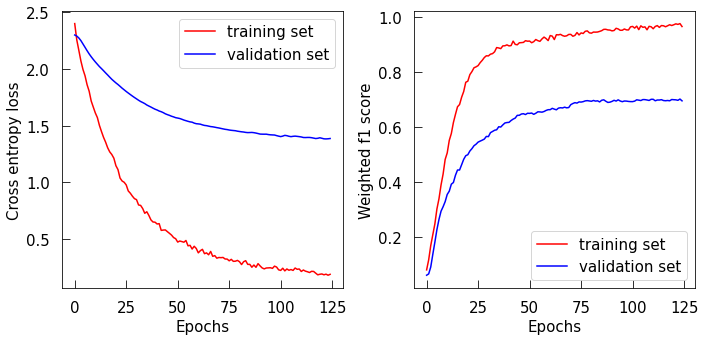

weights_classes                                                                  
tensor([0.7169, 0.4273, 0.4529, 1.0399, 0.8502, 3.8460, 1.0817, 4.1068, 4.0383,  
        4.1068])
Epoch 0: train loss: 2.161914587020874 validation loss: 2.1937531232833862       
train f1: 0.1904261763631375 validation f1: 0.17420367091728248
Epoch 100: train loss: 0.0525552049279213 validation loss: 1.3735885620117188    
train f1: 0.9950286885006276 validation f1: 0.711913154629206
Final                                                                            
106                                                                              
0.5401534084235801                                                               
0.681460271356749                                                                
Params                                                                           
{'batch_size': 490, 'dro': 0.03559598233433804, 'l_r': 0.000783990866814905, 'relu_coeff': 0.4326326906442035, 'wd': 0.

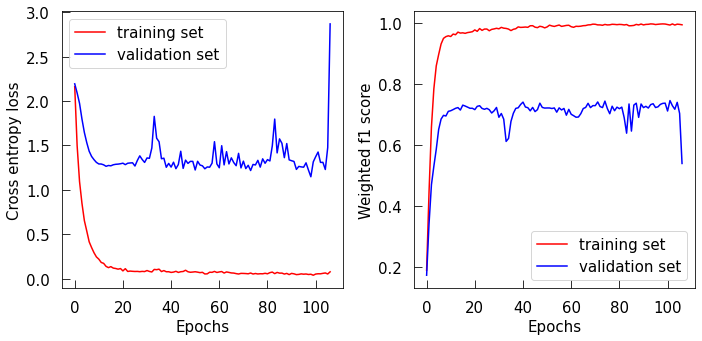

weights_classes                                                                  
tensor([0.7169, 0.4273, 0.4529, 1.0399, 0.8502, 3.8460, 1.0817, 4.1068, 4.0383,  
        4.1068])
Epoch 0: train loss: 2.2209341526031494 validation loss: 2.223154067993164       
train f1: 0.17286649588386718 validation f1: 0.07506435958354
Epoch 100: train loss: 0.05062048261364301 validation loss: 1.2083348035812378   
train f1: 0.9988606130552893 validation f1: 0.7513609255418968
Final                                                                            
144                                                                              
0.5696878437035985                                                               
0.5974267568956203                                                               
Params                                                                           
{'batch_size': 873, 'dro': 0.02086434260181316, 'l_r': 0.0008669221123187817, 'relu_coeff': 0.3878667378875091, 'wd': 0.

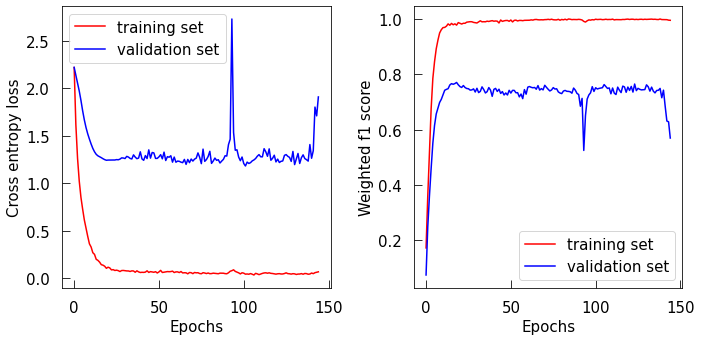

weights_classes                                                                  
tensor([0.7169, 0.4273, 0.4529, 1.0399, 0.8502, 3.8460, 1.0817, 4.1068, 4.0383,  
        4.1068])
Epoch 0: train loss: 2.2222942113876343 validation loss: 2.2353954315185547      
train f1: 0.17167467956563628 validation f1: 0.047722539969904276
Epoch 100: train loss: 0.07125572022050619 validation loss: 1.210943579673767    
train f1: 0.9927113920408647 validation f1: 0.7540702400195884
Final                                                                            
134                                                                              
0.64167550567647                                                                 
0.7161518068205295                                                               
Params                                                                           
{'batch_size': 741, 'dro': 0.026404038386786066, 'l_r': 0.0005160605550672875, 'relu_coeff': 0.35478429173715426, 'w

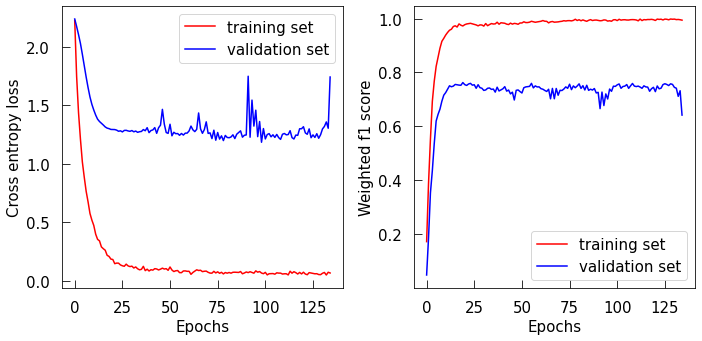

weights_classes                                                                  
tensor([0.7169, 0.4273, 0.4529, 1.0399, 0.8502, 3.8460, 1.0817, 4.1068, 4.0383,  
        4.1068])
Epoch 0: train loss: 2.390223264694214 validation loss: 2.279958486557007        
train f1: 0.09546289876676552 validation f1: 0.05455302357844756
Epoch 100: train loss: 0.1510787159204483 validation loss: 1.3067179918289185    
train f1: 0.9544321939441408 validation f1: 0.7240880466653978
Final                                                                            
108                                                                              
0.7179190822815062                                                               
0.6961002598275755                                                               
Params                                                                           
{'batch_size': 834, 'dro': 0.08619487481778165, 'l_r': 0.0002928848922037848, 'relu_coeff': 0.49788327983657826, 'wd'

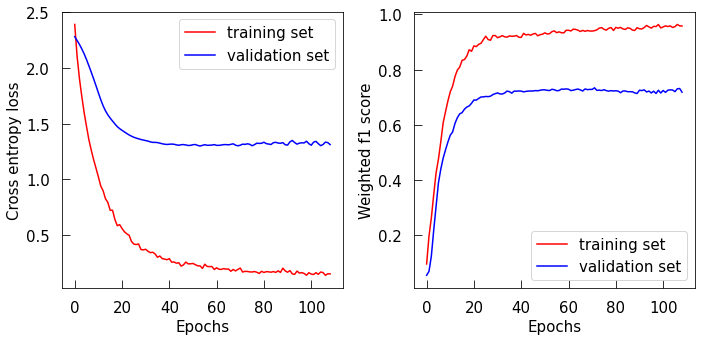

weights_classes                                                                  
tensor([0.7169, 0.4273, 0.4529, 1.0399, 0.8502, 3.8460, 1.0817, 4.1068, 4.0383,  
        4.1068])
Epoch 0: train loss: 2.2134938836097717 validation loss: 2.228642225265503       
train f1: 0.16321536275762571 validation f1: 0.15986249758353097
Epoch 100: train loss: 0.04188547097146511 validation loss: 1.1551562547683716   
train f1: 0.9990353029948439 validation f1: 0.7481072261986826
Final                                                                            
111                                                                              
0.7028879811825613                                                               
0.7150202925292316                                                               
Params                                                                           
{'batch_size': 666, 'dro': 0.026947072035118258, 'l_r': 0.0008286208864180976, 'relu_coeff': 0.2037620846904752, 'wd'

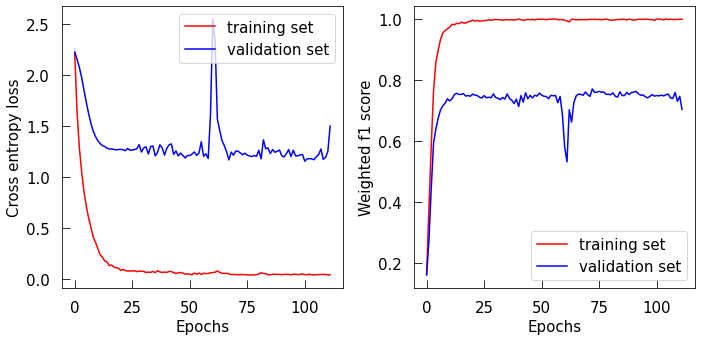

weights_classes                                                                  
tensor([0.7169, 0.4273, 0.4529, 1.0399, 0.8502, 3.8460, 1.0817, 4.1068, 4.0383,  
        4.1068])
Epoch 0: train loss: 2.3469056487083435 validation loss: 2.287153959274292       
train f1: 0.17357792190247437 validation f1: 0.17735636879939032
Epoch 100: train loss: 0.07771513983607292 validation loss: 1.4017025232315063   
train f1: 0.9945841344122204 validation f1: 0.7331102525520142
Final                                                                            
149                                                                              
0.7301452626950026                                                               
0.7290011034687577                                                               
Params                                                                           
{'batch_size': 686, 'dro': 0.04855824069179202, 'l_r': 0.00028934496257923423, 'relu_coeff': 0.04425805463952359, 'wd

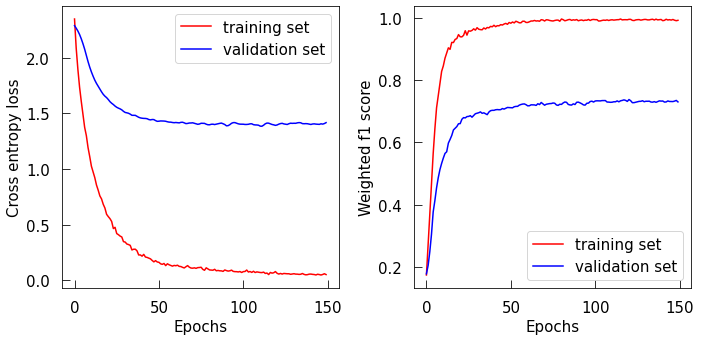

weights_classes                                                                  
tensor([0.7169, 0.4273, 0.4529, 1.0399, 0.8502, 3.8460, 1.0817, 4.1068, 4.0383,  
        4.1068])
Epoch 0: train loss: 2.2588062286376953 validation loss: 2.2453067302703857      
train f1: 0.16118899311136323 validation f1: 0.06615664790321087
Epoch 100: train loss: 0.07749827951192856 validation loss: 1.1671500205993652   
train f1: 0.9949292322095162 validation f1: 0.760245866704448
Final                                                                            
114                                                                              
0.7427366512699416                                                               
0.7492451392702141                                                               
Params                                                                           
{'batch_size': 691, 'dro': 0.05169963005924799, 'l_r': 0.0005217079709480052, 'relu_coeff': 0.15200327860067103, 'wd':

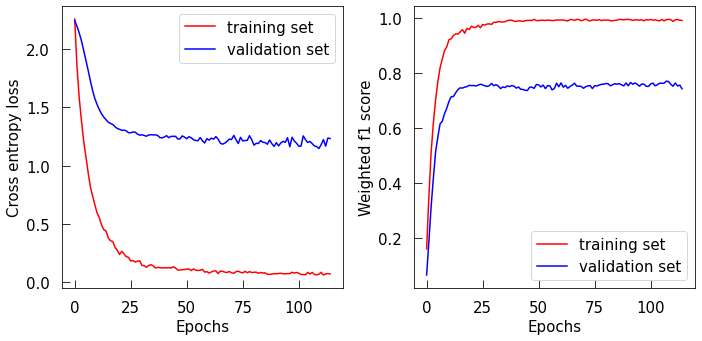

weights_classes                                                                   
tensor([0.7169, 0.4273, 0.4529, 1.0399, 0.8502, 3.8460, 1.0817, 4.1068, 4.0383,   
        4.1068])
Epoch 0: train loss: 2.293515205383301 validation loss: 2.2242714166641235        
train f1: 0.14328080734499835 validation f1: 0.1582517593825264
Epoch 100: train loss: 0.0773605838418007 validation loss: 1.3027135133743286     
train f1: 0.9929606333746701 validation f1: 0.7304191277522794
Final                                                                             
102                                                                               
0.6234764694237664                                                                
0.6830160960050425                                                                
Params                                                                            
{'batch_size': 486, 'dro': 0.056127229431485195, 'l_r': 0.0005358756994210168, 'relu_coeff': 0.41189026662621

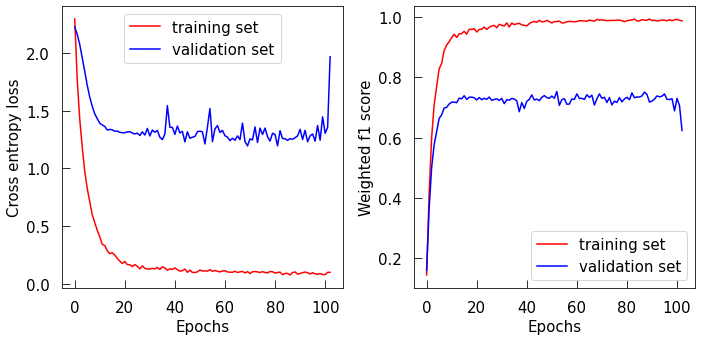

weights_classes                                                                   
tensor([0.7169, 0.4273, 0.4529, 1.0399, 0.8502, 3.8460, 1.0817, 4.1068, 4.0383,   
        4.1068])
Epoch 0: train loss: 2.3194077014923096 validation loss: 2.2726495265960693       
train f1: 0.1454446348539474 validation f1: 0.11536322420711918
Epoch 100: train loss: 0.12752686937650046 validation loss: 1.2457072734832764    
train f1: 0.9799030456270468 validation f1: 0.7620621934263302
Final                                                                             
132                                                                               
0.7444710347577678                                                                
0.7529458406423974                                                                
Params                                                                            
{'batch_size': 832, 'dro': 0.07619262707033098, 'l_r': 0.00036516442004669005, 'relu_coeff': 0.22222026510009

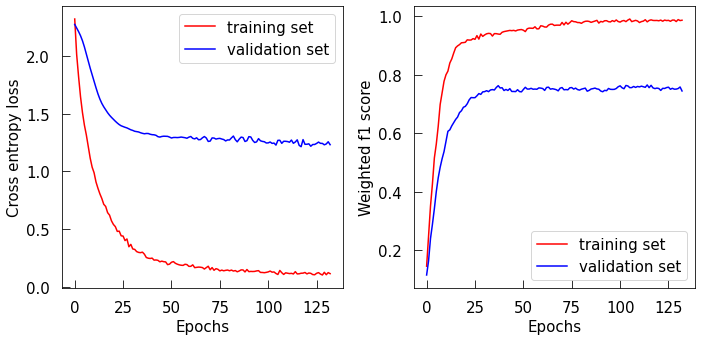

weights_classes                                                                   
tensor([0.7169, 0.4273, 0.4529, 1.0399, 0.8502, 3.8460, 1.0817, 4.1068, 4.0383,   
        4.1068])
Epoch 0: train loss: 2.2471160888671875 validation loss: 2.204102635383606        
train f1: 0.14850580272510996 validation f1: 0.1928363047054256
Epoch 100: train loss: 0.03755904957652092 validation loss: 1.4935062527656555    
train f1: 0.9986710436803706 validation f1: 0.7227544640532753
Final                                                                             
112                                                                               
0.7073034083774654                                                                
0.7343376428202046                                                                
Params                                                                            
{'batch_size': 599, 'dro': 0.02633507735467865, 'l_r': 0.000715435564352117, 'relu_coeff': 0.1466245988935161

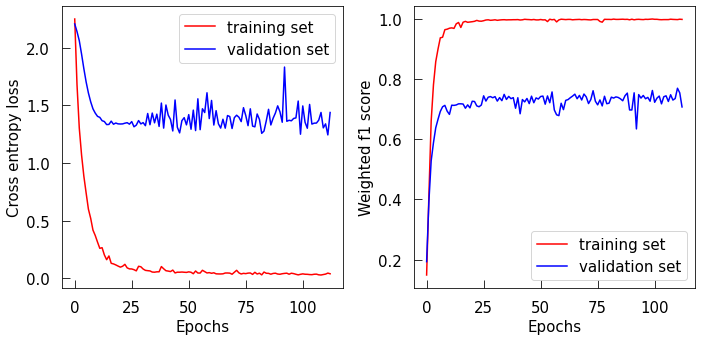

weights_classes                                                                   
tensor([0.7169, 0.4273, 0.4529, 1.0399, 0.8502, 3.8460, 1.0817, 4.1068, 4.0383,   
        4.1068])
Epoch 0: train loss: 2.339068603515625 validation loss: 2.279758334159851         
train f1: 0.10313082867054058 validation f1: 0.09543767930942235
Epoch 100: train loss: 0.11118950843811035 validation loss: 1.4222422242164612    
train f1: 0.994622157313082 validation f1: 0.7032582616218374
Final                                                                             
134                                                                               
0.6997211222993176                                                                
0.7006893617029955                                                                
Params                                                                            
{'batch_size': 485, 'dro': 0.04350899782697951, 'l_r': 0.0001617688351126302, 'relu_coeff': 0.145136982017867

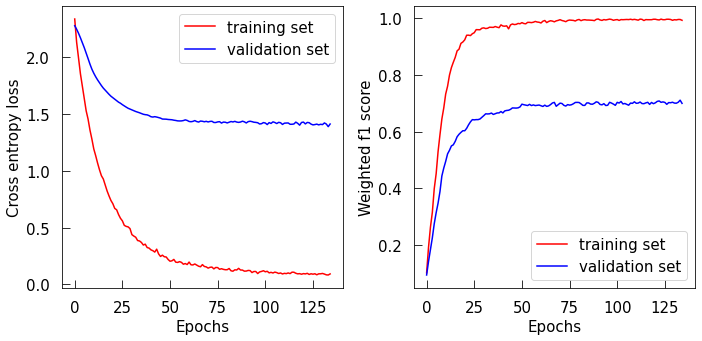

weights_classes                                                                   
tensor([0.7169, 0.4273, 0.4529, 1.0399, 0.8502, 3.8460, 1.0817, 4.1068, 4.0383,   
        4.1068])
Epoch 0: train loss: 2.2683106660842896 validation loss: 2.2538864612579346       
train f1: 0.1729964753168726 validation f1: 0.1897726755896899
Epoch 100: train loss: 0.09244478618105252 validation loss: 1.2441428303718567    
train f1: 0.9917457083291725 validation f1: 0.7557432775991269
Final                                                                             
122                                                                               
0.7109796691728817                                                                
0.7445939393914219                                                                
Params                                                                            
{'batch_size': 422, 'dro': 0.04799842078551234, 'l_r': 0.00033942124020000134, 'relu_coeff': 0.314886756050245

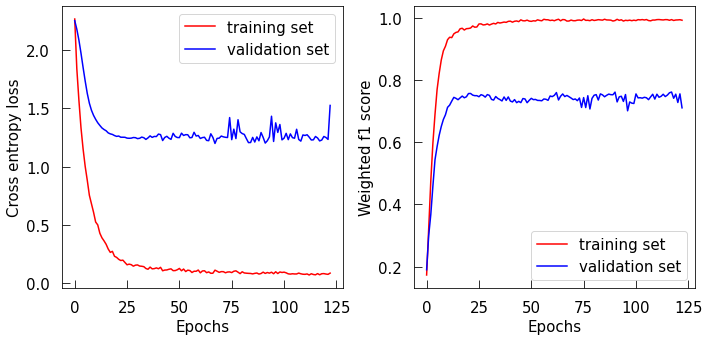

weights_classes                                                                   
tensor([0.7169, 0.4273, 0.4529, 1.0399, 0.8502, 3.8460, 1.0817, 4.1068, 4.0383,   
        4.1068])
Epoch 0: train loss: 2.246856172879537 validation loss: 2.219241499900818         
train f1: 0.15508919551529984 validation f1: 0.14117326354294818
Epoch 100: train loss: 0.0834158423046271 validation loss: 1.4224781394004822     
train f1: 0.9785488198047684 validation f1: 0.7170727616418116
Final                                                                             
114                                                                               
0.722909297968525                                                                 
0.733919953597825                                                                 
Params                                                                            
{'batch_size': 470, 'dro': 0.07491944387126087, 'l_r': 0.0004363982944834551, 'relu_coeff': 0.44944825381069

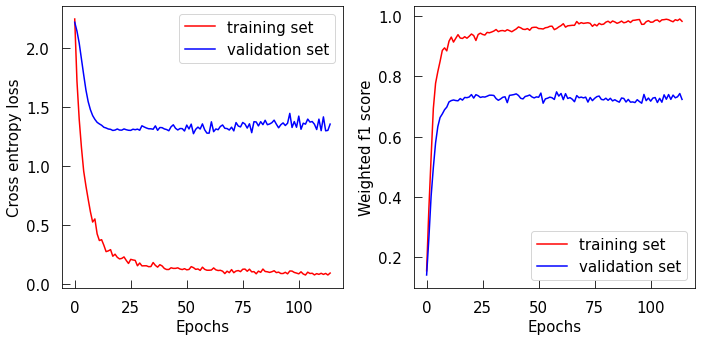

weights_classes                                                                   
tensor([0.7169, 0.4273, 0.4529, 1.0399, 0.8502, 3.8460, 1.0817, 4.1068, 4.0383,   
        4.1068])
Epoch 0: train loss: 2.275784432888031 validation loss: 2.242098808288574         
train f1: 0.163283949872116 validation f1: 0.1071537643624225
Epoch 100: train loss: 0.09867947176098824 validation loss: 1.2635064125061035    
train f1: 0.9804585575883934 validation f1: 0.7618658350742123
Final                                                                             
109                                                                               
0.7314559752679329                                                                
0.7396301628225328                                                                
Params                                                                            
{'batch_size': 730, 'dro': 0.06125214910375543, 'l_r': 0.00045534165225951637, 'relu_coeff': 0.3999983178169971

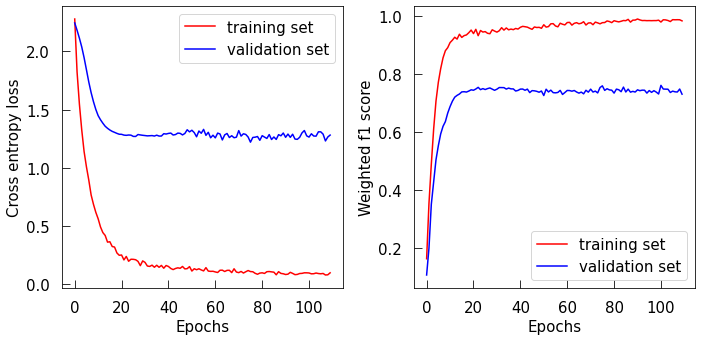

weights_classes                                                                   
tensor([0.7169, 0.4273, 0.4529, 1.0399, 0.8502, 3.8460, 1.0817, 4.1068, 4.0383,   
        4.1068])
Epoch 0: train loss: 2.1504322588443756 validation loss: 2.201209783554077        
train f1: 0.17188191912466616 validation f1: 0.18571288266309666
Epoch 100: train loss: 0.0788664584979415 validation loss: 1.6257555484771729     
train f1: 0.9949954837510616 validation f1: 0.6378359850515124
Final                                                                             
121                                                                               
0.39568352811867                                                                  
0.46088757163670857                                                               
Params                                                                            
{'batch_size': 795, 'dro': 0.01295642722212006, 'l_r': 0.0009827737413388303, 'relu_coeff': 0.38049561555098

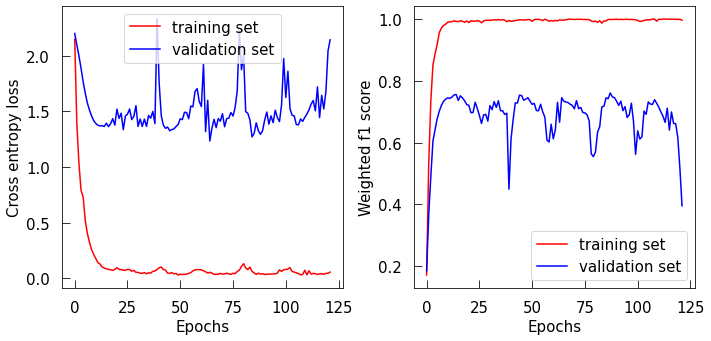

weights_classes                                                                   
tensor([0.7169, 0.4273, 0.4529, 1.0399, 0.8502, 3.8460, 1.0817, 4.1068, 4.0383,   
        4.1068])
Epoch 0: train loss: 2.316837787628174 validation loss: 2.2711565494537354        
train f1: 0.11491570185958536 validation f1: 0.07813693281231981
Epoch 100: train loss: 0.03412439301609993 validation loss: 1.2761574983596802    
train f1: 0.9984337853576024 validation f1: 0.7283045528050602
Final                                                                             
175                                                                               
0.736351781145011                                                                 
0.7405881949412148                                                                
Params                                                                            
{'batch_size': 667, 'dro': 0.004470437700748598, 'l_r': 0.0002835446787299168, 'relu_coeff': 0.0589833802069

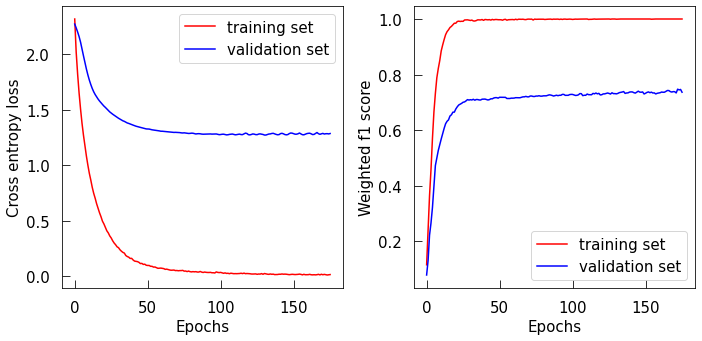

weights_classes                                                                   
tensor([0.7169, 0.4273, 0.4529, 1.0399, 0.8502, 3.8460, 1.0817, 4.1068, 4.0383,   
        4.1068])
Epoch 0: train loss: 2.237346053123474 validation loss: 2.256080150604248         
train f1: 0.16879124218191788 validation f1: 0.13153427336110723
Epoch 100: train loss: 0.06625906378030777 validation loss: 1.0103991031646729    
train f1: 0.991785958804006 validation f1: 0.8279179540996776
Final                                                                             
121                                                                               
0.7848582098939481                                                                
0.80439597535499                                                                  
Params                                                                            
{'batch_size': 615, 'dro': 0.0540161313129216, 'l_r': 0.0005807780713647196, 'relu_coeff': 0.2642109589886540

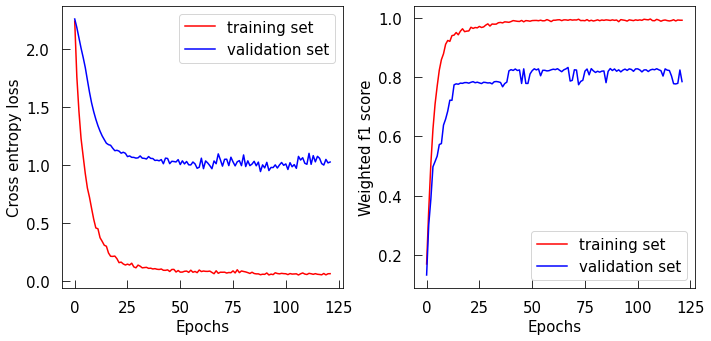

weights_classes                                                                   
tensor([0.7169, 0.4273, 0.4529, 1.0399, 0.8502, 3.8460, 1.0817, 4.1068, 4.0383,   
        4.1068])
Epoch 0: train loss: 2.2357192993164063 validation loss: 2.2051326036453247       
train f1: 0.1662761137050672 validation f1: 0.13323973682747053
Epoch 100: train loss: 0.11047977060079575 validation loss: 1.409943699836731     
train f1: 0.9694829670026138 validation f1: 0.7143577659765394
Final                                                                             
109                                                                               
0.7008411882075729                                                                
0.7215307019361102                                                                
Params                                                                            
{'batch_size': 578, 'dro': 0.09760027142662583, 'l_r': 0.0006382071786741688, 'relu_coeff': 0.279006183890127

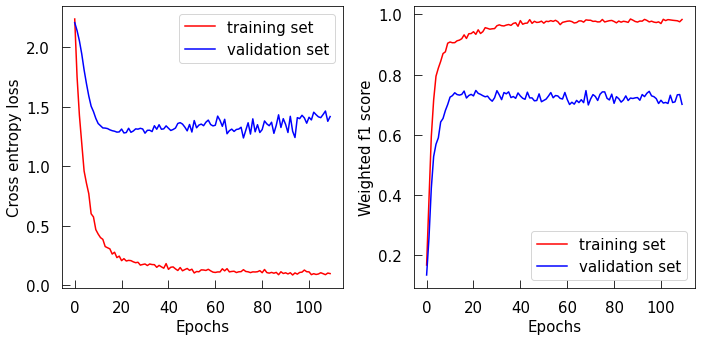

weights_classes                                                                   
tensor([0.7169, 0.4273, 0.4529, 1.0399, 0.8502, 3.8460, 1.0817, 4.1068, 4.0383,   
        4.1068])
Epoch 0: train loss: 2.269895911216736 validation loss: 2.2824116945266724        
train f1: 0.19319681970076963 validation f1: 0.1280058459945425
Epoch 100: train loss: 0.08458236698061228 validation loss: 1.009101688861847     
train f1: 0.9896107358228777 validation f1: 0.8220644107695692
Final                                                                             
107                                                                               
0.7550975934528941                                                                
0.78576609065844                                                                  
Params                                                                            
{'batch_size': 615, 'dro': 0.06786981194345776, 'l_r': 0.0006321655161557659, 'relu_coeff': 0.236106356287004

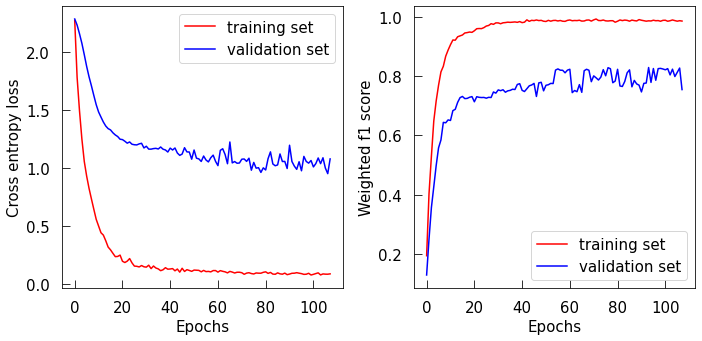

weights_classes                                                                   
tensor([0.7169, 0.4273, 0.4529, 1.0399, 0.8502, 3.8460, 1.0817, 4.1068, 4.0383,   
        4.1068])
Epoch 0: train loss: 2.23126357793808 validation loss: 2.2339096069335938         
train f1: 0.15340472534927568 validation f1: 0.12271237440678033
Epoch 100: train loss: 0.12748602777719498 validation loss: 1.7337586879730225    
train f1: 0.9826885328022632 validation f1: 0.5671439143298046
Final                                                                             
141                                                                               
0.6033760672954525                                                                
0.6817791261377009                                                                
Params                                                                            
{'batch_size': 803, 'dro': 0.06825380371445786, 'l_r': 0.0006417083864377299, 'relu_coeff': 0.27967478682652

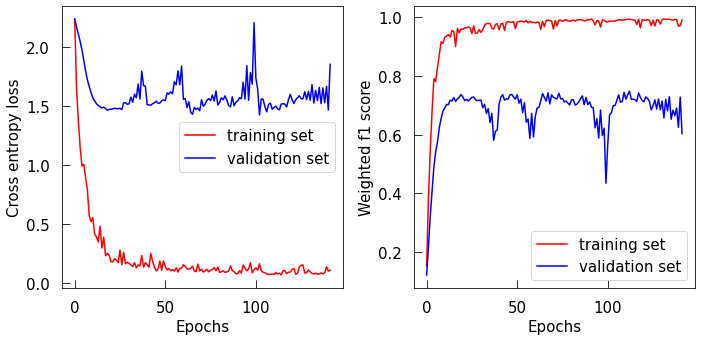

weights_classes                                                                   
tensor([0.7169, 0.4273, 0.4529, 1.0399, 0.8502, 3.8460, 1.0817, 4.1068, 4.0383,   
        4.1068])
Epoch 0: train loss: 2.271430412928263 validation loss: 2.2181671857833862        
train f1: 0.15863295380890238 validation f1: 0.15768914024157255
Epoch 100: train loss: 0.10495609665910403 validation loss: 1.3716551661491394    
train f1: 0.9785288874642296 validation f1: 0.7385377526532122
Final                                                                             
108                                                                               
0.5724487771140219                                                                
0.6758345809436577                                                                
Params                                                                            
{'batch_size': 471, 'dro': 0.08889426696962713, 'l_r': 0.0006270425721284549, 'relu_coeff': 0.31400349605158

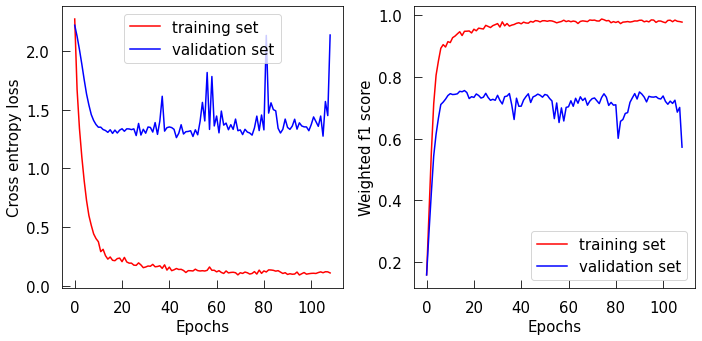

weights_classes                                                                   
tensor([0.7169, 0.4273, 0.4529, 1.0399, 0.8502, 3.8460, 1.0817, 4.1068, 4.0383,   
        4.1068])
Epoch 0: train loss: 2.3078354597091675 validation loss: 2.2586357593536377       
train f1: 0.13880368972767113 validation f1: 0.10880505655608219
Epoch 100: train loss: 0.06665914878249168 validation loss: 1.1079245805740356    
train f1: 0.9881727324760695 validation f1: 0.7554715228097189
Final                                                                             
104                                                                               
0.7553648428268411                                                                
0.7420568100011269                                                                
Params                                                                            
{'batch_size': 635, 'dro': 0.06663493757337718, 'l_r': 0.0007164401046558327, 'relu_coeff': 0.09424000210745

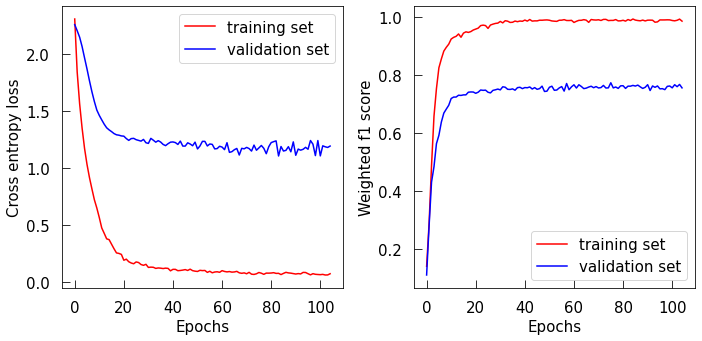

weights_classes                                                                   
tensor([0.7169, 0.4273, 0.4529, 1.0399, 0.8502, 3.8460, 1.0817, 4.1068, 4.0383,   
        4.1068])
Epoch 0: train loss: 2.2374486327171326 validation loss: 2.2319583892822266       
train f1: 0.11895840830791231 validation f1: 0.12751956133625303
Epoch 100: train loss: 0.052518817596137524 validation loss: 1.243154764175415    
train f1: 0.9931349763958265 validation f1: 0.7578273310566892
Final                                                                             
113                                                                               
0.6852442505346054                                                                
0.721717957116468                                                                 
Params                                                                            
{'batch_size': 772, 'dro': 0.03972130086283143, 'l_r': 0.0009641450848601805, 'relu_coeff': 0.11103598715293

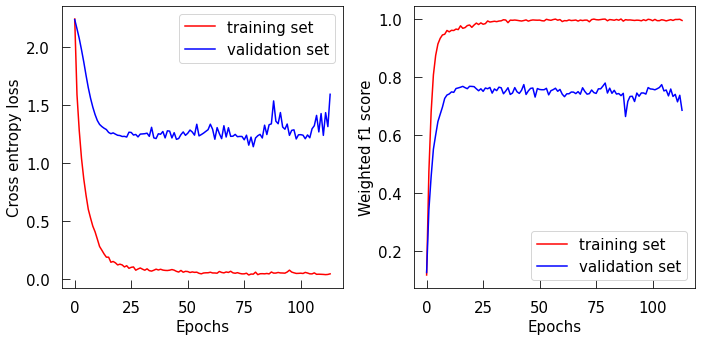

weights_classes                                                                   
tensor([0.7169, 0.4273, 0.4529, 1.0399, 0.8502, 3.8460, 1.0817, 4.1068, 4.0383,   
        4.1068])
Epoch 0: train loss: 2.2850874423980714 validation loss: 2.252338171005249        
train f1: 0.20515974131345577 validation f1: 0.12441101694774345
Epoch 100: train loss: 0.07552790567278862 validation loss: 1.5054786801338196    
train f1: 0.9850007024033001 validation f1: 0.6853806312138964
Final                                                                             
108                                                                               
0.6889225180812159                                                                
0.7103156375194992                                                                
Params                                                                            
{'batch_size': 585, 'dro': 0.08535872047585374, 'l_r': 0.0007299780091094739, 'relu_coeff': 0.00109055533800

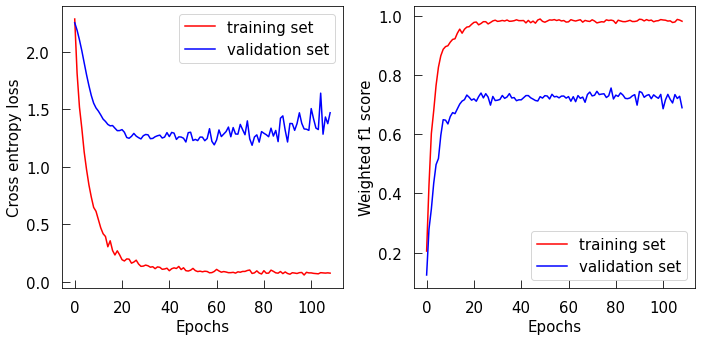

weights_classes                                                                   
tensor([0.7169, 0.4273, 0.4529, 1.0399, 0.8502, 3.8460, 1.0817, 4.1068, 4.0383,   
        4.1068])
Epoch 0: train loss: 2.227025091648102 validation loss: 2.2206718921661377        
train f1: 0.13117345902136407 validation f1: 0.2134110629213537
Epoch 100: train loss: 0.04994688089936972 validation loss: 1.3121956586837769    
train f1: 0.989100164063396 validation f1: 0.7516043124889203
Final                                                                             
115                                                                               
0.7414900959190914                                                                
0.7574706609802492                                                                
Params                                                                            
{'batch_size': 635, 'dro': 0.0643793003859898, 'l_r': 0.0009209761088445242, 'relu_coeff': 0.10378315111211651

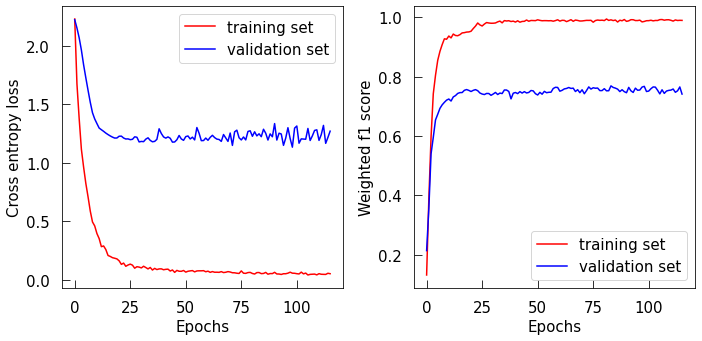

weights_classes                                                                   
tensor([0.7169, 0.4273, 0.4529, 1.0399, 0.8502, 3.8460, 1.0817, 4.1068, 4.0383,   
        4.1068])
Epoch 0: train loss: 2.2857824563980103 validation loss: 2.2962520122528076       
train f1: 0.1578916910802166 validation f1: 0.08805529044397917
Epoch 100: train loss: 0.04067087173461914 validation loss: 0.8434711694717407    
train f1: 0.9954137585829897 validation f1: 0.8780670161944968
Final                                                                             
135                                                                               
0.8729659653282462                                                                
0.8674103034641448                                                                
Params                                                                            
{'batch_size': 627, 'dro': 0.03484744730990559, 'l_r': 0.0007156932187536145, 'relu_coeff': 0.098772368297883

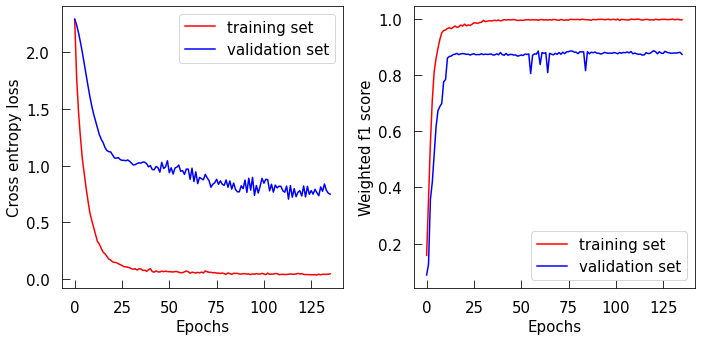

weights_classes                                                                   
tensor([0.7169, 0.4273, 0.4529, 1.0399, 0.8502, 3.8460, 1.0817, 4.1068, 4.0383,   
        4.1068])
Epoch 0: train loss: 2.2714483737945557 validation loss: 2.2483623027801514       
train f1: 0.16620036971006596 validation f1: 0.16164635164629537
Epoch 100: train loss: 0.034615464974194765 validation loss: 1.3203784227371216   
train f1: 0.9950750531203415 validation f1: 0.7360233085387319
Final                                                                             
105                                                                               
0.7321067367533832                                                                
0.7334707869726435                                                                
Params                                                                            
{'batch_size': 766, 'dro': 0.03678243667263907, 'l_r': 0.0005878601720053625, 'relu_coeff': 0.18838299091787

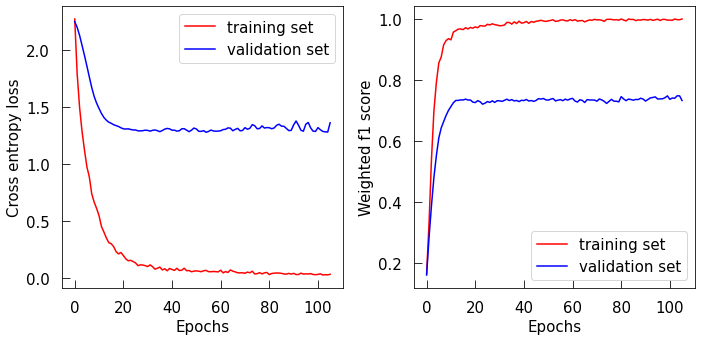

weights_classes                                                                   
tensor([0.7169, 0.4273, 0.4529, 1.0399, 0.8502, 3.8460, 1.0817, 4.1068, 4.0383,   
        4.1068])
Epoch 0: train loss: 2.306681235631307 validation loss: 2.2633590698242188        
train f1: 0.1662005847527025 validation f1: 0.2707774534584863
Epoch 100: train loss: 0.021542431165774662 validation loss: 1.3119019269943237   
train f1: 0.9996148350547712 validation f1: 0.7399786545509701
Final                                                                             
110                                                                               
0.7308123385384124                                                                
0.7218218587543284                                                                
Params                                                                            
{'batch_size': 856, 'dro': 0.003481765357314301, 'l_r': 0.00044706463035875093, 'relu_coeff': 0.26854604592279

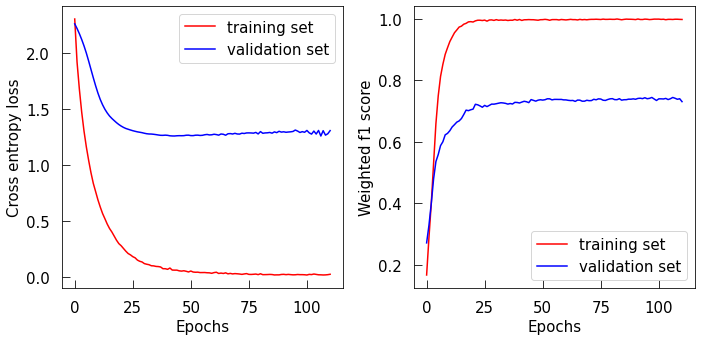

weights_classes                                                                   
tensor([0.7169, 0.4273, 0.4529, 1.0399, 0.8502, 3.8460, 1.0817, 4.1068, 4.0383,   
        4.1068])
Epoch 0: train loss: 2.1442715922991433 validation loss: 2.173110008239746        
train f1: 0.1811487534840666 validation f1: 0.13399023294692558
Epoch 100: train loss: 0.016839797142893076 validation loss: 1.3434300422668457   
train f1: 0.9990898470515517 validation f1: 0.7550294623531922
Final                                                                             
110                                                                               
0.6314388318174878                                                                
0.6749341697811576                                                                
Params                                                                            
{'batch_size': 421, 'dro': 0.012819910030457547, 'l_r': 0.0007744173181230238, 'relu_coeff': 0.33427901786084

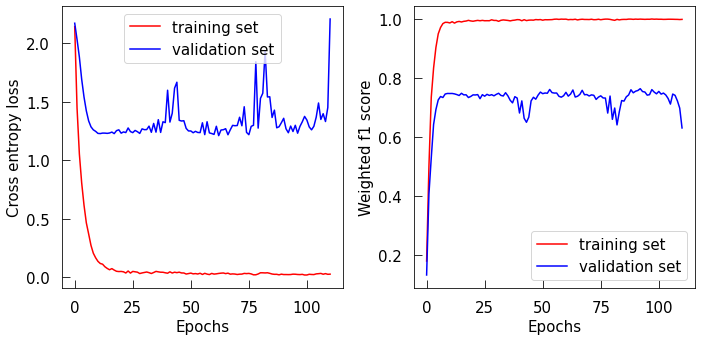

weights_classes                                                                   
tensor([0.7169, 0.4273, 0.4529, 1.0399, 0.8502, 3.8460, 1.0817, 4.1068, 4.0383,   
        4.1068])
Epoch 0: train loss: 2.2161189556121825 validation loss: 2.226117491722107        
train f1: 0.20943259518694246 validation f1: 0.18397697739341107
Epoch 100: train loss: 0.054629278182983396 validation loss: 1.4416196942329407   
train f1: 0.991465925598536 validation f1: 0.6965331122387317
Final                                                                             
120                                                                               
0.6275598820060125                                                                
0.6497647047688806                                                                
Params                                                                            
{'batch_size': 584, 'dro': 0.055780181608421665, 'l_r': 0.0008909730226427484, 'relu_coeff': 0.19854209934360

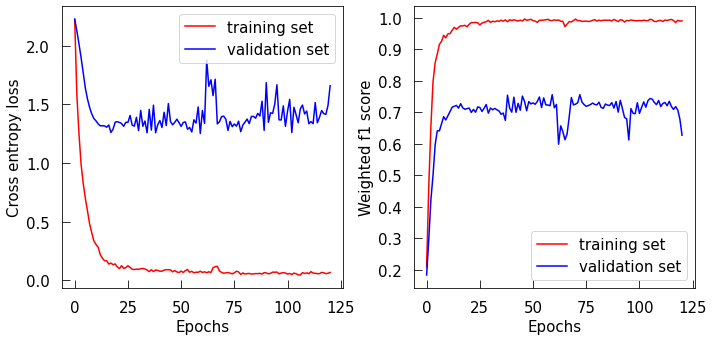

weights_classes                                                                   
tensor([0.7169, 0.4273, 0.4529, 1.0399, 0.8502, 3.8460, 1.0817, 4.1068, 4.0383,   
        4.1068])
Epoch 0: train loss: 2.3664745489756265 validation loss: 2.2947804927825928       
train f1: 0.09078322139712734 validation f1: 0.09175256966718624
Epoch 100: train loss: 0.1429325739542643 validation loss: 1.367097020149231      
train f1: 0.9912045799241714 validation f1: 0.7159412982109338
Final                                                                             
144                                                                               
0.7149082267426312                                                                
0.7121111173311433                                                                
Params                                                                            
{'batch_size': 867, 'dro': 0.031107684255581372, 'l_r': 0.00019447661440795622, 'relu_coeff': 0.012166730815

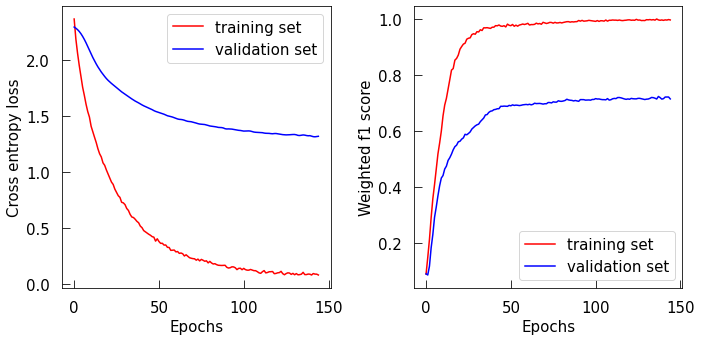

weights_classes                                                                   
tensor([0.7169, 0.4273, 0.4529, 1.0399, 0.8502, 3.8460, 1.0817, 4.1068, 4.0383,   
        4.1068])
Epoch 0: train loss: 2.2944303154945374 validation loss: 2.264538288116455        
train f1: 0.10921520201057841 validation f1: 0.07750329906682625
Epoch 100: train loss: 0.08164906315505505 validation loss: 2.0970449447631836    
train f1: 0.9803068797206109 validation f1: 0.5237454133290547
Final                                                                             
175                                                                               
0.7475124291695413                                                                
0.7362972042998001                                                                
Params                                                                            
{'batch_size': 660, 'dro': 0.012629518264092594, 'l_r': 0.0005750076024484785, 'relu_coeff': 0.0779807824750

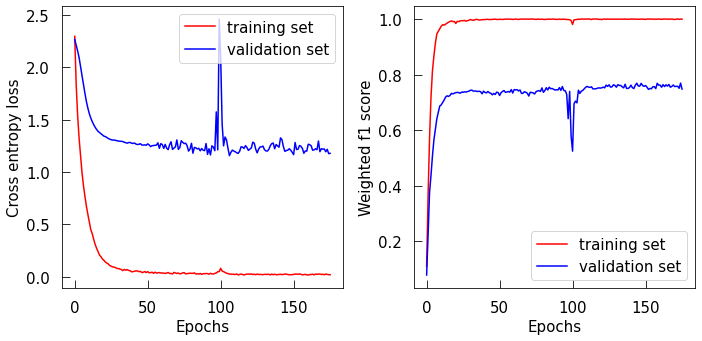

weights_classes                                                                   
tensor([0.7169, 0.4273, 0.4529, 1.0399, 0.8502, 3.8460, 1.0817, 4.1068, 4.0383,   
        4.1068])
Epoch 0: train loss: 2.225165605545044 validation loss: 2.244032859802246         
train f1: 0.1669421109523234 validation f1: 0.16947334828007418
Epoch 100: train loss: 0.03891134401783347 validation loss: 1.2601031064987183    
train f1: 0.9955916716409362 validation f1: 0.7512291666773864
Final                                                                             
112                                                                               
0.7454666442875072                                                                
0.7466093467789052                                                                
Params                                                                            
{'batch_size': 739, 'dro': 0.04300356021136639, 'l_r': 0.0006878847772415752, 'relu_coeff': 0.175147295034960

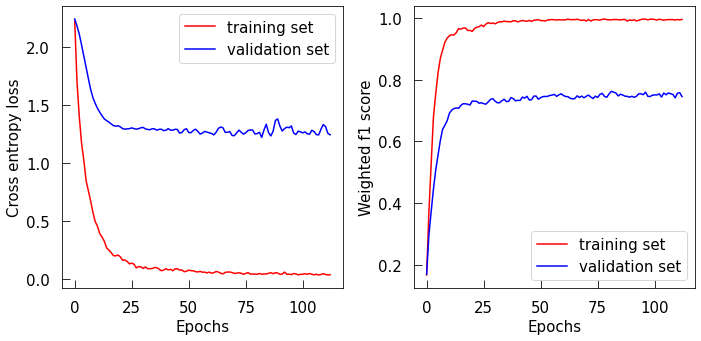

weights_classes                                                                   
tensor([0.7169, 0.4273, 0.4529, 1.0399, 0.8502, 3.8460, 1.0817, 4.1068, 4.0383,   
        4.1068])
Epoch 0: train loss: 2.1686598658561707 validation loss: 2.2221484184265137       
train f1: 0.24913180846106076 validation f1: 0.2080780471955118
Epoch 100: train loss: 0.05118156969547272 validation loss: 1.471434473991394     
train f1: 0.9987522346613992 validation f1: 0.6923296302977048
Final                                                                             
110                                                                               
0.6450912171938439                                                                
0.7023259803674087                                                                
Params                                                                            
{'batch_size': 800, 'dro': 0.020907679253799417, 'l_r': 0.0008294282680771107, 'relu_coeff': 0.26081391137247

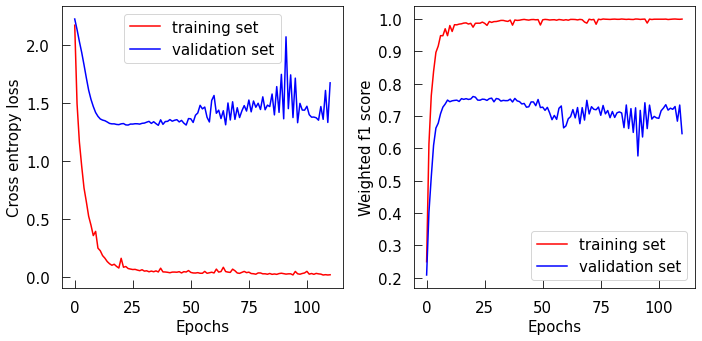

weights_classes                                                                   
tensor([0.7169, 0.4273, 0.4529, 1.0399, 0.8502, 3.8460, 1.0817, 4.1068, 4.0383,   
        4.1068])
Epoch 0: train loss: 2.211370885372162 validation loss: 2.1834957599639893        
train f1: 0.18711135096826442 validation f1: 0.20144335251406428
Epoch 100: train loss: 0.05597615148872137 validation loss: 1.3923320770263672    
train f1: 0.9955819725826381 validation f1: 0.7288434580885853
Final                                                                             
108                                                                               
0.6993646203682056                                                                
0.726094060125768                                                                 
Params                                                                            
{'batch_size': 678, 'dro': 0.034381014516061015, 'l_r': 0.0007909894476087115, 'relu_coeff': 0.4975987520284

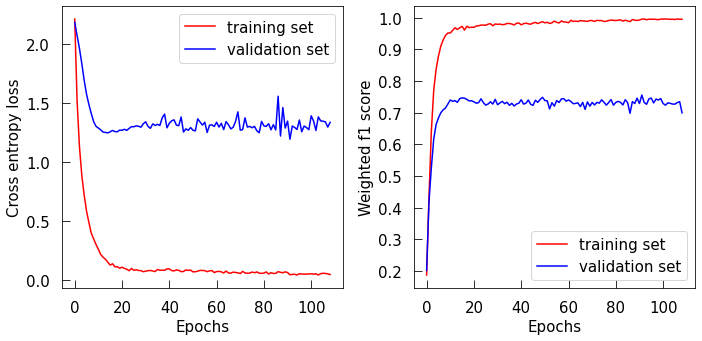

weights_classes                                                                   
tensor([0.7169, 0.4273, 0.4529, 1.0399, 0.8502, 3.8460, 1.0817, 4.1068, 4.0383,   
        4.1068])
Epoch 0: train loss: 2.27449107170105 validation loss: 2.313596487045288          
train f1: 0.16198787328018863 validation f1: 0.01590020239244221
Epoch 100: train loss: 0.0679729925468564 validation loss: 0.8315242230892181     
train f1: 0.9938163531416214 validation f1: 0.8791312074240263
Final                                                                             
104                                                                               
0.7991139580374129                                                                
0.8131742819113313                                                                
Params                                                                            
{'batch_size': 627, 'dro': 0.052223658359322814, 'l_r': 0.000504826571876138, 'relu_coeff': 0.12481467096446

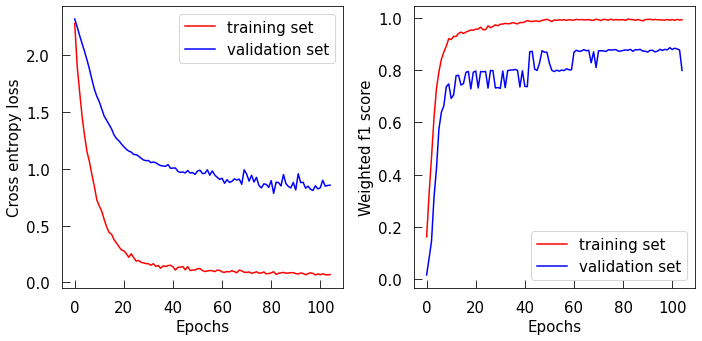

weights_classes                                                                   
tensor([0.7169, 0.4273, 0.4529, 1.0399, 0.8502, 3.8460, 1.0817, 4.1068, 4.0383,   
        4.1068])
Epoch 0: train loss: 2.2777379155158997 validation loss: 2.263885974884033        
train f1: 0.13813404060797543 validation f1: 0.18508510427473537
Epoch 100: train loss: 0.04998800344765186 validation loss: 1.2393263578414917    
train f1: 0.9980138633547986 validation f1: 0.7515462126685092
Final                                                                             
103                                                                               
0.7401115829283073                                                                
0.7058499937258734                                                                
Params                                                                            
{'batch_size': 719, 'dro': 0.019768383954816317, 'l_r': 0.00047874103055284403, 'relu_coeff': 0.038703321498

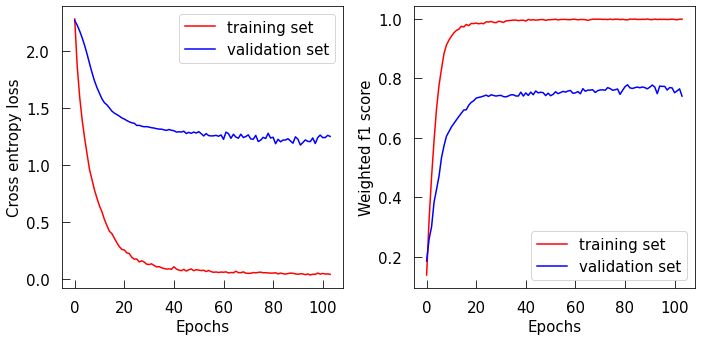

weights_classes                                                                   
tensor([0.7169, 0.4273, 0.4529, 1.0399, 0.8502, 3.8460, 1.0817, 4.1068, 4.0383,   
        4.1068])
Epoch 0: train loss: 2.2864614129066467 validation loss: 2.288845658302307        
train f1: 0.17047878989943296 validation f1: 0.08506502374189046
Epoch 100: train loss: 0.07629265170544386 validation loss: 0.8585355579853058    
train f1: 0.9950829408670789 validation f1: 0.8738552718651433
Final                                                                             
105                                                                               
0.7980091271263177                                                                
0.7693838913883295                                                                
Params                                                                            
{'batch_size': 627, 'dro': 0.045663912597346146, 'l_r': 0.0003847790371478733, 'relu_coeff': 0.1262411584860

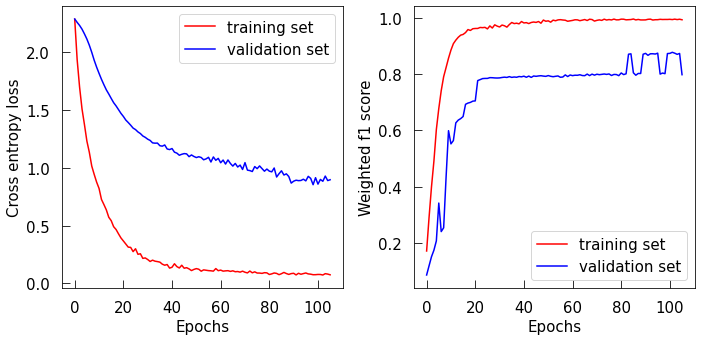

weights_classes                                                                   
tensor([0.7169, 0.4273, 0.4529, 1.0399, 0.8502, 3.8460, 1.0817, 4.1068, 4.0383,   
        4.1068])
Epoch 0: train loss: 2.3136117458343506 validation loss: 2.2799919843673706       
train f1: 0.158196552016963 validation f1: 0.12230077221982041
Epoch 100: train loss: 0.05465770047158003 validation loss: 0.8012535721063614    
train f1: 0.9971337393942068 validation f1: 0.8712165198274113
Final                                                                             
108                                                                               
0.8097902622444864                                                                
0.8334828371523069                                                                
Params                                                                            
{'batch_size': 627, 'dro': 0.030600780623087232, 'l_r': 0.0004927798641346555, 'relu_coeff': 0.078584499361695

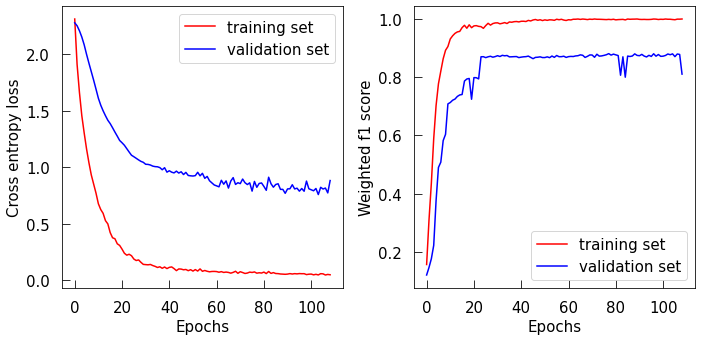

weights_classes                                                                   
tensor([0.7169, 0.4273, 0.4529, 1.0399, 0.8502, 3.8460, 1.0817, 4.1068, 4.0383,   
        4.1068])
Epoch 0: train loss: 2.328101317087809 validation loss: 2.2846014499664307        
train f1: 0.17453134424374894 validation f1: 0.05623148340952845
Epoch 100: train loss: 0.0609197790424029 validation loss: 1.2754805088043213     
train f1: 0.9967311674760652 validation f1: 0.7516638938563085
Final                                                                             
134                                                                               
0.7508327558195269                                                                
0.7535573805378497                                                                
Params                                                                            
{'batch_size': 823, 'dro': 0.03137311685070427, 'l_r': 0.00040364979349481994, 'relu_coeff': 0.0672939207361

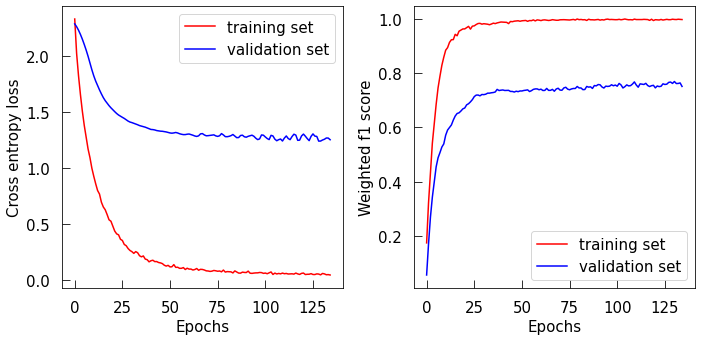

weights_classes                                                                   
tensor([0.7169, 0.4273, 0.4529, 1.0399, 0.8502, 3.8460, 1.0817, 4.1068, 4.0383,   
        4.1068])
Epoch 0: train loss: 2.32335205078125 validation loss: 2.2670962810516357         
train f1: 0.1805174532581894 validation f1: 0.12093808998356648
Epoch 100: train loss: 0.04914881512522697 validation loss: 1.3382042050361633    
train f1: 0.9993177514060619 validation f1: 0.7480567813936422
Final                                                                             
108                                                                               
0.7191523667791178                                                                
0.7246342968885509                                                                
Params                                                                            
{'batch_size': 581, 'dro': 0.018667895358399224, 'l_r': 0.00033128435684103106, 'relu_coeff': 0.0234290129321

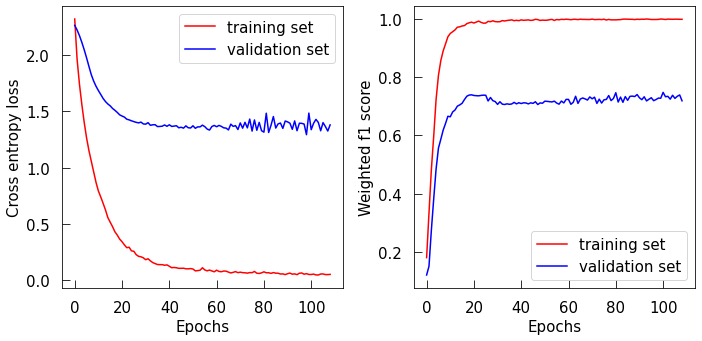

weights_classes                                                                   
tensor([0.7169, 0.4273, 0.4529, 1.0399, 0.8502, 3.8460, 1.0817, 4.1068, 4.0383,   
        4.1068])
Epoch 0: train loss: 2.329819142818451 validation loss: 2.2909579277038574        
train f1: 0.1252530452205718 validation f1: 0.12546684400238367
Epoch 100: train loss: 0.09271437488496304 validation loss: 1.403873085975647     
train f1: 0.9986524516314268 validation f1: 0.7114622798565292
Final                                                                             
172                                                                               
0.724306133878385                                                                 
0.7291562952155461                                                                
Params                                                                            
{'batch_size': 743, 'dro': 0.02673181555457807, 'l_r': 0.00019451775034083965, 'relu_coeff': 0.00196181806767

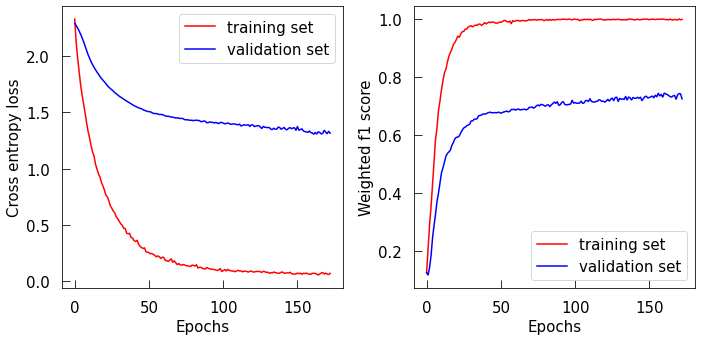

weights_classes                                                                   
tensor([0.7169, 0.4273, 0.4529, 1.0399, 0.8502, 3.8460, 1.0817, 4.1068, 4.0383,   
        4.1068])
Epoch 0: train loss: 2.398892641067505 validation loss: 2.300573468208313         
train f1: 0.10244319954471703 validation f1: 0.05794850065151393
Epoch 100: train loss: 0.10346381664276123 validation loss: 1.4538212418556213    
train f1: 0.9952192743302568 validation f1: 0.7020538322708443
Final                                                                             
165                                                                               
0.6902219208086302                                                                
0.6910518554084855                                                                
Params                                                                            
{'batch_size': 534, 'dro': 0.008579490492989193, 'l_r': 0.00010095246738219514, 'relu_coeff': 0.222439030132

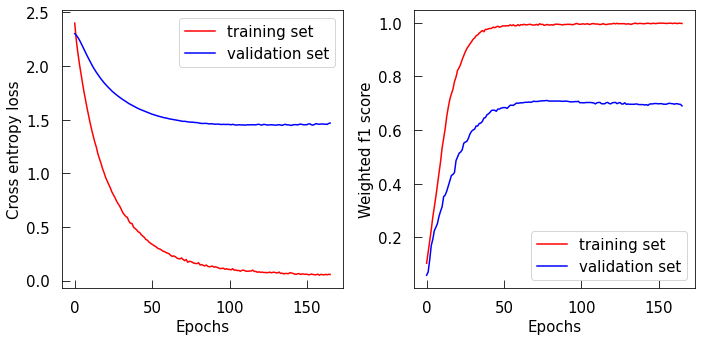

weights_classes                                                                   
tensor([0.7169, 0.4273, 0.4529, 1.0399, 0.8502, 3.8460, 1.0817, 4.1068, 4.0383,   
        4.1068])
Epoch 0: train loss: 2.186269839604696 validation loss: 2.215200424194336         
train f1: 0.15902445206225752 validation f1: 0.13719831137245414
Epoch 100: train loss: 0.03566039570917686 validation loss: 1.2940430045127869    
train f1: 0.9948797732971889 validation f1: 0.7443731871908965
Final                                                                             
131                                                                               
0.7110356474768431                                                                
0.7161339659557568                                                                
Params                                                                            
{'batch_size': 453, 'dro': 0.039538743732845466, 'l_r': 0.000752631013379749, 'relu_coeff': 0.16774050722936

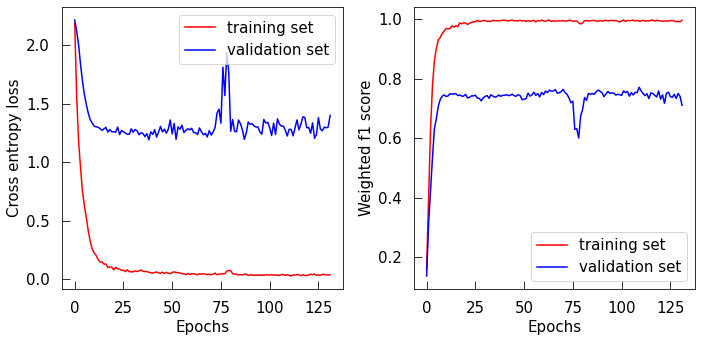

weights_classes                                                                   
tensor([0.7169, 0.4273, 0.4529, 1.0399, 0.8502, 3.8460, 1.0817, 4.1068, 4.0383,   
        4.1068])
Epoch 0: train loss: 2.2076607942581177 validation loss: 2.2191274166107178       
train f1: 0.2311599974775548 validation f1: 0.11745336140058094
Epoch 100: train loss: 0.07054891996085644 validation loss: 1.4591515064239502    
train f1: 0.9927818144128339 validation f1: 0.6911622134658049
Final                                                                             
133                                                                               
0.6432832095239571                                                                
0.6947157683228075                                                                
Params                                                                            
{'batch_size': 418, 'dro': 0.02444746415049174, 'l_r': 0.0008303225202601896, 'relu_coeff': 0.088855712527754

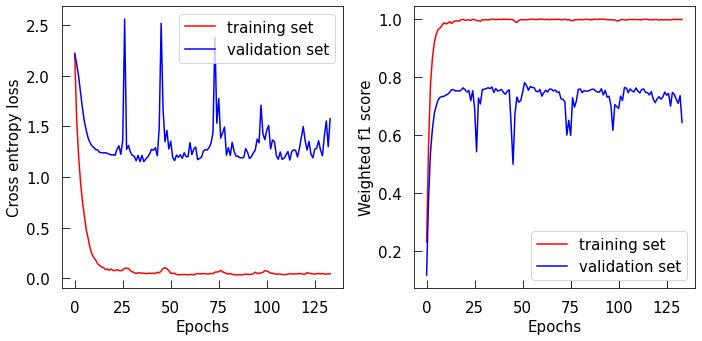

weights_classes                                                                   
tensor([0.7169, 0.4273, 0.4529, 1.0399, 0.8502, 3.8460, 1.0817, 4.1068, 4.0383,   
        4.1068])
Epoch 0: train loss: 2.282339096069336 validation loss: 2.251826524734497         
train f1: 0.150405502690681 validation f1: 0.0800235428684125
Epoch 100: train loss: 0.05383661948144436 validation loss: 1.222341537475586     
train f1: 0.9894311222494206 validation f1: 0.768684448811427
Final                                                                             
136                                                                               
0.7667424854576257                                                                
0.7749351278985599                                                                
Params                                                                            
{'batch_size': 642, 'dro': 0.06051300804343291, 'l_r': 0.0006686769717558852, 'relu_coeff': 0.041612514950278005

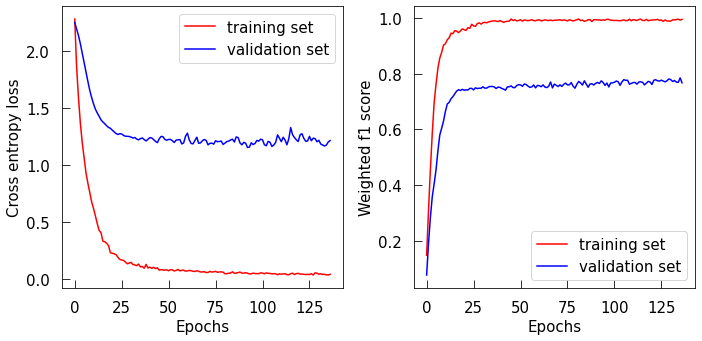

weights_classes                                                                   
tensor([0.7169, 0.4273, 0.4529, 1.0399, 0.8502, 3.8460, 1.0817, 4.1068, 4.0383,   
        4.1068])
Epoch 0: train loss: 2.2574654817581177 validation loss: 2.244829297065735        
train f1: 0.14957521301294158 validation f1: 0.10822070309444261
Epoch 100: train loss: 0.02546469308435917 validation loss: 1.420713722705841     
train f1: 0.9964539528341697 validation f1: 0.7467761530717646
Final                                                                             
198                                                                               
0.7438981609467712                                                                
0.749730931041358                                                                 
Params                                                                            
{'batch_size': 445, 'dro': 0.03144960212113063, 'l_r': 0.0005431595498622801, 'relu_coeff': 0.13161895631711

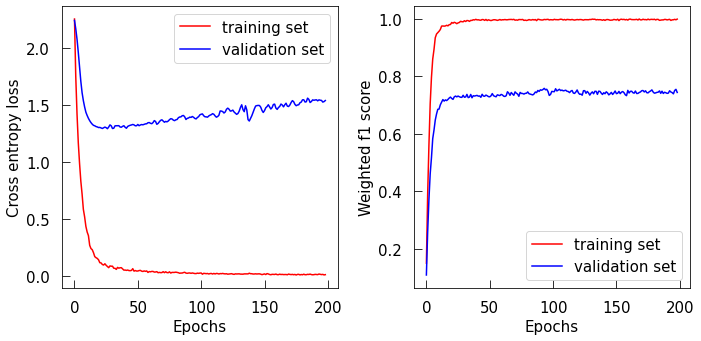

100%|██████████| 50/50 [05:48<00:00,  6.97s/trial, best loss: -0.8729659653282462]
{'drop_out_rate': 0.03484744730990559, 'learning_rate': 0.0007156932187536145, 'mini_batch_size': 627, 'optimized_FFN': 0, 'relu_coefficient': 0.09877236829788345, 'weight_decay': 0.003471841616520645}


In [192]:
# This takes a few minutes
best = fmin(optimized_FFN, space, algo=tpe.suggest, max_evals=50)
print(best)

And here you have your optimal hyperparameters

In [193]:
print(hyperopt.space_eval(space, best))

{'batch_size': 627, 'dro': 0.03484744730990559, 'l_r': 0.0007156932187536145, 'relu_coeff': 0.09877236829788345, 'wd': 0.003471841616520645}


We need to retrain the model with the optimal hyperparameters we just found (or we could have saved the best model while searching for them to begin with...)

In [194]:
def optimized_FFN_show(params):
    epochs = 1000
    archi = ((8000, 80), (80, 10))
    model = Feedforward_deeper_drop_bn_opt(Feedforward_block_drop_bn_opt, archi, 10, params['dro'], params['relu_coeff'])
    
    x_train_3, y_train_3, x_val_3, y_val_3 = [X_train_subcell_ready, y_train_subcell_ready, X_val_subcell_ready, y_val_subcell_ready]
    
    scaler_ = MinMaxScaler()
    scaler_.fit(x_train_3)
    
    x_train_3 = torch.FloatTensor(scaler_.transform(x_train_3))
    x_val_3 = torch.FloatTensor(scaler_.transform(x_val_3))
    
    w = compute_class_weight('balanced', np.unique(y_train_3), np.array(y_train_3))
    weights_classes = torch.tensor(w, dtype=torch.float32)
    print('weights_classes',weights_classes)
    
    loss_fn = torch.nn.CrossEntropyLoss(weight=weights_classes)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=params['l_r'],weight_decay=params['wd'])
    
    keep_loss=[]
    keep_loss_val=[]
    keep_score=[]
    keep_score_val=[]
    for epoch in range(epochs):
        losses = []
        f1s = []
        losses_val = []
        f1s_val = []
        model.train()
        for d in range(0, len(x_train_3), params['batch_size']):
            optimizer.zero_grad()

            # Forward pass
            output_train = model(x_train_3[d:min(d + params['batch_size'], len(x_train_3) - 1)])

            # Compute Score
            sm = torch.nn.Softmax(dim=1)
            _, y_pred_train = torch.max(torch.tensor(sm(output_train).detach().numpy().tolist()), dim=1)
            
            # Compute Loss
            loss = loss_fn(output_train.squeeze(), y_train_3[d:min(d + params['batch_size'], len(x_train_3) - 1)])
            
            f1_train = metrics.f1_score(y_train_3[d:min(d + params['batch_size'], len(x_train_3) - 1)], y_pred_train, average='weighted')
            
            # Backward pass
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            
            losses.append(loss.item())
            f1s.append(f1_train.item())
            
        model.eval()
        with torch.no_grad():
            for d in range(0, len(x_val_3), params['batch_size']):
                output_val = model(x_val_3[d:min(d + params['batch_size'], len(x_val_3) - 1)])
                sm = torch.nn.Softmax(dim=1)
                _, y_pred_val = torch.max(torch.tensor(sm(output_val).detach().numpy().tolist()), dim=1)
                f1_val = metrics.f1_score(y_val_3[d:min(d + params['batch_size'], len(x_val_3) - 1)], y_pred_val, average='weighted')
                loss_val = loss_fn(output_val.squeeze(), y_val_3[d:min(d + params['batch_size'], len(x_val_3) - 1)])
                losses_val.append(loss_val.item())
                f1s_val.append(f1_val.item())
            
        keep_loss.append(np.mean(losses))
        keep_loss_val.append(np.mean(losses_val))
        keep_score.append(np.mean(f1s))
        keep_score_val.append(np.mean(f1s_val))
        
        if epoch % 100 == 0:
            print('Epoch {}: train loss: {} validation loss: {}\ntrain f1: {} validation f1: {}'.format(epoch, 
                                                                                                        keep_loss[-1],
                                                                                                        keep_loss_val[-1],
                                                                                                        keep_score[-1],
                                                                                                        keep_score_val[-1]))
        if epoch == epochs - 1:
            print('Epoch {}: train loss: {} validation loss: {}train f1: {} validation f1: {}'.format(epoch, 
                                                                                                      keep_loss[-1],
                                                                                                      keep_loss_val[-1],
                                                                                                      keep_score[-1],
                                                                                                      keep_score_val[-1]))
        
        if (epoch > 100) and (keep_score_val[-1] < keep_score_val[-2] - 2 * np.std(keep_score_val[-50:-1])):
#             print(epoch, keep_score_val[-1], keep_score_val[-2] - np.std(keep_score_val[-100:-1]))
            break
            
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    
    ax[0].plot(np.arange(len(keep_loss)), keep_loss, 'r', label='training set')
    ax[0].plot(np.arange(len(keep_loss)), keep_loss_val, 'b', label='validation set')
    
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Cross entropy loss')
    ax[0].legend(loc='best')
    
    ax[1].plot(np.arange(len(keep_loss)), keep_score, 'r',label='training set')
    ax[1].plot(np.arange(len(keep_loss)), keep_score_val, 'b', label='validation set')
    
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Weighted f1 score')
    ax[1].legend(loc='best')
    
    plt.tight_layout()
    plt.show()
    
    return model

weights_classes tensor([0.7169, 0.4273, 0.4529, 1.0399, 0.8502, 3.8460, 1.0817, 4.1068, 4.0383,
        4.1068])
Epoch 0: train loss: 2.290055274963379 validation loss: 2.3155447244644165
train f1: 0.07935238016051163 validation f1: 0.06223985836570007
Epoch 100: train loss: 0.2850303277373314 validation loss: 1.1255280375480652
train f1: 0.9724844439917028 validation f1: 0.8665855427052251


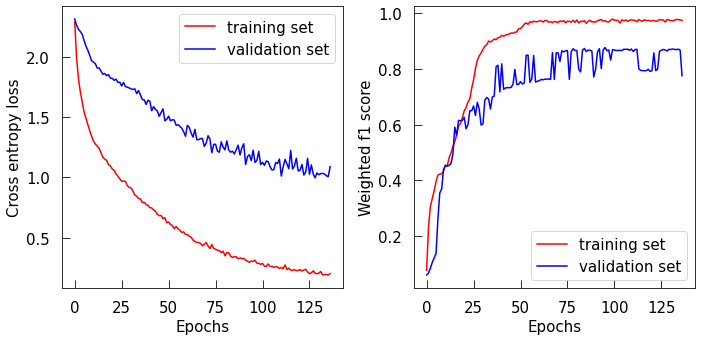

In [195]:
model = optimized_FFN_show(hyperopt.space_eval(space, best))

Well, that was quite a gain in F1 score and loss parformance compared to our wild guesses from before.

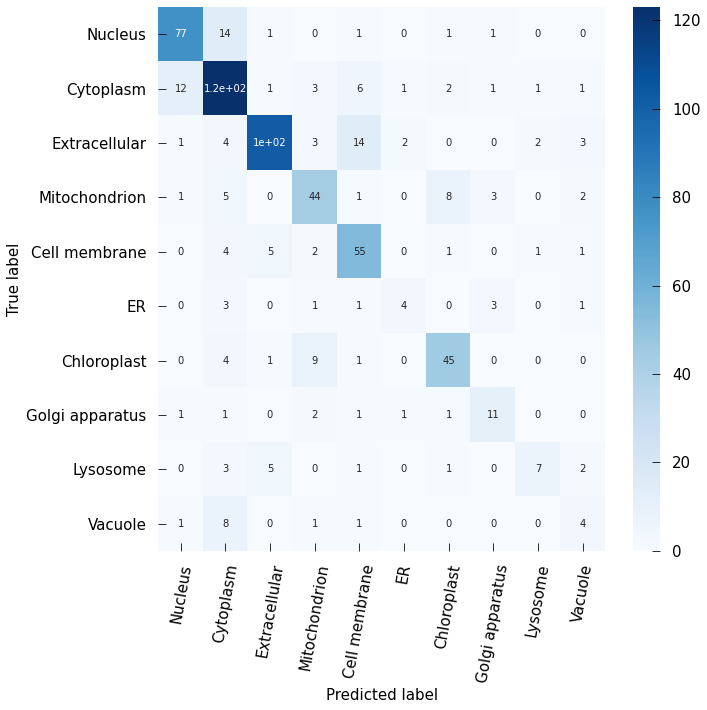

In [196]:
model.eval()

scaler_ = MinMaxScaler()
scaler_.fit(X_train_subcell_ready)

X_val_subcell_ready_scaled = torch.FloatTensor(scaler_.transform(X_val_subcell_ready))

y_pred = model(X_val_subcell_ready_scaled)
sm = torch.nn.Softmax(dim=1)
y_pred = sm(y_pred).detach().numpy()
_, y_pred = torch.max(torch.tensor(y_pred), dim=1)

confusion_mc_c = confusion_matrix(np.array(y_val_subcell_ready), y_pred)
df_cm_c = pd.DataFrame(confusion_mc_c, index=np.arange(10), columns=np.arange(10))

plt.figure(figsize=(10, 10))

ax = sns.heatmap(df_cm_c, annot=True, annot_kws={"size": 10}, cmap=plt.cm.Blues)

ax.set_xticklabels(list(dico_classes_subcell.values()), rotation=80)
ax.set_yticklabels(list(dico_classes_subcell.values()), rotation=0)

plt.ylabel('True label')
plt.xlabel('Predicted label')

plt.show()
plt.close()

# Transfer learning <a class="anchor" id="transfert"></a>

At the very beginning of this notebook we spent some time looking at how Deep Neural Nets were ultimately just finding a sophisticated way to represent our data so that our task (classification for example) would become easier/possible.

Transfer learning builds on that understanding. It proposes that for a similar task and for a closely related domain (basically the same features), a model trained on a similar data set might already be in a good place to solve the related task. You'd start with the pre-trained weights, instead of the usual Xavier or some other initialization. The model might then just need a bit of fine tunning of its weights for the new task that you want to solve. This fine tunning should not be too costly since the network is already in a good part of the representation space.

The simplest use of transfer learning would be to adapt the weights on the last linear layer (the one that feeds the softmax) to perform a new classification task. In the following picture, grey arrows represent frozen weights, i.e., weights that you'd not touch, keeping them as they were found. Darker arrows are the weights that you'd train for your new task.

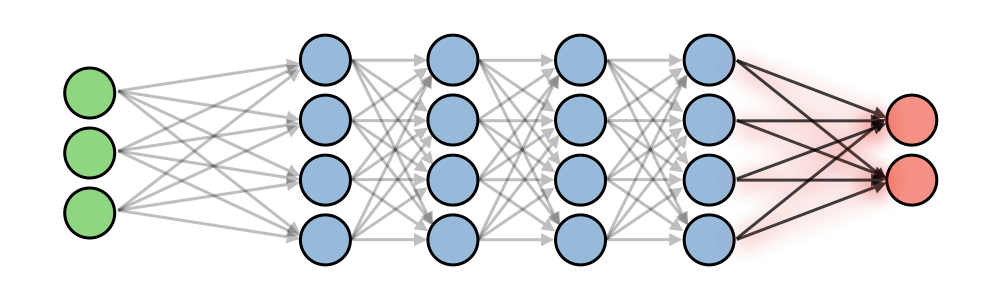

In [197]:
Image('images_intro/transfer-learning-small-ltr.png')

But you could imagine that the layer before that (which supposedly gave you the best representation for the problem the Net was trained on) is not 100% adequate for the new task. So you might want to tune those weights a little bit too. 

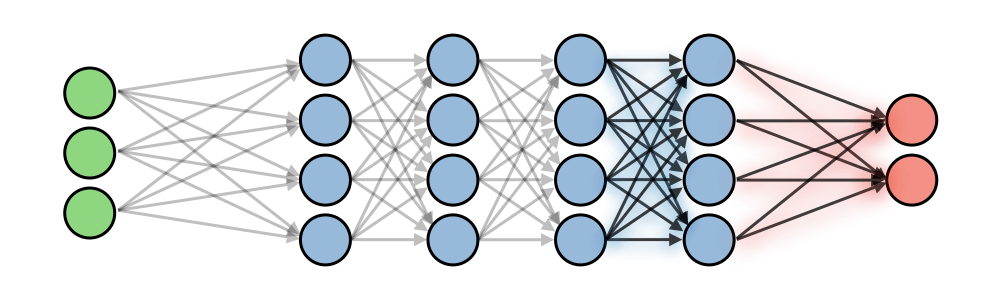

In [198]:
Image('images_intro/transfer-learning-medium-ltr.png')

And so on, up to the first layer if the new dataset is of comparable size to the one used to train the original model.

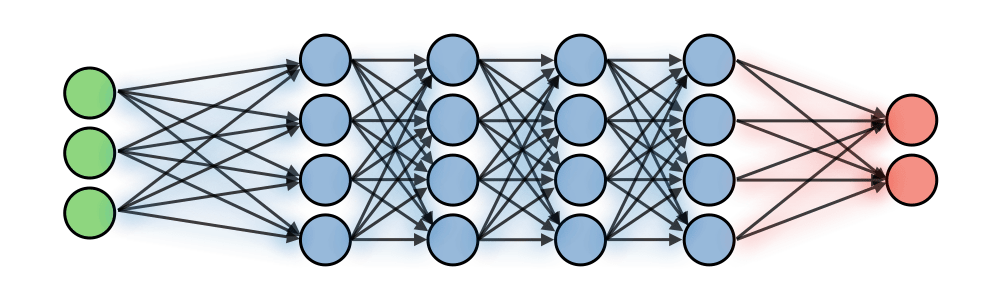

In [199]:
Image('images_intro/transfer-learning-large-ltr.png')

So how does one freeze some layers but retrain others? Let's go back to our Xor problem for an example.

Model before training
[('fc1.weight', Parameter containing:
tensor([[-0.5858, -0.8901],
        [ 0.6290,  1.6748]], requires_grad=True)), ('fc1.bias', Parameter containing:
tensor([ 0.3816, -0.5301], requires_grad=True)), ('fc2.weight', Parameter containing:
tensor([[-0.4272,  0.4375]], requires_grad=True)), ('fc2.bias', Parameter containing:
tensor([0.2231], requires_grad=True))]
Epoch 0: train loss: 0.7411850094795227 validation loss: 0.7133839130401611
Epoch 100: train loss: 0.24426695704460144 validation loss: 0.23370058834552765
Epoch 200: train loss: 0.027471033856272697 validation loss: 0.025782112032175064
Epoch 300: train loss: 0.014514702372252941 validation loss: 0.01269818376749754
Epoch 400: train loss: 0.009947630576789379 validation loss: 0.008223029784858227
Epoch 500: train loss: 0.007593424990773201 validation loss: 0.005974395200610161
Epoch 600: train loss: 0.006152554880827665 validation loss: 0.004659220576286316
Epoch 700: train loss: 0.005176268983632326 valida

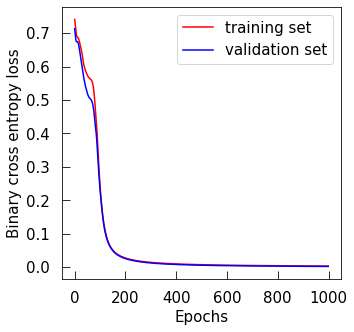

Model after training
[('fc1.weight', Parameter containing:
tensor([[-3.5153, -3.6430],
        [ 3.4356,  3.4060]], requires_grad=True)), ('fc1.bias', Parameter containing:
tensor([ 2.9011, -3.9989], requires_grad=True)), ('fc2.weight', Parameter containing:
tensor([[5.7479, 6.0589]], requires_grad=True)), ('fc2.bias', Parameter containing:
tensor([-5.2296], requires_grad=True))]


In [200]:
model = Feedforward(2, 2)

param_optimizer1_before = list(model.named_parameters())
print('Model before training')
print(param_optimizer1_before)

training_overview(model, epochs, x_train, y_train, x_val, y_val)

param_optimizer1_after = list(model.named_parameters())
print('Model after training')
print(param_optimizer1_after)

Let's fine-tune only the last layer, where the classification decision is made, and freeze the representation layer.

Fine tune model after freezing but before training
[('fc1.weight', Parameter containing:
tensor([[-3.5153, -3.6430],
        [ 3.4356,  3.4060]])), ('fc1.bias', Parameter containing:
tensor([ 2.9011, -3.9989])), ('fc2.weight', Parameter containing:
tensor([[5.7479, 6.0589]], requires_grad=True)), ('fc2.bias', Parameter containing:
tensor([-5.2296], requires_grad=True))]
Epoch 0: train loss: 0.0035156607627868652 validation loss: 0.002349318703636527
Epoch 100: train loss: 0.0033191523980349302 validation loss: 0.002172274747863412
Epoch 200: train loss: 0.003130860859528184 validation loss: 0.0020118546672165394
Epoch 300: train loss: 0.002965647727251053 validation loss: 0.001876210211776197
Epoch 400: train loss: 0.0028191294986754656 validation loss: 0.0017592273652553558
Epoch 500: train loss: 0.0026881075464189053 validation loss: 0.0016569128492847085
Epoch 600: train loss: 0.0025701229460537434 validation loss: 0.0015664049424231052
Epoch 700: train loss: 0.0024632441345602274 v

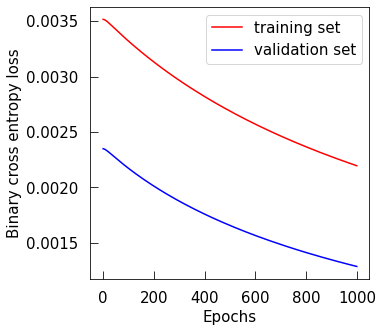

Fine tune model after freezing but after training
[('fc1.weight', Parameter containing:
tensor([[-3.5153, -3.6430],
        [ 3.4356,  3.4060]])), ('fc1.bias', Parameter containing:
tensor([ 2.9011, -3.9989])), ('fc2.weight', Parameter containing:
tensor([[6.3659, 6.8044]], requires_grad=True)), ('fc2.bias', Parameter containing:
tensor([-5.8167], requires_grad=True))]


In [201]:
model2 = model

param_optimizer_before = list(model2.named_parameters())
param_to_freeze_name = ['fc1.weight', 'fc1.bias']
param_to_freeze = [v[1] for v in param_optimizer_before if v[0] in param_to_freeze_name]
for param in param_to_freeze:
    param.requires_grad = False 

param_optimizer_after_freeze = list(model2.named_parameters())
print('Fine tune model after freezing but before training')
print(param_optimizer_after_freeze)

training_overview(model2,epochs,x_train,y_train,x_val,y_val)

param_optimizer2_after = list(model.named_parameters())
print('Fine tune model after freezing but after training')
print(param_optimizer2_after)

You can see by yourself how only the weights and bias of the last layer were modified.